In [58]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import fish_models
import robofish.io

In [59]:
fishes = 12

MeanShift clustering aims to discover blobs in a smooth density of samples. It is a centroid based algorithm, which works by updating candidates for centroids to be the mean of the points within a given region. These candidates are then filtered in a post-processing stage to eliminate near-duplicates to form the final set of centroids.

The algorithm automatically sets the number of clusters, instead of relying on a parameter bandwidth, which dictates the size of the region to search through. This parameter can be set manually, but can be estimated using the provided estimate_bandwidth function, which is called if the bandwidth is not set.

The algorithm is not highly scalable, as it requires multiple nearest neighbor searches during the execution of the algorithm. The algorithm is guaranteed to converge, however the algorithm will stop iterating when the change in centroids is small.

Labelling a new sample is performed by finding the nearest centroid for a given sample.

In [60]:
from sklearn.cluster import MeanShift
import sklearn.cluster as cluster
import sklearn.metrics as mt
import random

class MeanShiftFishModel(fish_models.gym_interface.AbstractRaycastBasedModel):
    def __init__(self):
        self.clustermodel = cluster.MeanShift(bandwidth=2, bin_seeding=True, max_iter=1)
        self.clusters = {}
        
    def choose_action(self, view: np.ndarray):
        # Return speed and turn from view
        param = np.random.randint(5, 51)
        speed = np.random.random() * param
        
        # step 1: try to find a cluster to make a friendship
        action = self.predict_action(view)
        #print(action[1])
        return 2 , 2*np.pi
    
    def predict_action(self, view: np.ndarray):
        clustermodel = self.clustermodel
        clusters = self.clusters
        
        #clustermodel.predict([view]) returns the index for list clustermodel.cluster_centers_
        prediction = clustermodel.cluster_centers_[clustermodel.predict([view])][0]
        #print(prediction)
        #return np.random.choice(clusters[str(prediction)])
        choice = random.sample(list(clusters[str(prediction)]), 1)
        print(choice)
        return choice
    
    def train(self, dset):
        clustermodel = self.clustermodel
        clusters = self.clusters
        
        actions = dset[:]["actions"]
        views = dset[:]["views"]
        
        #Train 
        clustermodel.fit(views)
        
        #collect clustercenters as dictionary
        for center in clustermodel.cluster_centers_:
            clusters[str(center)] = []
        
        #assign data to clustercenters
        for point in dset:
            prediction = clustermodel.cluster_centers_[clustermodel.predict([point["views"]])][0]
            clusters[str(prediction)] += [point["actions"]]
        
    
model = MeanShiftFishModel()

In [61]:
raycast = fish_models.gym_interface.Raycast(
            n_wall_raycasts=5,
            n_fish_bins=4,
            fov_angle_fish_bins=np.pi,
            fov_angle_wall_raycasts=np.pi,
            world_bounds=([-50, -50], [50, 50]),
        )



In [62]:
data_folder = Path("data/live_female_female/train")

dset = fish_models.datasets.io_dataset.IoDataset(
    data_folder,
    raycast,
    output_strings=["poses", "actions", "views"],
    reduce_dim=2,
    max_files=1,
)

  0%|          | 0/1 [00:00<?, ?it/s]

Loading data from 1 files.


  0%|          | 0/1 [00:00<?, ?it/s]

Calculating views from 1 files.


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

Created IoDataset:
Reduced the first 3 dimensions from (1, 2, 8989) to (17978)
poses	(17978, 3):	consisting of x, y, calc_ori_rad.
actions	(17976, 2):	consisting of speed[cm/s] and turn [rad/s].
views	(17976, 9):	4 fish_bins and 5 wall ray casts.



In [63]:
model.train(dset)

In [64]:
generator = fish_models.gym_interface.TrackGeneratorGymRaycast(
    model, raycast, [100,100], 25
)

track = generator.create_track(n_guppies=fishes, trackset_len=1000)

  0%|          | 3/999 [00:00<00:39, 25.40it/s]

[array([ 3.5903 , -2.98049])]
[array([ 5.19395, -1.00316])]
[array([ 8.9679 , -4.54971])]
[array([3.09321, 0.32394])]
[array([ 4.95729, -1.12841])]
[array([ 4.84433, -1.35252])]
[array([ 4.59599, -1.42013])]
[array([ 0.51162, 40.49583])]
[array([ 6.16927, -0.03437])]
[array([5.86669, 0.82887])]
[array([11.12271, -2.48121])]
[array([ 3.09828, -0.55061])]
[array([6.73399, 0.53452])]
[array([2.99017, 0.12182])]
[array([ 5.19501, -1.43935])]
[array([4.72856, 0.89973])]
[array([2.73058, 0.00086])]
[array([7.14913, 2.00819])]
[array([4.13323, 5.45658])]
[array([ 7.14141, -3.06315])]
[array([ 3.29146, -0.48875])]
[array([ 4.45827, -2.35116])]
[array([ 1.13104, -1.66459])]
[array([ 2.30489, -6.42575])]
[array([ 2.06281, -0.57065])]
[array([  1.0513, -15.5229])]
[array([5.93615, 0.95773])]
[array([2.89889, 0.00031])]
[array([1.54723, 0.36168])]
[array([10.91565,  2.06389])]
[array([5.40506, 1.84051])]
[array([ 5.01034, -2.31954])]
[array([0.7673, 0.    ])]
[array([ 7.71869, -1.69838])]
[array([

  1%|          | 10/999 [00:00<00:34, 28.77it/s]


[array([ 4.76707, -0.1491 ])]
[array([ 1.092  , -0.00068])]
[array([ 2.34024, -4.60912])]
[array([5.87845, 1.30038])]
[array([ 3.99989, -0.9599 ])]
[array([  0.0536 , -55.00534])]
[array([2.07417, 5.24396])]
[array([ 1.52905, -3.24398])]
[array([ 3.78701, -0.3032 ])]
[array([ 4.02663, 13.29904])]
[array([ 3.79155, -0.19294])]
[array([8.8646, 0.    ])]
[array([10.65013, -1.20778])]
[array([ 2.77776, -1.09232])]
[array([ 3.75379, -0.6449 ])]
[array([6.40615, 2.44306])]
[array([  1.94609, -76.40998])]
[array([ 1.99288, -5.9145 ])]
[array([ 4.77677, -1.9721 ])]
[array([ 4.34953, -3.14424])]
[array([3.94368, 0.0443 ])]
[array([0.58279, 0.07099])]
[array([ 4.11635, -1.37213])]
[array([  1.54611, -67.88808])]
[array([ 5.728  , -0.22119])]
[array([ 7.43571, -0.72992])]
[array([0.55991, 5.57254])]
[array([ 6.34578, -2.75614])]
[array([10.48952,  1.26356])]
[array([3.92509, 0.2467 ])]
[array([  0.65667, -12.75963])]
[array([ 1.39994, 57.49665])]
[array([4.88228, 5.1969 ])]
[array([8.80272, 1.03

  2%|▏         | 18/999 [00:00<00:29, 32.81it/s]


[array([5.13469, 0.17716])]
[array([ 4.61152, -2.39908])]
[array([ 3.10648, -0.00075])]
[array([4.62541, 2.47493])]
[array([2.34607, 1.33342])]
[array([7.45877, 0.     ])]
[array([3.70895, 2.66882])]
[array([ 0.63353, -6.03526])]
[array([4.72285, 2.81867])]
[array([ 2.09361, -0.995  ])]
[array([ 0.73726, -2.0377 ])]
[array([8.21569, 0.17594])]
[array([  2.16636, -10.2671 ])]
[array([3.49366, 2.40004])]
[array([2.59462, 1.33404])]
[array([ 2.2145 , -4.36079])]
[array([10.13052,  0.87514])]
[array([ 1.30442, -9.2408 ])]
[array([7.26694, 3.22098])]
[array([10.04388, -1.69466])]
[array([1.3124 , 4.93947])]
[array([ 5.58145, -1.72203])]
[array([ 6.39146, -2.14417])]
[array([8.43886, 0.     ])]
[array([6.15545, 0.     ])]
[array([5.31289, 3.19447])]
[array([11.55314, -0.39609])]
[array([ 4.43089, -1.55616])]
[array([4.24064, 1.06305])]
[array([ 6.27418, -0.79099])]
[array([ 3.9859 , -1.87424])]
[array([ 4.91823, -2.7164 ])]
[array([ 2.16503, -8.49429])]
[array([ 4.59306, -1.03287])]
[array(

  3%|▎         | 26/999 [00:00<00:28, 34.69it/s]


[array([5.20725, 0.40166])]
[array([1.53647, 4.91781])]
[array([ 1.45133, -3.13424])]
[array([ 4.3729 , -2.14508])]
[array([2.06489, 0.72959])]
[array([ 3.09027, -3.59367])]
[array([ 6.94021, -0.95621])]
[array([  1.03277, -53.35872])]
[array([ 5.32615, -0.78698])]
[array([ 5.41379, -2.97637])]
[array([3.07095, 0.     ])]
[array([5.72843, 0.43499])]
[array([2.3696 , 2.35744])]
[array([ 2.01557, -4.68421])]
[array([6.04148, 5.61996])]
[array([7.55054, 1.63236])]
[array([ 4.24815, -2.32506])]
[array([ 4.83397, -0.95416])]
[array([ 6.70919, -3.07507])]
[array([ 6.54594, -0.35097])]
[array([10.52282, -2.27558])]
[array([0.98183, 0.41675])]
[array([ 3.17462, -1.74659])]
[array([4.01225, 3.65905])]
[array([8.59278, 0.46232])]
[array([8.54586, 2.18328])]
[array([ 4.88247, -3.76159])]
[array([ 3.79237, -4.77274])]
[array([4.89658, 1.79147])]
[array([5.36072, 1.92551])]
[array([4.12846, 0.02616])]
[array([ 6.25602, -0.01953])]
[array([1.47807, 0.00191])]
[array([2.7123, 2.7637])]
[array([ 1.87

  4%|▎         | 35/999 [00:01<00:25, 37.43it/s]

[array([  0.95948, -10.88264])]
[array([ 7.08427, 16.02365])]
[array([3.86761, 0.4337 ])]
[array([ 5.40189, -1.93748])]
[array([7.45223, 0.81955])]
[array([3.16645, 8.51921])]
[array([ 8.51986, -0.76441])]
[array([ 8.08745, -2.64713])]
[array([ 5.12549, -0.91061])]
[array([2.79265, 0.09406])]
[array([9.09761, 1.30768])]
[array([ 7.51594, -4.09949])]
[array([11.77711, -0.15879])]
[array([0.75323, 2.48076])]
[array([ 2.01722, -0.91578])]
[array([8.61676, 0.57949])]
[array([ 0.17381, -1.4882 ])]
[array([3.30656, 3.95913])]
[array([ 6.6797 , -3.85693])]
[array([1.69677, 0.     ])]
[array([5.51808, 1.1301 ])]
[array([ 7.03429, -0.28908])]
[array([4.74817, 2.14986])]
[array([1.26707, 5.2388 ])]
[array([ 2.14094, -0.90342])]
[array([0.38968, 5.51202])]
[array([4.14823, 2.34475])]
[array([ 5.60679, -2.58456])]
[array([5.23178, 4.33128])]
[array([ 8.21256, -1.77402])]
[array([8.90075, 2.3066 ])]
[array([3.92358, 0.68493])]
[array([ 5.27887, -0.00022])]
[array([5.23013, 5.1922 ])]
[array([1.6564

  4%|▍         | 39/999 [00:01<00:26, 36.65it/s]


[array([5.52775, 1.94439])]
[array([ 5.20626, -5.21234])]
[array([ 8.49693, -3.37886])]
[array([ 5.08872, -2.21502])]
[array([1.83496, 0.8968 ])]
[array([3.15348, 0.05264])]
[array([ 2.17057, -4.92061])]
[array([3.52618, 5.20088])]
[array([ 4.10522, -3.51582])]
[array([4.61996, 0.51198])]
[array([0.46859, 0.00283])]
[array([7.9318 , 0.95594])]
[array([9.38824, 3.16693])]
[array([5.88461, 1.3848 ])]
[array([ 1.12124, 17.53473])]
[array([ 9.16713, -4.04648])]
[array([ 1.54666, 13.85069])]
[array([ 5.97256, -1.22829])]
[array([ 6.06167, -0.16806])]
[array([2.15643, 4.22336])]
[array([ 3.31944, -2.68189])]
[array([ 5.1881, -3.2153])]
[array([ 1.4637 , -2.25419])]
[array([3.85328, 0.96233])]
[array([0.10222, 0.00981])]
[array([12.48227,  0.82014])]
[array([4.94759, 0.86039])]
[array([ 2.07295, -0.00013])]
[array([ 5.95322, -2.31559])]
[array([ 5.33717, -3.61568])]
[array([10.44355, -1.24465])]
[array([2.89889, 0.00031])]
[array([ 2.16683, -7.50013])]
[array([8.40965, 0.64276])]
[array([6.9

  5%|▍         | 47/999 [00:01<00:26, 35.78it/s]


[array([ 3.45162, -3.77408])]
[array([1.78541, 4.08091])]
[array([ 0.31787, 16.46571])]
[array([ 0.48537, 25.70084])]
[array([ 2.6852, -8.8563])]
[array([ 1.18866, -7.34502])]
[array([ 5.10637, -0.87747])]
[array([5.87845, 1.30038])]
[array([6.43994, 0.98242])]
[array([ 2.59188, -2.24393])]
[array([5.31325, 0.68859])]
[array([ 5.70334, -2.56613])]
[array([ 8.49887, -4.21259])]
[array([ 1.41206, -0.00007])]
[array([4.0979 , 0.00015])]
[array([ 4.02136, -2.25124])]
[array([ 0.57353, 21.39998])]
[array([5.76177, 1.1056 ])]
[array([11.76709,  0.08765])]
[array([8.48172, 3.68006])]
[array([7.55991, 1.60678])]
[array([6.24814, 1.28977])]
[array([6.27242, 5.53802])]
[array([ 2.17768, -0.36424])]
[array([3.32121, 5.37543])]
[array([5.65128, 2.0116 ])]
[array([3.97824, 1.13407])]
[array([3.3966 , 0.00068])]
[array([0.76324, 0.84929])]
[array([8.8735 , 2.63893])]
[array([3.36544, 4.50487])]
[array([8.24998, 3.04896])]
[array([5.51255, 0.67967])]
[array([5.3072 , 2.45071])]
[array([ 1.89717, 30.

  6%|▌         | 57/999 [00:01<00:24, 38.59it/s]


[array([ 5.47998, -2.60148])]
[array([7.05636, 0.3888 ])]
[array([ 1.78343, -0.00391])]
[array([3.1567 , 0.70955])]
[array([ 2.95539, -0.15914])]
[array([ 6.42106, -3.66292])]
[array([4.58736, 2.12783])]
[array([  1.03472, -18.89229])]
[array([ 1.58556, -0.97828])]
[array([7.12956, 2.19793])]
[array([ 4.4325 , -2.99582])]
[array([ 2.96114, -0.91607])]
[array([4.58384, 1.97493])]
[array([ 2.77232, -1.00455])]
[array([8.57315, 2.86424])]
[array([3.16453, 4.46187])]
[array([ 4.91294, -4.38073])]
[array([5.33551, 7.00392])]
[array([ 3.33929, -1.35931])]
[array([10.79203,  4.76511])]
[array([ 9.49239, -1.91101])]
[array([ 2.60842, 13.86019])]
[array([ 4.23511, -0.26263])]
[array([ 7.50553, -2.41565])]
[array([0.66028, 8.18422])]
[array([  0.84341, -11.4717 ])]
[array([  0.5556 , -13.90707])]
[array([5.4789 , 0.45957])]
[array([9.89121, 3.45453])]
[array([3.59926, 0.00064])]
[array([ 6.98918, -0.7067 ])]
[array([ 0.85106, -2.59161])]
[array([5.97876, 0.07179])]
[array([ 5.96524, -0.41804])]

  7%|▋         | 66/999 [00:01<00:23, 39.09it/s]


[array([1.89066, 4.73614])]
[array([ 2.28449, -4.66978])]
[array([ 2.36237, -3.81916])]
[array([ 3.88711, -2.47525])]
[array([9.64191, 1.77361])]
[array([6.96959, 0.     ])]
[array([2.33818, 2.96708])]
[array([4.56018, 1.60286])]
[array([ 4.45461, -1.36609])]
[array([ 4.55854, -1.26372])]
[array([ 5.61252, -5.7629 ])]
[array([4.18752, 2.83946])]
[array([ 0.61573, -4.35987])]
[array([ 9.33499, -4.718  ])]
[array([2.1348, 0.5579])]
[array([6.97913, 1.10291])]
[array([0.40971, 0.00579])]
[array([ 3.89092, -1.70601])]
[array([10.23978, -0.62175])]
[array([4.42476, 2.72566])]
[array([ 5.7911, -3.0056])]
[array([4.11999, 1.2457 ])]
[array([ 1.92961, 13.91958])]
[array([ 8.97114, -0.23144])]
[array([5.43344, 3.11434])]
[array([13.89271,  2.49752])]
[array([2.48344, 0.00047])]
[array([5.67096, 0.75913])]
[array([ 3.67174, -0.18769])]
[array([ 1.18115, 71.54767])]
[array([ 5.72418, -1.59022])]
[array([5.5437 , 0.00045])]
[array([ 2.05573, -1.76563])]
[array([1.14488, 0.70529])]
[array([ 3.5031

  8%|▊         | 75/999 [00:02<00:23, 39.16it/s]


[array([5.52775, 1.94439])]
[array([7.41221, 0.96778])]
[array([ 8.74606, -3.78103])]
[array([3.41354, 0.00127])]
[array([ 3.97376, -0.02522])]
[array([7.66119, 0.0003 ])]
[array([4.56837, 0.19758])]
[array([ 2.74216, -3.059  ])]
[array([ 4.42139, -2.854  ])]
[array([8.5853 , 0.79033])]
[array([4.18807, 0.83828])]
[array([  0.87909, -18.08529])]
[array([5.46072, 3.20514])]
[array([ 6.79927, -3.85539])]
[array([ 7.31872, -0.82844])]
[array([5.80597, 0.79729])]
[array([9.15248, 0.     ])]
[array([6.99434, 2.04385])]
[array([ 4.13802, -8.82651])]
[array([ 3.54647, -1.00214])]
[array([ 7.05654, -0.59203])]
[array([3.89781, 0.00017])]
[array([ 2.41146, -4.45164])]
[array([2.94221, 2.40529])]
[array([ 4.10616, -1.24001])]
[array([ 5.27731, -0.22503])]
[array([6.60242, 0.96051])]
[array([ 2.84204, -1.27324])]
[array([8.53185, 2.54125])]
[array([3.43564, 0.56357])]
[array([8.28535, 2.50346])]
[array([1.92308, 0.     ])]
[array([ 4.24628, -0.80709])]
[array([ 1.478  , -0.39978])]
[array([3.338

  8%|▊         | 79/999 [00:02<00:24, 38.27it/s]


[array([ 4.57808, -1.15649])]
[array([1.17324, 2.01625])]
[array([9.02236, 1.84754])]
[array([5.82176, 0.38055])]
[array([0.10222, 0.00981])]
[array([ 3.28042, -2.21483])]
[array([7.30579, 0.92063])]
[array([ 1.94726, -0.20975])]
[array([ 1.10279, 10.10032])]
[array([ 2.48352, -0.01127])]
[array([ 2.51708, -1.60961])]
[array([10.1428 ,  1.00036])]
[array([ 7.5436 , -6.29609])]
[array([3.68419, 1.66561])]
[array([ 9.25973, -0.74383])]
[array([4.04566, 2.23669])]
[array([4.6915 , 2.05743])]
[array([  0.91096, -21.42418])]
[array([5.53609, 3.54802])]
[array([4.61184, 0.21227])]
[array([8.80443, 0.     ])]
[array([ 1.92533, -0.46527])]
[array([7.49376, 5.48374])]
[array([ 1.4637 , -2.25419])]
[array([5.69228, 3.40622])]
[array([8.79635, 0.94266])]
[array([6.69362, 3.92898])]
[array([  0.86347, -19.11055])]
[array([5.07755, 1.01022])]
[array([7.33883, 0.26214])]
[array([10.81163, -1.34954])]
[array([ 5.93764, -1.72063])]
[array([ 1.018 , -0.8139])]
[array([ 3.70202, -0.59526])]
[array([1.3

  9%|▉         | 88/999 [00:02<00:23, 38.73it/s]


[array([ 1.33384, -9.16361])]
[array([0.28432, 0.01177])]
[array([7.91415, 2.41194])]
[array([  0.74095, -35.85227])]
[array([ 5.2986 , -0.90043])]
[array([6.69303, 3.61684])]
[array([1.71125, 1.81375])]
[array([ 7.28286, -6.76527])]
[array([ 0.40545, 44.63434])]
[array([ 1.92688, -7.22486])]
[array([ 7.37473, -4.157  ])]
[array([4.71382, 4.94682])]
[array([ 6.62699, -1.20608])]
[array([0.35335, 6.02609])]
[array([ 7.67385, -5.11761])]
[array([3.54822, 1.66819])]
[array([7.79679, 0.7805 ])]
[array([ 2.49925, -4.09068])]
[array([8.02916, 1.72678])]
[array([ 3.8255 , -1.82272])]
[array([2.27974, 4.53634])]
[array([12.74868,  2.58108])]
[array([ 4.39763, -1.2368 ])]
[array([5.42611, 2.54852])]
[array([ 0.09437, 53.10497])]
[array([8.98464, 5.62244])]
[array([ 5.43181, -1.01618])]
[array([ 1.297  , -1.94788])]
[array([ 1.17306, -3.13583])]
[array([ 8.68863, -0.13811])]
[array([3.17645, 0.00037])]
[array([ 6.30993, -3.22323])]
[array([6.19902, 4.92553])]
[array([5.30092, 4.50644])]
[array(

 10%|▉         | 97/999 [00:02<00:23, 38.25it/s]


[array([ 4.34927, -0.07249])]
[array([3.97151, 0.14901])]
[array([6.75563, 0.00027])]
[array([6.19981, 2.16311])]
[array([2.64723, 3.86736])]
[array([2.34242, 2.43011])]
[array([8.13444, 0.44305])]
[array([11.26604, -3.63095])]
[array([  6.04245, -11.46311])]
[array([ 8.67057, -0.85312])]
[array([2.2191 , 1.52475])]
[array([6.16953, 0.73701])]
[array([ 3.10629, -0.00077])]
[array([ 9.27774, -1.61587])]
[array([2.08275, 4.22545])]
[array([ 1.85029, 26.70987])]
[array([ 5.77884, -1.59556])]
[array([7.1688 , 0.58619])]
[array([ 3.77498, -1.78296])]
[array([ 2.36229, -4.70301])]
[array([3.34355, 1.68425])]
[array([  2.18911, -13.95705])]
[array([1.92939, 7.87112])]
[array([2.73866, 2.34723])]
[array([ 4.2104 , -5.35541])]
[array([ 4.00575, -2.49954])]
[array([ 5.40928, -0.94765])]
[array([2.07417, 5.24396])]
[array([4.53697, 2.625  ])]
[array([ 6.29744, -2.47946])]
[array([6.46912, 3.10857])]
[array([3.97824, 1.13407])]
[array([ 5.01473, -0.59865])]
[array([6.55739, 2.09808])]
[array([ 4.

 11%|█         | 105/999 [00:02<00:23, 37.98it/s]


[array([1.83545, 1.1549 ])]
[array([ 6.53592, -4.26309])]
[array([ 3.5572, -0.7607])]
[array([ 2.39076, -1.20265])]
[array([ 5.97073, -0.24939])]
[array([0.56416, 0.0018 ])]
[array([ 2.11215, -0.22302])]
[array([4.06144, 1.51189])]
[array([ 7.01765, -0.45293])]
[array([5.68398, 1.75832])]
[array([5.8912 , 0.80135])]
[array([ 5.03409, -3.07867])]
[array([2.60721, 0.08194])]
[array([7.54576, 2.99784])]
[array([ 1.45262, -0.00066])]
[array([7.19058, 2.39685])]
[array([ 5.19501, -1.43935])]
[array([ 2.72953, -0.69063])]
[array([ 3.99218, -8.16249])]
[array([1.20438, 7.71962])]
[array([ 6.5026 , -0.13239])]
[array([ 5.64981, -3.7314 ])]
[array([ 1.91788, -0.00091])]
[array([1.95007, 0.     ])]
[array([1.97291, 4.45856])]
[array([8.85171, 2.54473])]
[array([8.48054, 3.13104])]
[array([ 6.13234, -0.00034])]
[array([ 0.89656, -4.63603])]
[array([4.43301, 0.11113])]
[array([  0.86347, -19.11055])]
[array([ 3.41949, -3.56475])]
[array([  0.95441, -16.17872])]
[array([7.73543, 0.82144])]
[array(

 11%|█▏        | 113/999 [00:03<00:23, 38.45it/s]


[array([3.14334, 5.12428])]
[array([ 2.69854, -3.49538])]
[array([ 3.48239, -1.12095])]
[array([ 5.74591, -1.05109])]
[array([ 3.20485, -0.84853])]
[array([ 2.63941, -3.94129])]
[array([ 4.37379, -1.24358])]
[array([3.6643 , 0.39977])]
[array([ 3.4156 , -2.19467])]
[array([3.53963, 1.67371])]
[array([1.72534, 2.8973 ])]
[array([ 4.54362, -2.07418])]
[array([ 5.00149, -2.76028])]
[array([3.15391, 4.58314])]
[array([ 0.25083, 24.6649 ])]
[array([1.60545, 6.50252])]
[array([ 6.39378, -2.80213])]
[array([  0.77744, -17.75839])]
[array([ 4.12791, -6.49467])]
[array([8.26205, 1.36501])]
[array([2.92814, 0.69649])]
[array([ 8.32424, -0.99119])]
[array([3.6805 , 3.72541])]
[array([ 3.82803, -1.42866])]
[array([5.09281, 1.19638])]
[array([ 2.9491 , -3.54176])]
[array([ 0.87493, 14.64674])]
[array([ 9.21652, -0.62557])]
[array([2.35614, 4.63338])]
[array([ 3.63118, -0.19352])]
[array([ 9.70433, -1.8437 ])]
[array([0.52724, 0.13607])]
[array([5.44756, 3.32791])]
[array([1.48068, 1.1445 ])]
[arra

 12%|█▏        | 121/999 [00:03<00:23, 36.98it/s]


[array([6.28654, 0.     ])]
[array([2.99752, 0.44297])]
[array([ 6.68176, -2.62558])]
[array([ 9.08969, -1.78163])]
[array([ 6.77628, -2.29049])]
[array([3.64684, 1.66739])]
[array([3.16893, 0.77572])]
[array([ 6.507  , 12.27821])]
[array([5.7971 , 1.74938])]
[array([ 2.14558, -0.00098])]
[array([1.83948, 0.40454])]
[array([ 5.83512, -0.00047])]
[array([7.863  , 3.30763])]
[array([3.94737, 1.383  ])]
[array([7.56526, 0.03612])]
[array([3.41352, 1.88708])]
[array([4.20878, 5.74903])]
[array([5.48768, 7.48864])]
[array([6.67465, 0.7488 ])]
[array([5.64458, 0.38812])]
[array([ 5.93668, 12.68391])]
[array([ 1.88179, -2.75919])]
[array([6.62093, 0.05881])]
[array([ 4.3585 , -0.45327])]
[array([2.71928, 2.47412])]
[array([ 6.26235, -1.42167])]
[array([ 6.31732, -1.8109 ])]
[array([7.13914, 1.39346])]
[array([7.00789, 1.96555])]
[array([7.52801, 2.15368])]
[array([ 3.77498, -1.78296])]
[array([ 7.45967, -2.41272])]
[array([ 5.25444, -1.89913])]
[array([  0.87909, -18.08529])]
[array([4.53108

 13%|█▎        | 129/999 [00:03<00:23, 36.27it/s]


[array([2.81472, 5.46052])]
[array([ 8.64344, -0.78869])]
[array([5.3936 , 1.95169])]
[array([ 2.57239, -3.3956 ])]
[array([ 2.62245, -1.20033])]
[array([ 2.33362, -0.60226])]
[array([ 7.86791, -1.84011])]
[array([6.52852, 1.72178])]
[array([2.4988 , 0.00011])]
[array([ 2.06105, -9.73451])]
[array([ 0.18024, 39.56413])]
[array([ 3.89143, -5.59391])]
[array([10.28039,  0.45662])]
[array([8.01151, 1.12335])]
[array([1.62295, 2.06596])]
[array([8.85701, 3.42832])]
[array([ 1.64148, -0.16456])]
[array([ 5.02773, -0.83016])]
[array([4.93303, 0.69358])]
[array([ 8.16626, -1.40747])]
[array([ 8.14665, -5.8366 ])]
[array([ 1.90745, -3.12781])]
[array([ 1.46895, -3.26494])]
[array([4.23321, 2.71898])]
[array([3.78883, 0.9756 ])]
[array([1.92142, 2.64103])]
[array([2.90466, 2.47162])]
[array([ 3.83982, -3.1402 ])]
[array([ 4.81594, -1.81027])]
[array([ 6.55693, -1.90398])]
[array([  0.79569, -12.20547])]
[array([6.43344, 2.21225])]
[array([ 2.43674, -1.81175])]
[array([3.65282, 0.     ])]
[arra

 13%|█▎        | 133/999 [00:03<00:25, 33.76it/s]


[array([ 9.91982, -1.84569])]
[array([ 5.43869, -0.46869])]
[array([ 5.6009 , -0.80371])]
[array([ 2.26539, -0.5856 ])]
[array([ 6.65512, -1.23093])]
[array([4.98204, 0.96464])]
[array([ 4.45682, -0.35886])]
[array([ 4.39517, -0.88207])]
[array([ 9.05181, -0.00008])]
[array([5.76177, 1.1056 ])]
[array([0.29804, 9.14817])]
[array([ 2.93893, -4.15598])]
[array([ 1.0971 , -6.55905])]
[array([4.74739, 0.24627])]
[array([ 4.21858, -1.3392 ])]
[array([ 7.86043, -1.67088])]
[array([ 0.46867, -0.00283])]
[array([ 4.14804, -0.55388])]
[array([4.72992, 1.88251])]
[array([6.62996, 0.     ])]
[array([ 4.85126, -0.10959])]
[array([ 3.6162 , -5.30916])]
[array([6.39635, 1.90804])]
[array([  0.38561, -12.40093])]
[array([5.40374, 3.35101])]
[array([ 5.10467, -0.34059])]
[array([ 5.38205, -0.4648 ])]
[array([ 5.73281, -3.00547])]
[array([ 4.66835, -0.60664])]
[array([ 1.49412, -1.31124])]
[array([ 5.09154, -0.04413])]
[array([2.51973, 0.00183])]
[array([8.48179, 1.59059])]
[array([3.66848, 0.54186])]

 14%|█▍        | 141/999 [00:03<00:25, 33.18it/s]


[array([ 2.32149, 10.48388])]
[array([ 3.27712, -0.00186])]
[array([8.38778, 2.92879])]
[array([ 5.39234, -7.90149])]
[array([ 6.8568 , -2.24769])]
[array([8.9851 , 1.37569])]
[array([8.39443, 2.52061])]
[array([ 2.24259, -1.38676])]
[array([ 2.72393, -0.45134])]
[array([ 2.05446, 46.04537])]
[array([9.18722, 0.91829])]
[array([ 3.74102, -0.86324])]
[array([ 7.77877, -3.30726])]
[array([ 3.95013, -3.47123])]
[array([  6.76846, -10.96317])]
[array([ 6.68117, -3.52176])]
[array([ 1.58509, -0.57406])]
[array([ 7.07909, -4.26366])]
[array([10.04388, -1.69466])]
[array([ 1.03817, 62.79991])]
[array([ 2.17458, -0.00046])]
[array([ 9.21908, -3.33932])]
[array([3.46249, 0.35097])]
[array([ 6.1042 , -1.30126])]
[array([  3.61264, -15.13491])]
[array([6.13779, 4.36924])]
[array([ 0.38975, -0.00605])]
[array([ 7.60182, -2.53192])]
[array([2.88564, 0.92825])]
[array([ 2.42621, -3.44856])]
[array([ 4.67163, -0.76687])]
[array([5.43439, 4.8882 ])]
[array([3.71666, 1.10981])]
[array([5.32735, 2.6719

 15%|█▍        | 149/999 [00:04<00:24, 34.88it/s]

[array([6.33829, 1.24148])]
[array([3.93457, 0.89937])]
[array([ 4.64202, -3.939  ])]
[array([7.09479, 1.47194])]
[array([0.82921, 0.00191])]
[array([ 7.31754, -1.76097])]
[array([ 2.51828, 11.82515])]
[array([3.3323 , 0.06117])]
[array([ 1.73969, -0.04661])]
[array([ 6.28211, -1.69685])]
[array([ 0.35269, 68.27347])]
[array([ 9.05854, -1.69492])]
[array([ 4.40702, -0.52114])]
[array([2.76784, 6.59612])]
[array([9.77881, 1.24789])]
[array([ 3.61865, -2.04984])]
[array([ 0.91666, 14.51209])]
[array([ 1.70946, -0.00194])]
[array([1.97236, 0.     ])]
[array([6.23052, 0.17212])]
[array([ 4.17178, -0.00146])]
[array([4.83788, 0.38694])]
[array([3.60214, 0.00053])]
[array([8.82951, 0.04818])]
[array([1.59936, 3.33068])]
[array([2.03779, 6.78772])]
[array([ 5.10948, -3.19408])]
[array([ 1.90066, -7.16078])]
[array([ 5.57057, -0.6844 ])]
[array([3.28371, 0.     ])]
[array([4.21929, 6.84211])]
[array([ 2.48994, -3.27334])]
[array([ 7.72479, -3.36861])]
[array([ 8.75163, -0.14364])]
[array([ 3.4

 16%|█▌        | 157/999 [00:04<00:24, 34.25it/s]


[array([8.48179, 1.59059])]
[array([2.59084, 6.47768])]
[array([ 4.0549 , -3.58672])]
[array([5.58554, 2.41947])]
[array([2.70285, 2.43415])]
[array([  0.85975, -39.61889])]
[array([ 0.39155, 37.01955])]
[array([ 8.71484, -8.08609])]
[array([ 3.66956, -2.16474])]
[array([4.21051, 3.64063])]
[array([4.7428 , 4.29141])]
[array([2.25638, 0.5579 ])]
[array([ 3.95896, -0.37916])]
[array([  0.66952, -68.06363])]
[array([2.6738 , 0.76258])]
[array([3.48598, 2.46656])]
[array([ 7.64169, -2.79102])]
[array([4.36941, 0.00017])]
[array([8.10145, 3.68873])]
[array([ 5.25459, -1.45874])]
[array([ 6.97324, -1.36179])]
[array([5.6663, 0.    ])]
[array([0.29755, 0.     ])]
[array([4.36938, 0.95165])]
[array([3.40045, 0.77152])]
[array([3.64586, 2.35408])]
[array([8.41009, 0.12811])]
[array([5.95247, 2.85128])]
[array([4.80618, 2.00762])]
[array([ 3.86097, 13.99736])]
[array([8.02502, 0.50831])]
[array([ 9.99089, -0.22555])]
[array([ 6.22694, -2.56206])]
[array([ 3.03767, -0.82149])]
[array([1.24008, 

 16%|█▌        | 161/999 [00:04<00:24, 34.20it/s]


[array([ 7.6734 , -3.08993])]
[array([ 7.69289, -2.52072])]
[array([15.54191, -2.68491])]
[array([8.27319, 2.3705 ])]
[array([ 6.86731, -3.42122])]
[array([2.7098 , 2.18667])]
[array([ 7.33654, -1.62511])]
[array([11.55809,  3.70691])]
[array([4.58855, 0.81263])]
[array([2.67577, 1.7451 ])]
[array([5.79153, 1.70686])]
[array([ 0.2525 , 13.45677])]
[array([2.83262, 0.00069])]
[array([ 2.26807, -1.74858])]
[array([ 5.49652, -0.37959])]
[array([ 2.77008, -4.64047])]
[array([0.27286, 2.42496])]
[array([6.58815, 0.     ])]
[array([ 3.2306 , -3.40216])]
[array([ 6.51867, -5.10802])]
[array([5.92789, 1.06354])]
[array([ 2.68452, -1.8591 ])]
[array([4.19661, 1.23053])]
[array([ 2.70276, -3.10261])]
[array([ 4.21162, -1.02087])]
[array([10.90654, -2.81974])]
[array([10.28435, -0.94746])]
[array([2.03668, 0.     ])]
[array([ 2.34069, -0.83536])]
[array([ 4.32421, -5.11305])]
[array([ 6.3435, -0.0005])]
[array([ 9.15361, -0.92125])]
[array([ 3.00662, -3.94873])]
[array([3.96793, 0.     ])]
[arra

 17%|█▋        | 170/999 [00:04<00:23, 34.89it/s]


[array([ 1.49263, -6.53616])]
[array([ 2.7767 , -2.14976])]
[array([ 6.74074, -2.17402])]
[array([3.36666, 1.13931])]
[array([3.67643, 2.49338])]
[array([6.6718 , 6.57907])]
[array([ 7.6275 , -1.78912])]
[array([ 6.77628, -2.29049])]
[array([10.41722,  0.51133])]
[array([ 4.80276, -0.2781 ])]
[array([ 7.40347, -3.49935])]
[array([5.01321, 0.40768])]
[array([2.26947, 1.17601])]
[array([9.98164, 1.81744])]
[array([3.55888, 1.98252])]
[array([ 3.29776, -0.81642])]
[array([ 2.99813, -0.50441])]
[array([ 4.84814, -3.03124])]
[array([ 2.09013, -0.93939])]
[array([5.02157, 0.29453])]
[array([7.44051, 0.90941])]
[array([ 1.26738, -0.00029])]
[array([ 8.42879, -1.55074])]
[array([ 7.64404, -0.83136])]
[array([5.90511, 3.18214])]
[array([  0.89577, -66.84054])]
[array([3.19485, 1.63597])]
[array([  1.03472, -18.89229])]
[array([3.23866, 0.53074])]
[array([ 1.94999, 24.48438])]
[array([ 2.33045, -5.19503])]
[array([ 5.53109, -0.95948])]
[array([ 10.53193, -11.13046])]
[array([2.8693 , 1.35022])]

 18%|█▊        | 178/999 [00:04<00:23, 35.66it/s]


[array([ 5.33315, -6.73635])]
[array([3.42809, 0.63453])]
[array([ 3.84875, -1.9762 ])]
[array([ 7.14141, -3.06315])]
[array([5.4762 , 0.70568])]
[array([11.27825, -3.47694])]
[array([ 8.9462 , -4.19999])]
[array([4.2069 , 0.00056])]
[array([3.34881, 0.62769])]
[array([ 7.52   , -2.13487])]
[array([ 5.3941 , -1.47751])]
[array([3.28714, 2.7813 ])]
[array([4.0632 , 2.94908])]
[array([3.43974, 0.76523])]
[array([ 3.51587, -2.95067])]
[array([6.28654, 0.     ])]
[array([ 8.46361, -1.6185 ])]
[array([ 6.87085, -2.71077])]
[array([ 3.26349, -0.99247])]
[array([2.89095, 0.40263])]
[array([3.02793, 2.57722])]
[array([ 4.92366, -0.67264])]
[array([ 4.15542, -0.49047])]
[array([12.32065, -1.75634])]
[array([ 2.44013, -0.08878])]
[array([ 2.39451, -2.65657])]
[array([3.87061, 2.99027])]
[array([4.97088, 1.57065])]
[array([6.82828, 1.76045])]
[array([ 2.53535, 46.53912])]
[array([ 4.41659, -0.30032])]
[array([ 4.21452, -3.61229])]
[array([27.75235,  3.32465])]
[array([ 3.40261, -1.67897])]
[arra

 19%|█▊        | 186/999 [00:05<00:22, 36.08it/s]


[array([4.41465, 0.19249])]
[array([ 0.28724, -7.08524])]
[array([8.22668, 1.68617])]
[array([3.47819, 0.91737])]
[array([ 1.75938, -2.54465])]
[array([10.55559, -3.47146])]
[array([ 6.48695, -1.19367])]
[array([ 6.78763, -2.86821])]
[array([4.10079, 4.53287])]
[array([ 7.21404, -3.5789 ])]
[array([5.50742, 1.1429 ])]
[array([ 3.05048, -2.48116])]
[array([ 3.79849, -1.03322])]
[array([2.7595 , 1.32337])]
[array([ 4.97016, -0.61797])]
[array([9.15881, 2.48228])]
[array([ 4.12763, -4.41828])]
[array([5.93615, 0.95773])]
[array([ 3.10433, 22.36257])]
[array([ 7.81032, -2.64409])]
[array([6.28995, 0.49654])]
[array([ 1.7316 , -2.12706])]
[array([ 6.17053, -2.11401])]
[array([2.94589, 1.32926])]
[array([5.61514, 0.73387])]
[array([1.70982, 1.9239 ])]
[array([ 4.27406, -0.76684])]
[array([ 0.79549, 11.81205])]
[array([3.21579, 3.22033])]
[array([  0.85001, -10.91358])]
[array([ 1.39004, -2.83834])]
[array([5.81148, 1.61328])]
[array([ 5.1573 , -0.62791])]
[array([ 2.22842, 28.79787])]
[arra

 19%|█▉        | 194/999 [00:05<00:21, 36.83it/s]


[array([8.64864, 0.41297])]
[array([0.85689, 9.0387 ])]
[array([  0.93703, -11.39381])]
[array([ 5.49652, -0.37959])]
[array([ 4.84938, -3.07063])]
[array([4.82068, 4.2776 ])]
[array([ 0.73107, -0.00287])]
[array([4.1135 , 9.13854])]
[array([  3.59353, -20.00781])]
[array([ 3.35027, -0.05714])]
[array([5.9196 , 1.59151])]
[array([2.50994, 1.40527])]
[array([ 5.08223, -0.84592])]
[array([ 4.36219, -2.85319])]
[array([ 3.19849, -0.06133])]
[array([ 8.26263, -0.46668])]
[array([ 7.984  , -1.98558])]
[array([8.50604, 0.68252])]
[array([ 3.16081, -6.87955])]
[array([2.79265, 0.09406])]
[array([ 2.02331, -0.18247])]
[array([3.72099, 5.02688])]
[array([4.16894, 1.69883])]
[array([4.34632, 4.11732])]
[array([6.52852, 1.72178])]
[array([  5.99394, -23.60403])]
[array([ 2.75196, -1.28686])]
[array([  1.36992, -17.8295 ])]
[array([4.92969, 0.7603 ])]
[array([6.20003, 0.1983 ])]
[array([ 2.22338, -0.63407])]
[array([ 2.00136, -3.63117])]
[array([ 9.17942, -0.27482])]
[array([ 7.31989, -0.87315])]

 20%|██        | 202/999 [00:05<00:21, 37.44it/s]


[array([1.91208, 1.85017])]
[array([8.60217, 0.70021])]
[array([4.72069, 2.06585])]
[array([ 8.22558, -3.01349])]
[array([5.60947, 0.0003 ])]
[array([ 5.64804, -0.00035])]
[array([11.10656,  1.38325])]
[array([3.0874 , 1.68084])]
[array([ 7.80727, -3.5895 ])]
[array([4.83788, 0.38694])]
[array([ 6.08786, -2.35437])]
[array([ 5.24467, -6.02081])]
[array([4.91271, 0.80133])]
[array([ 6.55477, -3.91584])]
[array([ 7.418  , -6.00178])]
[array([ 7.18123, -4.79338])]
[array([ 1.0736 , 13.60615])]
[array([8.02915, 2.16628])]
[array([4.15966, 2.39629])]
[array([ 3.2916 , -0.67864])]
[array([  0.50395, -26.14369])]
[array([5.47831, 4.35429])]
[array([5.50339, 1.08905])]
[array([3.80051, 0.     ])]
[array([1.08637, 2.62812])]
[array([ 4.93133, -6.90038])]
[array([8.90322, 1.1655 ])]
[array([ 3.37031, -1.44442])]
[array([ 7.08915, -1.06729])]
[array([5.90516, 2.51323])]
[array([4.91022, 0.     ])]
[array([ 3.87607, -0.3639 ])]
[array([ 7.58281, -0.34586])]
[array([  3.68442, -55.15105])]
[array(

 21%|██        | 210/999 [00:05<00:21, 36.77it/s]


[array([1.7977 , 0.63995])]
[array([ 0.91551, 27.4049 ])]
[array([0.60012, 0.00538])]
[array([6.33198, 3.26747])]
[array([4.66904, 0.1756 ])]
[array([ 8.6302 , -1.75542])]
[array([4.30247, 5.17149])]
[array([6.30903, 1.88744])]
[array([ 0.35606, 14.12896])]
[array([  2.37338, -11.43509])]
[array([ 7.01816, -5.16865])]
[array([5.5129, 4.2462])]
[array([ 4.60255, -1.00217])]
[array([  2.54372, -32.29379])]
[array([3.54138, 2.47965])]
[array([ 0.9615 , -6.85392])]
[array([ 5.47315, -0.51813])]
[array([ 1.7069 , -6.76984])]
[array([ 8.21015, -1.50654])]
[array([ 4.56092, -2.48964])]
[array([3.70017, 1.19841])]
[array([  0.04994, -40.63152])]
[array([1.77371, 0.02909])]
[array([ 7.41305, -3.08857])]
[array([2.17743, 2.37693])]
[array([3.79342, 0.     ])]
[array([7.01729, 2.25286])]
[array([4.11569, 0.     ])]
[array([ 6.4735 , -1.81182])]
[array([ 8.73592, -3.04383])]
[array([ 5.79764, -1.75534])]
[array([ 4.42964, -0.23318])]
[array([7.00191, 3.45865])]
[array([ 4.91966, -0.68866])]
[arra

 22%|██▏       | 219/999 [00:06<00:20, 38.56it/s]


[array([9.3257 , 0.65963])]
[array([ 0.58155, -6.88664])]
[array([1.48237, 0.59179])]
[array([4.18807, 0.83828])]
[array([ 2.62052, -2.63655])]
[array([ 1.39627, -4.28518])]
[array([7.8977 , 0.10076])]
[array([3.70369, 0.64034])]
[array([ 3.5587 , -0.43316])]
[array([1.09052, 0.3995 ])]
[array([ 2.89436, -2.201  ])]
[array([6.53581, 0.20433])]
[array([2.78211, 1.92173])]
[array([ 7.28274, -0.32878])]
[array([2.60535, 0.34634])]
[array([7.44084, 2.5995 ])]
[array([ 2.45339, -1.66486])]
[array([5.59639, 1.98922])]
[array([ 0.28922, 28.12944])]
[array([ 4.16644, -1.54647])]
[array([ 1.49384, -5.53634])]
[array([2.11621, 4.22198])]
[array([5.51808, 1.1301 ])]
[array([3.7079 , 1.21522])]
[array([ 2.69155, -3.03215])]
[array([4.68868, 2.5078 ])]
[array([7.43317, 1.61207])]
[array([ 2.00399, -1.47116])]
[array([ 4.82697, -1.13431])]
[array([ 6.82026, -1.73058])]
[array([ 2.89596, -1.02363])]
[array([ 1.35878, 13.25897])]
[array([2.16939, 1.95854])]
[array([4.47568, 5.15033])]
[array([7.26631

 23%|██▎       | 227/999 [00:06<00:20, 37.64it/s]

[array([ 3.89433, -4.839  ])]
[array([ 2.70766, -6.71484])]
[array([6.70887, 1.44048])]
[array([ 1.67873, -0.79654])]
[array([ 7.88601, -1.2877 ])]
[array([ 5.78238, -2.16808])]
[array([  0.28999, -12.92548])]
[array([4.69345, 2.48365])]
[array([1.88602, 3.99096])]
[array([6.25837, 0.2952 ])]
[array([ 4.88869, -4.78693])]
[array([3.95625, 2.1781 ])]
[array([ 2.30815, -4.29586])]
[array([1.66005, 0.34371])]
[array([0.26886, 7.66026])]
[array([ 4.65501, -3.22692])]
[array([ 3.52515, -0.30935])]
[array([0.46859, 0.     ])]
[array([3.59852, 3.84028])]
[array([  2.67146, -20.31532])]
[array([ 5.29936, -8.66564])]
[array([0.79345, 3.58224])]
[array([10.12779, -2.50994])]
[array([  0.16268, -33.57389])]
[array([ 3.80244, -5.30102])]
[array([ 3.05951, -0.97104])]
[array([ 4.53285, -1.8318 ])]
[array([  2.51424, -13.22125])]
[array([8.41009, 0.12811])]
[array([5.74802, 2.35137])]
[array([ 1.31783, -0.18989])]
[array([ 5.08524, -8.26722])]
[array([ 7.2356 , -3.02584])]
[array([ 0.84727, -3.5785 

 23%|██▎       | 231/999 [00:06<00:20, 36.83it/s]


[array([8.42879, 0.     ])]
[array([3.82083, 0.57626])]
[array([ 3.92636, -0.89128])]
[array([7.56458, 0.53278])]
[array([ 3.66769, -0.40937])]
[array([ 4.15209, -6.08968])]
[array([7.06602, 1.39975])]
[array([6.11959, 0.00048])]
[array([0.55788, 0.00427])]
[array([ 6.45272, -0.42199])]
[array([8.43309, 0.68336])]
[array([ 0.94369, 50.94252])]
[array([ 2.21231, -0.0005 ])]
[array([5.54152, 0.56136])]
[array([ 7.87357, -0.0003 ])]
[array([2.97487, 1.56617])]
[array([1.4148, 3.7601])]
[array([2.56581, 3.73967])]
[array([ 8.47285, -0.87326])]
[array([ 4.52618, -1.09694])]
[array([6.62624, 1.80052])]
[array([0.29755, 0.     ])]
[array([  1.0385 , -49.26801])]
[array([  1.3394 , -22.60941])]
[array([2.59159, 0.     ])]
[array([ 8.90982, -1.52459])]
[array([ 5.45972, -0.27279])]
[array([10.38571,  3.79588])]
[array([ 1.45262, -0.00066])]
[array([  6.76846, -10.96317])]
[array([7.49177, 4.07422])]
[array([ 2.1788 , -5.68123])]
[array([ 2.5247 , -0.40597])]
[array([ 0.79609, -5.5739 ])]
[arra

 24%|██▍       | 240/999 [00:06<00:19, 38.25it/s]

[array([ 7.06147, -0.11293])]
[array([ 2.90316, -1.45272])]
[array([ 5.66724, -0.52356])]
[array([3.71647, 2.96262])]
[array([ 5.00683, -4.0619 ])]
[array([13.25091,  3.00327])]
[array([2.03779, 6.78772])]
[array([ 8.16532, -0.70629])]
[array([3.97646, 2.69771])]
[array([ 1.42009, -8.87869])]
[array([7.63258, 0.6228 ])]
[array([ 6.13575, -0.2541 ])]
[array([ 4.58368, -2.61583])]
[array([5.12698, 0.14064])]
[array([ 4.39034, -6.09547])]
[array([10.49438, -0.01958])]
[array([  6.00601, -10.54014])]
[array([ 9.7127 , -0.38157])]
[array([5.59891, 0.56801])]
[array([ 0.21889, 18.82067])]
[array([6.04148, 5.61996])]
[array([2.13863, 0.00107])]
[array([5.01737, 6.40671])]
[array([3.03389, 0.39664])]
[array([1.10538, 6.15532])]
[array([3.58001, 0.19237])]
[array([ 5.4251, -1.8109])]
[array([ 3.74315, -2.43028])]
[array([  2.56781, -10.85712])]
[array([ 0.55119, -0.00418])]
[array([5.30092, 4.50644])]
[array([ 5.89462, -1.59788])]
[array([6.87551, 0.3513 ])]
[array([ 2.12041, -2.02675])]
[array

 25%|██▍       | 248/999 [00:06<00:20, 37.45it/s]


[array([4.5363 , 1.91311])]
[array([4.01308, 0.40586])]
[array([4.61199, 6.72185])]
[array([ 5.79764, -1.75534])]
[array([ 2.11258, -9.06834])]
[array([8.60217, 0.70021])]
[array([5.50707, 1.72363])]
[array([ 2.75391, -4.29499])]
[array([ 3.41016, -0.84272])]
[array([1.52515, 3.05238])]
[array([ 6.69426, -2.79713])]
[array([ 6.67482, -2.28199])]
[array([4.87111, 0.48993])]
[array([3.33411, 4.45918])]
[array([3.00012, 4.43465])]
[array([ 3.28573, -0.52123])]
[array([3.28714, 2.7813 ])]
[array([ 4.00682, -4.05577])]
[array([6.39635, 1.90804])]
[array([  2.26339, -16.06634])]
[array([10.65013, -1.20778])]
[array([ 3.3967 , -2.16086])]
[array([ 7.03873, -1.54152])]
[array([ 4.16638, -1.15948])]
[array([5.71116, 0.87846])]
[array([4.11727, 4.93774])]
[array([ 3.55386, -1.48409])]
[array([2.25638, 0.5579 ])]
[array([ 1.66023, -0.00076])]
[array([6.04977, 1.79138])]
[array([ 4.82349, -0.90796])]
[array([ 5.7828 , -1.18322])]
[array([6.8929 , 0.00018])]
[array([  2.64833, -14.26198])]
[array(

 26%|██▌       | 256/999 [00:07<00:20, 36.58it/s]


[array([ 3.12031, -0.66318])]
[array([ 6.8776 , -0.00018])]
[array([ 3.47232, 12.05698])]
[array([ 3.50806, -2.31114])]
[array([ 6.18211, -2.02824])]
[array([6.60621, 0.03729])]
[array([ 1.81629, -1.21576])]
[array([ 9.14044, -3.57479])]
[array([ 3.5844 , -0.75539])]
[array([10.39918,  2.07445])]
[array([2.015  , 0.00116])]
[array([ 0.25716, -0.00619])]
[array([ 1.10286, -7.66628])]
[array([4.86898, 0.19911])]
[array([ 2.50561, -1.16068])]
[array([ 4.30783, -4.85672])]
[array([9.13244, 1.79244])]
[array([ 3.23616, -0.13795])]
[array([5.94642, 0.87606])]
[array([5.29741, 2.32758])]
[array([ 5.47207, -1.53037])]
[array([ 1.45816, -0.35583])]
[array([3.38539, 1.50411])]
[array([3.42266, 1.95696])]
[array([12.74868,  2.58108])]
[array([9.40236, 1.78674])]
[array([0.40971, 0.00579])]
[array([3.34141, 2.32415])]
[array([3.44967, 0.     ])]
[array([4.95143, 0.     ])]
[array([ 4.42501, -1.76758])]
[array([3.51579, 0.87392])]
[array([ 5.64481, -0.78174])]
[array([5.22527, 4.47178])]
[array([ 

 26%|██▋       | 264/999 [00:07<00:20, 36.59it/s]


[array([11.1892 , -0.92155])]
[array([4.66283, 1.09223])]
[array([1.19565, 0.00183])]
[array([ 2.41952, -2.90014])]
[array([ 5.58023, -4.06613])]
[array([5.14844, 1.24796])]
[array([5.93935, 2.43606])]
[array([2.86904, 0.79895])]
[array([ 4.94565, -4.27885])]
[array([3.11361, 0.41191])]
[array([3.07369, 4.58282])]
[array([4.54114, 6.3495 ])]
[array([0.83174, 3.1539 ])]
[array([ 2.31238, -1.9165 ])]
[array([11.96519, -2.95868])]
[array([ 0.38975, -0.00605])]
[array([7.03877, 8.35966])]
[array([8.38318, 1.8346 ])]
[array([1.18283, 1.76022])]
[array([ 3.43554, -9.76323])]
[array([ 1.44291, -5.62594])]
[array([ 3.77737, -0.15558])]
[array([ 3.98846, -0.57207])]
[array([ 8.71484, -8.08609])]
[array([ 6.55903, -6.58917])]
[array([8.18824, 2.48737])]
[array([8.75456, 0.464  ])]
[array([3.74396, 1.00194])]
[array([  0.1107 , -13.41815])]
[array([  0.54565, -18.06727])]
[array([ 4.08455, -1.02085])]
[array([10.87128,  4.20791])]
[array([ 1.74016, -7.97285])]
[array([ 5.77884, -1.59556])]
[arra

 27%|██▋       | 272/999 [00:07<00:19, 37.21it/s]


[array([ 4.15233, -1.4131 ])]
[array([6.2858 , 1.10239])]
[array([ 1.16959, -3.08546])]
[array([ 3.31139, -3.11291])]
[array([3.79906, 1.3673 ])]
[array([3.28195, 1.48126])]
[array([ 5.51948, -1.78835])]
[array([ 4.89658, -0.54555])]
[array([1.7124, 0.    ])]
[array([ 4.63221, -0.94713])]
[array([7.6783 , 1.46735])]
[array([2.48709, 2.87267])]
[array([5.63821, 1.22547])]
[array([ 5.2674 , -0.88065])]
[array([ 0.55971, -2.08184])]
[array([2.94132, 3.28794])]
[array([ 6.29308, -2.85216])]
[array([6.19148, 1.45038])]
[array([8.22668, 1.68617])]
[array([ 3.53518, -4.19154])]
[array([ 2.16419, -4.81465])]
[array([ 3.95754, -2.87235])]
[array([ 5.71332, -5.44464])]
[array([2.54113, 0.00039])]
[array([10.11572,  2.20091])]
[array([ 0.53952, 11.91634])]
[array([ 6.23074, -1.06856])]
[array([ 2.21472, -1.7903 ])]
[array([ 1.06487, -0.00037])]
[array([ 6.17585, -5.95394])]
[array([9.84639, 3.09886])]
[array([  4.6232 , -14.77766])]
[array([ 0.     , 62.57153])]
[array([4.58855, 0.81263])]
[arra

 28%|██▊       | 280/999 [00:07<00:19, 37.55it/s]


[array([4.52831, 6.40889])]
[array([ 9.26507, -1.59845])]
[array([3.42537, 0.42823])]
[array([ 3.80153, -1.39233])]
[array([ 2.10158, -0.27669])]
[array([5.85322, 0.19113])]
[array([ 5.18751, -6.00072])]
[array([ 6.31819, -3.51665])]
[array([8.5862 , 2.57617])]
[array([2.7044 , 0.80701])]
[array([6.84235, 0.32046])]
[array([ 2.96458, 12.05149])]
[array([5.60575, 2.16009])]
[array([ 4.51684, -3.30257])]
[array([ 5.03788, -0.00007])]
[array([4.79507, 1.7315 ])]
[array([ 4.55268, -0.0457 ])]
[array([ 7.05721, -1.10912])]
[array([2.19784, 0.00145])]
[array([ 4.14914, -0.54754])]
[array([3.62214, 0.00025])]
[array([ 0.57888, -0.00412])]
[array([0.29755, 0.     ])]
[array([2.12143, 2.71446])]
[array([5.43846, 0.88891])]
[array([1.08013, 1.84567])]
[array([2.15019, 0.55901])]
[array([ 4.62455, -2.85409])]
[array([8.88773, 0.00051])]
[array([6.04202, 1.72672])]
[array([ 2.286  , -0.38024])]
[array([4.57789, 1.45728])]
[array([1.24515, 4.13238])]
[array([7.59272, 0.73753])]
[array([ 5.55077, 1

 29%|██▉       | 288/999 [00:07<00:18, 38.20it/s]


[array([7.42017, 0.67337])]
[array([5.88326, 0.28313])]
[array([2.59573, 1.9932 ])]
[array([10.46404, -2.01972])]
[array([ 3.64602, -1.58491])]
[array([2.52501, 2.62268])]
[array([8.21818, 1.98267])]
[array([ 4.20072, -3.50704])]
[array([ 5.0818 , -2.71814])]
[array([4.10686, 0.20775])]
[array([  0.30206, -53.9692 ])]
[array([2.13773, 2.7112 ])]
[array([ 3.61367, -2.40016])]
[array([ 4.05711, -0.27977])]
[array([3.6452 , 0.58205])]
[array([11.36347, -0.00008])]
[array([3.05707, 0.26426])]
[array([ 2.52805, -2.70675])]
[array([ 8.03189, -0.09143])]
[array([ 8.36322, -2.29818])]
[array([6.78055, 0.05968])]
[array([4.78483, 4.56456])]
[array([6.70525, 2.02492])]
[array([ 3.5486 , -2.70591])]
[array([ 1.45444, -1.18213])]
[array([ 0.64145, -9.48223])]
[array([ 6.54139, -2.76065])]
[array([ 1.62302, -5.23542])]
[array([5.94161, 0.59481])]
[array([ 1.28643, -7.00511])]
[array([ 1.62473, -7.45221])]
[array([ 6.91614, -0.94233])]
[array([7.15796, 0.749  ])]
[array([ 1.23378, -4.68646])]
[arra

 30%|██▉       | 296/999 [00:08<00:18, 38.42it/s]


[array([6.1957 , 0.93022])]
[array([ 6.56624, -2.07797])]
[array([3.46026, 2.0597 ])]
[array([ 2.58778, -0.12695])]
[array([0.90953, 1.2843 ])]
[array([4.33975, 1.86146])]
[array([8.07546, 1.27938])]
[array([ 2.86292, -0.47263])]
[array([4.9903 , 2.40187])]
[array([ 5.75439, -2.26109])]
[array([ 4.38643, -0.49796])]
[array([3.61167, 2.92231])]
[array([ 7.88063, -0.00067])]
[array([ 7.41148, -0.85348])]
[array([ 1.85479, -5.08229])]
[array([6.92856, 1.40281])]
[array([2.46603, 5.69494])]
[array([ 3.40606, -1.72794])]
[array([ 5.44383, -0.29461])]
[array([  0.50267, -13.0554 ])]
[array([9.99887, 1.11057])]
[array([5.14205, 0.     ])]
[array([4.59636, 4.13464])]
[array([ 2.45596, -1.13599])]
[array([ 7.55124, -0.32431])]
[array([ 2.76739, -0.00032])]
[array([5.48628, 1.51659])]
[array([2.99491, 2.51052])]
[array([  1.51777, -29.75443])]
[array([1.83925, 0.00074])]
[array([ 7.30836, -0.57837])]
[array([ 1.35878, 13.25897])]
[array([ 1.82209, -1.85915])]
[array([2.79004, 0.33781])]
[array(

 30%|███       | 304/999 [00:08<00:18, 37.08it/s]


[array([ 9.60288, -0.39433])]
[array([6.74549, 8.52855])]
[array([ 3.50347, -2.30822])]
[array([1.13443, 0.     ])]
[array([ 1.57541, -4.8395 ])]
[array([6.3272 , 3.00575])]
[array([3.92644, 1.29474])]
[array([ 5.85087, -1.77783])]
[array([ 6.16833, -1.81487])]
[array([2.37572, 0.35122])]
[array([12.5646 ,  0.27023])]
[array([ 0.21358, -6.39029])]
[array([5.32097, 0.07451])]
[array([ 5.74824, -4.12786])]
[array([ 1.70033, -3.94965])]
[array([ 2.13894, -7.50325])]
[array([ 0.9332 , -3.82092])]
[array([11.50835, -0.56743])]
[array([10.68152, -8.14721])]
[array([ 7.42868, -1.56385])]
[array([9.92257, 0.00046])]
[array([ 5.83708, -1.06178])]
[array([ 2.38436, -1.92083])]
[array([5.95644, 1.54064])]
[array([1.43565, 1.6984 ])]
[array([ 0.70412, -0.00218])]
[array([5.30869, 3.14179])]
[array([ 6.53563, -0.00073])]
[array([ 5.74102, -2.0836 ])]
[array([ 5.6009 , -0.80371])]
[array([6.53968, 0.08049])]
[array([9.73781, 0.94586])]
[array([ 9.26199, -0.92742])]
[array([ 0.26781, 58.29112])]
[ar

 31%|███       | 312/999 [00:08<00:19, 35.64it/s]

[array([  0.50267, -13.0554 ])]
[array([ 4.38638, -0.80075])]
[array([ 6.32597, 14.40907])]
[array([ 6.17193, -2.87629])]
[array([ 3.46282, -1.04461])]
[array([ 0.49082, 10.12406])]
[array([0.55788, 0.00427])]
[array([ 8.54562, -5.87067])]
[array([ 2.28865, -1.34595])]
[array([11.34372,  3.75795])]
[array([6.80251, 2.26388])]
[array([5.44759, 0.86987])]
[array([1.35886, 0.00126])]
[array([ 0.58115, 69.16852])]
[array([4.51227, 1.8684 ])]
[array([3.72305, 3.36044])]
[array([8.66292, 0.5589 ])]
[array([ 3.63118, -0.19352])]
[array([5.72931, 0.50652])]
[array([ 6.42926, -1.44926])]
[array([ 3.25291, -1.561  ])]
[array([ 1.52112, -4.5046 ])]
[array([3.88767, 0.     ])]
[array([ 3.51669, -3.91043])]
[array([6.15598, 2.2252 ])]
[array([ 1.80379, 70.03811])]
[array([ 4.38055, -0.08929])]
[array([ 2.96114, -0.91607])]
[array([6.83523, 0.88152])]
[array([9.24823, 8.46884])]
[array([ 4.88227, -2.15637])]
[array([  1.01843, -39.53391])]
[array([ 1.17058, -5.33505])]
[array([8.94676, 3.04556])]
[a

 32%|███▏      | 320/999 [00:08<00:19, 35.42it/s]


[array([8.32074, 1.13942])]
[array([7.77889, 3.7928 ])]
[array([6.18793, 2.24437])]
[array([ 4.87577, -0.75037])]
[array([7.72497, 0.64887])]
[array([  5.01829, -17.43513])]
[array([7.2839 , 0.37235])]
[array([ 1.63162, -0.00011])]
[array([  4.12016, -15.15788])]
[array([2.37778, 3.91349])]
[array([  4.12016, -15.15788])]
[array([9.28273, 2.61954])]
[array([ 8.37902, -1.24894])]
[array([6.46525, 1.17442])]
[array([ 3.64445, -9.92619])]
[array([1.40892, 1.82878])]
[array([6.34937, 1.39674])]
[array([  0.20474, -19.90477])]
[array([11.27825, -3.47694])]
[array([ 2.32169, -2.96455])]
[array([ 4.07674, -3.77611])]
[array([ 8.59184, -0.95205])]
[array([11.16413,  4.23399])]
[array([5.82942, 0.42652])]
[array([5.4402 , 5.09783])]
[array([9.86717, 6.50203])]
[array([ 0.28612, 20.35913])]
[array([3.0268 , 1.38716])]
[array([6.07245, 1.3011 ])]
[array([ 8.37242, -0.0867 ])]
[array([ 8.53423, -1.61661])]
[array([ 1.88041, -0.993  ])]
[array([7.40323, 2.05374])]
[array([2.18877, 3.35716])]
[arra

 32%|███▏      | 324/999 [00:08<00:18, 35.56it/s]


[array([ 8.36773, -1.71113])]
[array([7.62308, 5.56391])]
[array([ 8.7922, -1.8994])]
[array([ 5.65589, -2.00284])]
[array([3.99415, 4.77807])]
[array([3.57379, 0.32747])]
[array([ 3.73953, -2.57325])]
[array([7.24172, 2.62403])]
[array([4.93277, 0.00026])]
[array([ 6.25602, -0.01953])]
[array([6.79779, 1.79594])]
[array([5.82767, 1.9341 ])]
[array([ 8.97768, -0.25608])]
[array([4.9123, 3.5895])]
[array([2.2133 , 2.27116])]
[array([5.82583, 2.35476])]
[array([ 5.20707, -0.03083])]
[array([ 5.8133 , -4.00374])]
[array([3.90472, 1.86556])]
[array([ 9.41118, -3.34722])]
[array([0.43808, 0.00111])]
[array([5.94309, 2.74861])]
[array([ 2.28495, -1.27286])]
[array([ 1.92769, -2.09762])]
[array([6.13779, 4.36924])]
[array([11.18764, -2.06174])]
[array([ 9.48955, -3.42558])]
[array([ 3.29248, -0.00037])]
[array([ 6.1032 , -0.27338])]
[array([ 0.97757, -0.43809])]
[array([ 3.67339, -0.94258])]
[array([ 4.91227, -4.26401])]
[array([5.57598, 1.28701])]
[array([ 8.48625, -2.90042])]
[array([5.897

 33%|███▎      | 332/999 [00:09<00:18, 35.94it/s]


[array([0.46482, 2.30969])]
[array([  0.79861, -64.46019])]
[array([ 2.89908, -0.00031])]
[array([3.35358, 2.52796])]
[array([ 5.12073, -0.00315])]
[array([ 4.0251 , -5.31562])]
[array([ 5.88516, -1.90629])]
[array([4.55547, 0.58811])]
[array([ 2.90715, -1.08978])]
[array([ 4.59981, -5.01495])]
[array([2.22148, 1.03972])]
[array([ 1.45473, -7.0243 ])]
[array([0.24792, 2.31382])]
[array([4.31297, 1.3695 ])]
[array([ 6.99167, -1.35075])]
[array([4.55813, 2.64961])]
[array([ 5.2074, -2.9004])]
[array([6.76363, 2.77581])]
[array([ 1.35496, 12.88793])]
[array([ 1.82209, -1.85915])]
[array([3.10159, 0.     ])]
[array([6.19981, 2.16311])]
[array([4.10686, 0.20775])]
[array([3.59358, 0.17399])]
[array([ 1.77251, -0.1643 ])]
[array([ 2.74344, -0.08776])]
[array([2.25182, 3.37133])]
[array([  1.25437, -15.33154])]
[array([ 1.74999, -5.20674])]
[array([2.0741 , 0.78327])]
[array([  0.32686, -13.6848 ])]
[array([3.65282, 0.     ])]
[array([5.74701, 0.53663])]
[array([ 7.02792, -2.59359])]
[array(

 34%|███▍      | 340/999 [00:09<00:19, 34.55it/s]


[array([11.37059,  3.24233])]
[array([7.17391, 3.51638])]
[array([5.22945, 1.64622])]
[array([ 6.26421, -0.86556])]
[array([ 6.95895, -2.65658])]
[array([8.61699, 2.71224])]
[array([9.00523, 3.9412 ])]
[array([8.29056, 3.51584])]
[array([5.45009, 2.2079 ])]
[array([2.89898, 0.     ])]
[array([3.46619, 0.50424])]
[array([  0.56222, -12.75494])]
[array([ 7.05377, -1.36012])]
[array([ 2.69725, 27.96063])]
[array([ 6.8022 , -2.80172])]
[array([8.87245, 0.     ])]
[array([ 4.88583, -0.71511])]
[array([10.81323, -0.20202])]
[array([ 8.12109, -0.19322])]
[array([7.43329, 2.05329])]
[array([ 6.14188, -0.12991])]
[array([ 4.39517, -0.88207])]
[array([ 8.84472, -0.18838])]
[array([2.5028 , 0.74392])]
[array([ 2.9839 , -2.57071])]
[array([7.22632, 2.01409])]
[array([ 5.09498, -2.94925])]
[array([6.7794 , 3.69459])]
[array([ 6.72079, -1.13817])]
[array([2.6738 , 0.76258])]
[array([5.71419, 2.55066])]
[array([ 3.27973, -1.52425])]
[array([ 3.2959 , -0.68546])]
[array([2.95081, 0.2632 ])]
[array([ 

 35%|███▍      | 348/999 [00:09<00:18, 35.19it/s]


[array([5.66201, 3.08545])]
[array([ 5.58432, -1.41841])]
[array([ 3.5119 , -0.43461])]
[array([3.8024 , 0.35414])]
[array([5.37296, 0.39472])]
[array([4.39547, 2.29934])]
[array([ 5.98109, -0.00018])]
[array([ 2.23799, -1.27693])]
[array([ 3.57374, -0.0001 ])]
[array([2.79349, 2.10156])]
[array([4.39715, 0.00044])]
[array([ 2.82736, -2.78136])]
[array([3.28371, 4.16747])]
[array([ 2.12229, -5.69696])]
[array([ 1.55916, -4.6391 ])]
[array([ 5.06804, -5.98829])]
[array([6.34281, 3.12373])]
[array([10.91565,  2.06389])]
[array([ 4.8523 , -0.24922])]
[array([ 4.8523 , -0.24922])]
[array([ 2.11702, -6.30495])]
[array([2.17743, 2.37693])]
[array([3.3706 , 0.39567])]
[array([ 2.66169, -5.56488])]
[array([2.15541, 1.37382])]
[array([ 1.58804, -4.04454])]
[array([ 3.94466, -3.55204])]
[array([ 4.57825, -1.64178])]
[array([5.60523, 0.09384])]
[array([ 4.59221, -2.58507])]
[array([1.93451, 0.26745])]
[array([ 6.17167, -0.2602 ])]
[array([5.73784, 1.39449])]
[array([ 1.71671, -5.15788])]
[array(

 36%|███▌      | 356/999 [00:09<00:18, 34.50it/s]


[array([4.72886, 2.11613])]
[array([ 4.12505, -0.21506])]
[array([41.74762,  0.38168])]
[array([ 4.71386, -7.2932 ])]
[array([ 6.98383, -0.69072])]
[array([2.73326, 3.90034])]
[array([1.89066, 4.73614])]
[array([5.31519, 0.73518])]
[array([3.24589, 1.42971])]
[array([  4.66732, -18.3902 ])]
[array([ 6.21413, -2.02737])]
[array([ 0.67838, 33.99121])]
[array([ 4.12319, -2.59801])]
[array([3.03334, 0.9173 ])]
[array([6.13431, 2.79602])]
[array([11.21567, -3.16985])]
[array([ 4.6089 , -0.00032])]
[array([8.71417, 1.3783 ])]
[array([ 6.55283, -0.53612])]
[array([ 3.84198, -2.83019])]
[array([1.2774 , 2.91382])]
[array([  1.50158, -10.28041])]
[array([9.29648, 1.06872])]
[array([4.39887, 0.0001 ])]
[array([3.94368, 0.0443 ])]
[array([ 2.44039, -0.18256])]
[array([ 1.87147, -1.15155])]
[array([1.88042, 4.29619])]
[array([10.48185, -3.74328])]
[array([ 4.79202, -1.49695])]
[array([11.10355,  3.63944])]
[array([3.46051, 4.21259])]
[array([0.41192, 1.00982])]
[array([6.92642, 0.87021])]
[array(

 36%|███▌      | 360/999 [00:09<00:19, 33.16it/s]


[array([ 3.51664, -0.17441])]
[array([1.64838, 1.83764])]
[array([ 1.91788, -0.00091])]
[array([ 2.05602, -0.43625])]
[array([ 5.55314, -6.63632])]
[array([7.17712, 2.57148])]
[array([ 1.61376, -1.63025])]
[array([ 3.954  , -0.47478])]
[array([6.34657, 3.70378])]
[array([ 3.72011, -1.68005])]
[array([2.73691, 5.35699])]
[array([8.48631, 0.90606])]
[array([0.87232, 5.673  ])]
[array([1.00586, 4.17312])]
[array([  0.8306 , -10.92459])]
[array([ 3.05413, -6.8345 ])]
[array([5.35864, 4.6876 ])]
[array([ 4.0043 , -2.47024])]
[array([1.8833 , 0.37972])]
[array([10.85387, -1.35015])]
[array([ 2.92041, -2.67653])]
[array([6.99347, 3.62157])]
[array([ 6.13948, -0.59897])]
[array([ 3.58288, -1.27452])]
[array([2.29798, 3.33547])]
[array([ 9.8066 , -2.34177])]
[array([3.86761, 0.4337 ])]
[array([8.13542, 0.88574])]
[array([  4.27703, -16.89164])]
[array([  0.67462, -12.18305])]
[array([1.57016, 1.29853])]
[array([7.15099, 9.37605])]
[array([7.32309, 0.0006 ])]
[array([4.41307, 1.69091])]
[array(

 36%|███▋      | 364/999 [00:10<00:18, 33.44it/s]


[array([  4.89076, -15.82305])]
[array([8.68284, 1.76552])]
[array([ 5.55314, -6.63632])]
[array([ 7.09706, -4.07792])]
[array([ 4.46432, -5.43736])]
[array([3.55833, 0.89339])]
[array([  2.65022, -19.36009])]
[array([1.02628, 5.58134])]
[array([4.07415, 0.18494])]
[array([ 6.66768, -4.42306])]
[array([ 6.0126 , -1.38696])]
[array([ 6.39903, -1.63913])]
[array([2.55256, 0.69984])]
[array([ 4.12544, -2.47183])]
[array([5.86576, 1.78629])]
[array([8.0589 , 4.07422])]
[array([ 2.33868, -4.68178])]
[array([ 4.97016, -0.61797])]
[array([ 7.56334, -6.81528])]
[array([ 5.37998, -1.53689])]
[array([5.54345, 1.78986])]
[array([0.46859, 0.     ])]
[array([1.75636, 1.04455])]
[array([6.40615, 2.44306])]
[array([2.5028 , 0.74392])]
[array([4.146  , 0.99654])]
[array([1.03955, 0.00224])]
[array([5.82583, 2.35476])]
[array([ 1.54666, 13.85069])]
[array([2.64723, 3.86736])]
[array([ 2.15564, -0.00222])]
[array([ 6.75425, -1.96348])]
[array([4.27436, 0.00627])]
[array([  0.96421, -61.99877])]
[array(

 37%|███▋      | 371/999 [00:10<00:23, 26.37it/s]


[array([ 9.14435, -3.2824 ])]
[array([6.79198, 3.24806])]
[array([ 3.42392, -3.70266])]
[array([ 3.49034, -0.9992 ])]
[array([3.72432, 2.33289])]
[array([1.88122, 3.25353])]
[array([ 3.72987, -1.94666])]
[array([ 6.1032 , -0.27338])]
[array([ 1.78313, -4.10376])]
[array([ 1.31701, -0.1384 ])]
[array([4.44443, 2.07568])]
[array([ 6.55615, -0.23932])]
[array([1.57259, 3.3876 ])]
[array([4.89422, 3.29759])]
[array([9.70104, 0.00032])]
[array([2.2269 , 2.90568])]
[array([ 6.62886, -0.25744])]
[array([ 5.31479, -1.66717])]
[array([ 5.94428, -0.07493])]
[array([4.30633, 0.92088])]
[array([ 4.18662, -1.20936])]
[array([5.92821, 0.20467])]
[array([9.40539, 5.48653])]
[array([10.56007, -3.02847])]
[array([5.88021, 1.17896])]
[array([4.72992, 1.88251])]
[array([ 1.76096, 10.40259])]
[array([ 8.78886, -1.02198])]
[array([ 7.97627, -0.48338])]
[array([4.23459, 0.     ])]
[array([ 2.58214, -0.23356])]
[array([6.47765, 0.00035])]
[array([ 1.78104, -6.91874])]
[array([ 7.69869, -2.12912])]
[array([3

 38%|███▊      | 375/999 [00:10<00:23, 26.12it/s]


[array([2.78308, 1.40501])]
[array([ 2.46599, 31.20863])]
[array([6.11753, 2.11096])]
[array([ 2.51968, -0.95899])]
[array([ 4.51973, -3.33077])]
[array([ 8.98037, -0.30324])]
[array([4.14797, 6.83616])]
[array([5.60631, 3.79803])]
[array([2.58861, 0.00012])]
[array([ 1.83296, 10.30258])]
[array([ 0.92298, 30.20066])]
[array([ 3.50344, -1.75566])]
[array([ 0.08955, 11.18952])]
[array([5.3199 , 2.40742])]
[array([ 3.80057, -3.52947])]
[array([ 3.97376, -0.02522])]
[array([5.82176, 0.38055])]
[array([ 4.58918, -3.52645])]
[array([8.48028, 1.55956])]
[array([ 4.94346, -0.05352])]
[array([ 3.50565, -5.03087])]
[array([ 1.32482, -0.61135])]
[array([ 0.3529 , 36.94801])]
[array([ 7.10324, -3.05838])]
[array([3.89819, 2.94521])]
[array([ 0.7521 , 10.55225])]
[array([ 5.21001, -1.78946])]
[array([ 6.15723, -0.4841 ])]
[array([ 1.03737, -2.73618])]
[array([ 0.42958, 66.644  ])]
[array([ 6.31643, -4.16635])]

 38%|███▊      | 382/999 [00:10<00:24, 25.36it/s]


[array([9.988  , 2.40678])]
[array([ 2.90568, -1.2988 ])]
[array([ 2.58778, -0.12695])]
[array([ 4.12319, -2.59801])]
[array([ 7.71151, -2.41882])]
[array([9.00233, 3.44719])]
[array([ 7.02975, -0.08265])]
[array([3.39818, 1.85528])]
[array([ 7.82435, -4.05301])]
[array([8.73259, 2.71177])]
[array([ 5.60717, -0.25517])]
[array([3.30381, 3.4676 ])]
[array([ 1.45641, -1.37893])]
[array([5.73116, 0.0969 ])]
[array([ 3.12872, -0.43474])]
[array([ 3.93068, -0.15562])]
[array([ 4.61962, -0.31373])]
[array([ 2.20393, -0.74493])]
[array([9.83295, 0.27155])]
[array([ 6.67358, -2.02375])]
[array([ 6.69284, -2.26936])]
[array([ 8.70034, -1.52076])]
[array([1.01285, 6.66958])]
[array([ 1.39004, -2.83834])]
[array([ 3.70807, -0.71663])]
[array([3.87172, 0.     ])]
[array([ 0.46867, -0.00283])]
[array([ 2.93907, -1.13862])]
[array([2.3324 , 3.24214])]
[array([ 4.33884, -0.65296])]
[array([ 4.98468, -3.12068])]
[array([6.4664 , 2.61641])]
[array([ 2.89886, -3.0404 ])]
[array([ 5.99767, -2.33517])]
[

 39%|███▊      | 386/999 [00:10<00:22, 27.27it/s]


[array([0.61627, 5.21924])]
[array([2.9417 , 0.87597])]
[array([3.64538, 0.12991])]
[array([ 7.63234, -7.3033 ])]
[array([ 8.48325, -5.50897])]
[array([ 1.32482, -0.61135])]
[array([2.38702, 1.23651])]
[array([ 6.33885, -1.23023])]
[array([ 1.39994, 57.49665])]
[array([ 8.68011, -5.80902])]
[array([ 2.77017, -2.93144])]
[array([4.41277, 1.93818])]
[array([  1.0385 , -49.26801])]
[array([ 8.95542, -1.44127])]
[array([ 2.66138, -1.70439])]
[array([9.19352, 2.64733])]
[array([6.51257, 1.43636])]
[array([1.5905 , 3.49568])]
[array([ 8.42025, -0.23049])]
[array([7.17045, 1.22963])]
[array([ 5.3746 , -2.72391])]
[array([6.09295, 0.93047])]
[array([6.04148, 5.61996])]
[array([3.10629, 0.     ])]
[array([ 4.90467, -0.09608])]
[array([ 0.80176, -2.52593])]
[array([ 2.74784, -1.38964])]
[array([ 3.23071, 28.25716])]
[array([1.85254, 3.28643])]
[array([ 2.53317, -1.99409])]
[array([10.28039,  0.45662])]
[array([ 0.28724, -7.08524])]
[array([ 2.66636, -0.00078])]
[array([ 3.79237, -4.77274])]
[ar

 39%|███▉      | 392/999 [00:11<00:28, 21.61it/s]


[array([ 4.29958, -0.24392])]
[array([9.87204, 6.04469])]
[array([7.44051, 0.90941])]
[array([0.29755, 0.00035])]
[array([ 4.43341, -0.02737])]
[array([ 0.99172, 19.05703])]
[array([8.10997, 0.7435 ])]
[array([3.99485, 2.00626])]
[array([ 3.24385, -1.61839])]
[array([1.79832, 7.92897])]
[array([4.23334, 0.72063])]
[array([ 3.39675, -7.34451])]
[array([ 6.10021, -3.19853])]
[array([4.76463, 1.26626])]
[array([1.39482, 3.10881])]
[array([4.26337, 4.34078])]
[array([6.22958, 2.96659])]
[array([ 3.45837, -1.28731])]
[array([4.51754, 1.40927])]
[array([ 3.97185, -2.92035])]
[array([2.41071, 2.88179])]
[array([6.26953, 0.     ])]
[array([ 4.90431, -3.18196])]
[array([6.23311, 1.82083])]
[array([3.45894, 0.75431])]
[array([ 6.19573, -3.52201])]
[array([6.59861, 0.35285])]
[array([ 4.65501, -3.22692])]
[array([3.7345 , 0.53834])]
[array([9.29648, 1.06872])]
[array([10.43455, -4.0949 ])]
[array([4.2692 , 2.01651])]
[array([2.61557, 8.64285])]
[array([ 9.23512, -2.00728])]
[array([0.54164, 2.22

 40%|███▉      | 396/999 [00:11<00:24, 24.67it/s]

[array([4.23459, 0.     ])]
[array([ 8.73387, -2.88724])]
[array([ 4.94346, -0.05352])]
[array([ 3.48955, -4.43424])]
[array([4.34076, 1.9761 ])]
[array([2.51089, 1.19301])]
[array([ 5.86441, -0.18612])]
[array([1.29755, 1.03637])]
[array([ 6.33153, -2.83983])]
[array([ 2.40788, -2.70137])]
[array([  0.55288, -18.14627])]
[array([ 7.30889, -1.44445])]
[array([ 3.3061 , -2.24192])]
[array([ 3.10629, -0.00077])]
[array([7.37235, 2.0113 ])]
[array([4.00392, 2.10464])]
[array([2.27482, 0.00095])]
[array([ 2.89596, -1.02363])]
[array([4.03108, 0.7021 ])]
[array([3.51697, 1.92616])]
[array([5.91862, 1.75602])]
[array([2.85779, 3.76188])]
[array([ 0.75751, -5.29235])]
[array([ 0.31712, -0.0099 ])]
[array([5.68499, 0.91926])]
[array([7.54325, 0.62051])]
[array([ 2.47986, -3.65843])]
[array([8.24879, 2.06646])]
[array([1.03816, 0.00121])]
[array([7.467  , 6.39923])]
[array([ 8.64613, -1.94704])]
[array([4.87111, 0.48993])]
[array([ 2.30029, -2.46741])]
[array([ 6.09024, -0.63761])]
[array([ 4.4

 40%|████      | 403/999 [00:11<00:21, 27.12it/s]


[array([ 4.94817, -2.75568])]
[array([0.87393, 7.99927])]
[array([6.19902, 4.92553])]
[array([ 3.91284, -0.1653 ])]
[array([5.127  , 5.35355])]
[array([4.11431, 0.30727])]
[array([ 9.3835 , -2.08827])]
[array([2.45253, 0.13834])]
[array([4.68785, 0.     ])]
[array([ 5.99767, -2.33517])]
[array([ 1.9995, -2.3597])]
[array([6.68612, 1.0319 ])]
[array([5.86543, 0.58099])]
[array([  4.16223, -12.50688])]
[array([ 4.54019, -0.4102 ])]
[array([5.69586, 0.41229])]
[array([ 3.92374, -0.02503])]
[array([11.32061, -4.85412])]
[array([ 7.54045, -3.79722])]
[array([4.09662, 2.05331])]
[array([ 2.39076, -1.20265])]
[array([ 4.81227, -0.00092])]
[array([5.23119, 1.38508])]
[array([5.80937, 3.89885])]
[array([ 9.74722, -5.19631])]
[array([6.69303, 3.61684])]
[array([5.79091, 1.23629])]
[array([ 0.82468, 10.19023])]
[array([ 0.58881, 24.65027])]
[array([ 9.64024, -2.70956])]
[array([ 4.10027, -1.87691])]
[array([ 7.46382, -1.77154])]
[array([1.47791, 2.51399])]
[array([4.44193, 0.92437])]
[array([8.0

 41%|████      | 409/999 [00:11<00:24, 24.56it/s]


[array([5.23972, 1.09224])]
[array([11.55091,  2.54863])]
[array([ 6.24588, -0.78744])]
[array([3.37095, 1.07348])]
[array([5.38606, 0.54146])]
[array([8.00446, 2.30218])]
[array([5.74687, 2.18821])]
[array([6.51002, 1.17545])]
[array([2.70418, 0.23551])]
[array([7.45433, 0.32511])]
[array([ 2.55367, -2.00473])]
[array([ 3.51936, -0.00073])]
[array([3.38939, 1.27603])]
[array([ 1.90101, -0.79305])]
[array([3.92644, 1.29474])]
[array([ 8.14362, -3.51675])]
[array([ 2.34907, -2.57839])]
[array([ 1.99876, -1.37206])]
[array([7.50652, 2.02826])]
[array([ 0.16149, -0.02038])]
[array([2.82687, 0.46939])]
[array([3.68153, 2.77534])]
[array([ 0.74691, 24.90458])]
[array([ 7.62129, -0.88503])]
[array([  0.72686, -32.15883])]
[array([ 2.82505, -0.88758])]
[array([ 9.07595, -2.55531])]
[array([2.13143, 4.78601])]
[array([7.33775, 0.04444])]
[array([2.80508, 1.223  ])]
[array([ 6.18171, -2.05273])]
[array([ 5.04781, -0.92109])]
[array([4.42592, 0.79983])]
[array([4.87893, 0.38616])]
[array([9.470

 41%|████      | 412/999 [00:12<00:30, 19.20it/s]


[array([5.45867, 1.06053])]
[array([ 4.24253, -2.28595])]
[array([ 5.40247, -1.01531])]
[array([  0.34204, -12.74854])]
[array([ 2.76739, -0.00032])]
[array([ 6.0979 , -0.26524])]
[array([ 5.12908, -1.91906])]
[array([ 6.49218, -5.46837])]
[array([4.77811, 0.00111])]
[array([7.66136, 2.52705])]
[array([7.87698, 0.74718])]
[array([1.65644, 2.55532])]
[array([3.97533, 0.     ])]
[array([ 3.44264, -1.81274])]
[array([ 3.00317, -2.68372])]
[array([ 3.15185, -0.00064])]
[array([10.5438 ,  3.53816])]
[array([ 6.99998, -1.06522])]
[array([0.58279, 0.     ])]
[array([ 9.51895, -1.24962])]
[array([ 7.02368, -2.60989])]
[array([ 5.55077, 12.4658 ])]
[array([ 7.76616, -8.0086 ])]
[array([ 3.36843, -2.84508])]
[array([ 0.28138, -4.82784])]
[array([10.12779, -2.50994])]
[array([6.15545, 0.     ])]
[array([ 0.69913, -6.66703])]
[array([5.90956, 0.94467])]
[array([ 3.21452, -0.95314])]
[array([  0.96038, -10.26613])]
[array([ 6.63537, -0.11653])]
[array([3.18671, 0.208  ])]
[array([1.35461, 1.97169]

 42%|████▏     | 418/999 [00:12<00:26, 21.72it/s]

[array([2.18839, 1.96247])]
[array([ 2.17123, 26.71406])]
[array([2.99952, 3.78093])]
[array([ 4.43622, -3.65935])]
[array([3.63531, 0.4118 ])]
[array([  0.23642, -22.27739])]
[array([5.0088 , 0.80171])]
[array([ 0.54644, 62.88833])]
[array([ 3.85926, -1.04725])]
[array([ 8.2346, -0.4724])]
[array([ 0.15375, 58.16807])]
[array([ 8.88122, -2.07329])]
[array([ 2.5289 , -3.55797])]
[array([ 9.38865, -0.42002])]
[array([1.25313, 3.64926])]
[array([ 2.4018 , -3.99763])]
[array([ 3.34282, -3.66592])]
[array([7.30849, 3.16837])]
[array([ 1.7891 , -5.24515])]
[array([ 1.0557 , 18.62091])]
[array([4.20707, 3.7444 ])]
[array([2.17749, 1.99764])]
[array([ 1.57316, -1.98994])]
[array([ 3.06445, -0.00048])]
[array([  0.85001, -10.91358])]
[array([5.92915, 0.48669])]
[array([7.529  , 0.23403])]
[array([6.36438, 4.98669])]
[array([ 0.34953, 15.59701])]
[array([5.68814, 0.45693])]
[array([3.94909, 3.5902 ])]
[array([7.02646, 0.42526])]
[array([1.38447, 2.07985])]
[array([4.88228, 5.1969 ])]
[array([ 2

 42%|████▏     | 424/999 [00:12<00:24, 23.18it/s]

[array([ 5.99767, -2.33517])]
[array([  2.90737, -11.74192])]
[array([ 1.95599, -1.7539 ])]
[array([ 0.28724, -7.08524])]
[array([1.70626, 4.70677])]
[array([0.29755, 0.     ])]
[array([ 4.20363, -1.1166 ])]
[array([10.86084, -1.81063])]
[array([ 3.2514 , -0.99823])]
[array([ 3.98191, -4.20667])]
[array([11.61686,  3.40328])]
[array([2.92814, 1.63881])]
[array([ 7.09133, -3.76154])]
[array([0.92425, 8.273  ])]
[array([ 6.49505, -0.49334])]
[array([8.80542, 0.39264])]
[array([7.46218, 1.43495])]
[array([ 3.84596, -2.1595 ])]
[array([ 5.79795, -2.70711])]
[array([  0.5017 , -20.79528])]
[array([7.82745, 2.31982])]
[array([ 4.63297, -0.88503])]
[array([6.47283, 1.78405])]
[array([13.30473, -6.05145])]
[array([ 6.55477, -3.91584])]
[array([4.91633, 0.9692 ])]
[array([0.86667, 6.76729])]
[array([1.96307, 1.79033])]
[array([5.24882, 0.27905])]
[array([3.55054, 1.41969])]
[array([3.08661, 2.03247])]
[array([ 3.79543, -4.79308])]
[array([5.97679, 3.80832])]
[array([6.33438, 0.38308])]
[array([

 43%|████▎     | 427/999 [00:12<00:25, 22.60it/s]

[array([ 0.91124, -3.74292])]
[array([4.82406, 3.11866])]
[array([0.29755, 0.     ])]
[array([4.19216, 3.86072])]
[array([4.66283, 1.09223])]
[array([ 6.89585, -4.96735])]
[array([2.94829, 2.99397])]
[array([  0.15144, -10.3512 ])]
[array([ 6.27738, -1.61468])]
[array([2.67406, 1.5819 ])]
[array([ 6.16009, -0.86158])]
[array([5.59232, 3.71739])]
[array([5.80937, 3.89885])]
[array([6.9894 , 3.61771])]
[array([0.809  , 4.09503])]
[array([5.26675, 0.98851])]
[array([0.91085, 0.00256])]
[array([1.86573, 1.1696 ])]
[array([7.03117, 0.     ])]
[array([ 2.01869, 19.88399])]
[array([0.91085, 0.00256])]
[array([ 2.54284, -4.4419 ])]
[array([ 5.15346, -3.78186])]
[array([5.03125, 0.82094])]
[array([ 8.70774, -3.6936 ])]
[array([ 4.35061, -5.80519])]
[array([5.82176, 0.38055])]
[array([2.06489, 0.72959])]
[array([1.22099, 9.57986])]
[array([ 6.2835 , -4.40035])]
[array([5.07366, 9.03031])]
[array([ 4.81732, -3.59973])]
[array([6.93198, 0.     ])]
[array([ 0.55897, -6.81524])]
[array([  0.08159, -

 43%|████▎     | 434/999 [00:13<00:22, 25.44it/s]

[array([1.30754, 6.93255])]
[array([2.46004, 2.92684])]
[array([2.47815, 3.33603])]
[array([ 1.53513, -0.16873])]
[array([ 3.83414, -1.11915])]
[array([  3.1906 , -14.62192])]
[array([ 3.77802, -0.46949])]
[array([6.0052 , 1.94042])]
[array([ 4.99282, -2.97776])]
[array([ 4.0548 , -0.00015])]
[array([ 8.09805, -0.11034])]
[array([9.81108, 1.33594])]
[array([3.86761, 0.4337 ])]
[array([7.43527, 2.88745])]
[array([ 9.71574, -0.0006 ])]
[array([ 2.18335, -3.93908])]
[array([ 5.12018, -0.87782])]
[array([ 5.39261, -3.98267])]
[array([1.9194 , 0.91328])]
[array([2.56786, 1.4727 ])]
[array([  0.38664, -69.57985])]
[array([ 6.65552, -2.74362])]
[array([ 7.05654, -0.59203])]
[array([ 6.76518, -0.00001])]
[array([3.4607 , 0.00001])]
[array([5.74149, 5.5091 ])]
[array([ 5.86037, -0.00009])]
[array([3.28042, 0.00066])]
[array([2.04895, 0.00072])]
[array([ 2.67701, -5.01699])]
[array([4.22142, 1.24907])]
[array([4.5105 , 3.19137])]
[array([ 8.42345, -3.61401])]
[array([ 2.93433, -1.61562])]
[array

 44%|████▍     | 441/999 [00:13<00:18, 29.61it/s]


[array([8.02916, 1.72678])]
[array([ 4.86196, -0.84726])]
[array([7.97895, 3.67978])]
[array([5.11371, 0.     ])]
[array([ 1.71015, -3.73949])]
[array([ 3.43944, -0.00063])]
[array([ 8.54958, -0.77034])]
[array([1.882  , 1.89449])]
[array([1.55448, 1.60921])]
[array([3.03816, 3.80315])]
[array([8.68254, 1.73733])]
[array([ 4.09033, -0.00092])]
[array([10.35649,  0.96296])]
[array([ 3.12409, -0.04697])]
[array([ 6.25119, -0.05812])]
[array([1.53038, 0.11782])]
[array([3.28107, 5.68573])]
[array([4.32796, 1.01472])]
[array([6.53581, 0.20433])]
[array([ 8.47099, -0.01661])]
[array([4.46562, 3.10925])]
[array([  4.54697, -12.95497])]
[array([8.48447, 0.36256])]
[array([1.91208, 1.85017])]
[array([2.78799, 0.00146])]
[array([ 2.80111, -1.06736])]
[array([ 3.9079 , -3.89514])]
[array([ 2.19512, -0.36359])]
[array([5.96811, 0.00041])]
[array([ 6.51893, -1.9813 ])]
[array([ 1.76633, -1.47679])]
[array([5.29044, 3.66531])]
[array([ 8.21221, -0.99331])]
[array([10.09686, -2.14705])]
[array([2.3

 45%|████▍     | 449/999 [00:13<00:16, 33.16it/s]


[array([ 4.283  , 14.82672])]
[array([5.40042, 1.01985])]
[array([ 3.79543, -4.79308])]
[array([ 6.77628, -2.29049])]
[array([3.12715, 2.35899])]
[array([2.61833, 4.88649])]
[array([4.54764, 0.43805])]
[array([ 4.78284, -0.27814])]
[array([10.15925,  0.     ])]
[array([ 3.80546, -2.62772])]
[array([4.44413, 0.36258])]
[array([ 4.55468, -0.90615])]
[array([8.24998, 3.04896])]
[array([ 8.68011, -5.80902])]
[array([2.743  , 3.60479])]
[array([ 5.51064, -3.3203 ])]
[array([4.00493, 2.91786])]
[array([8.10557, 1.18892])]
[array([ 2.21188, 35.98545])]
[array([ 3.70912, -0.00055])]
[array([3.02854, 0.     ])]
[array([ 3.48039, -0.51817])]
[array([ 8.09423, -3.31524])]
[array([2.96196, 0.23185])]
[array([ 4.74261, -0.0693 ])]
[array([ 6.35152, -4.71824])]
[array([ 5.21001, -1.78946])]
[array([4.25578, 1.8424 ])]
[array([0.91746, 0.00224])]
[array([2.93322, 1.40016])]
[array([ 3.69461, -1.54218])]
[array([10.97414,  1.41596])]
[array([7.40849, 0.00006])]
[array([ 5.63034, -3.60416])]
[array([1

 46%|████▌     | 457/999 [00:13<00:15, 34.14it/s]


[array([ 9.07388, -1.24899])]
[array([ 1.78177, 56.43507])]
[array([6.33003, 1.91596])]
[array([ 2.14392, -0.66237])]
[array([6.13923, 0.94837])]
[array([ 3.32375, -6.11603])]
[array([2.43996, 6.09602])]
[array([10.58105,  2.26895])]
[array([ 0.70693, 54.8112 ])]
[array([ 3.09532, -3.69525])]
[array([ 2.68028, -6.94468])]
[array([8.72242, 0.00053])]
[array([ 1.54743, -0.44973])]
[array([ 3.50031, -5.38581])]
[array([ 7.59615, -0.36788])]
[array([ 1.69124, -0.33239])]
[array([ 7.80727, -3.5895 ])]
[array([8.02916, 1.72678])]
[array([6.89612, 0.38651])]
[array([0.91085, 0.00203])]
[array([2.18839, 1.96247])]
[array([ 1.45678, -0.00139])]
[array([ 0.42839, -2.50624])]
[array([0.62219, 0.64743])]
[array([ 6.35886, -3.3491 ])]
[array([9.78067, 0.05952])]
[array([ 2.47986, -3.65843])]
[array([8.22547, 5.88607])]
[array([3.99205, 2.3749 ])]
[array([  1.08514, -45.09875])]
[array([ 7.69289, -2.52072])]
[array([ 5.91132, -0.93805])]
[array([5.80515, 2.54073])]
[array([2.90364, 1.23906])]
[arra

 47%|████▋     | 465/999 [00:13<00:14, 35.90it/s]


[array([ 4.58354, -4.06862])]
[array([4.08834, 2.62714])]
[array([8.24208, 3.62233])]
[array([4.02578, 1.59111])]
[array([8.22668, 1.68617])]
[array([ 5.99767, -2.33517])]
[array([5.35679, 3.78927])]
[array([1.26982, 2.93261])]
[array([1.86573, 1.1696 ])]
[array([ 6.84741, -1.69594])]
[array([1.97236, 0.     ])]
[array([5.5437 , 0.00045])]
[array([ 4.24253, -2.28595])]
[array([ 6.77008, -4.16582])]
[array([3.6888 , 0.25379])]
[array([ 2.87736, -0.07839])]
[array([ 1.18293, -6.00829])]
[array([ 0.42394, -1.09959])]
[array([3.48782, 2.62832])]
[array([ 5.42438, -0.00077])]
[array([5.97876, 0.07179])]
[array([7.19281, 2.57794])]
[array([  2.24618, -14.69818])]
[array([ 2.6102 , -0.00518])]
[array([ 4.51169, -2.28989])]
[array([0.76324, 0.     ])]
[array([3.15136, 1.89219])]
[array([ 3.97376, -0.02522])]
[array([ 3.39723, -0.00692])]
[array([9.25973, 0.     ])]
[array([6.0082 , 0.77833])]
[array([2.5674, 2.4274])]
[array([ 4.60783, -3.63456])]
[array([0.38056, 6.92534])]
[array([ 0.60037,

 47%|████▋     | 473/999 [00:14<00:14, 37.31it/s]


[array([ 2.6264 , -7.20149])]
[array([ 2.43939, -1.5124 ])]
[array([3.21832, 0.96383])]
[array([ 2.7673, -2.3678])]
[array([ 4.94565, -4.27885])]
[array([4.87842, 2.31543])]
[array([4.13162, 1.36725])]
[array([1.96328, 0.00122])]
[array([9.15264, 1.7434 ])]
[array([4.50704, 4.07432])]
[array([1.83069, 3.8095 ])]
[array([ 3.28786, -3.2477 ])]
[array([7.36762, 2.3392 ])]
[array([ 6.97946, -0.35713])]
[array([4.91938, 6.74479])]
[array([1.98494, 1.58743])]
[array([ 4.84361, -3.35039])]
[array([ 3.81914, -0.33711])]
[array([1.3919 , 3.01383])]
[array([ 6.68117, -3.52176])]
[array([ 7.23993, -3.79787])]
[array([ 4.38069, -7.86514])]
[array([ 6.82373, -2.37578])]
[array([4.92365, 0.18431])]
[array([ 4.45682, -0.35886])]
[array([1.48476, 0.     ])]
[array([8.81935, 1.53725])]
[array([3.71736, 4.53134])]
[array([  0.94294, -25.1971 ])]
[array([ 0.29764, -0.00035])]
[array([ 2.86899, -0.00072])]
[array([ 1.49384, -5.53634])]
[array([ 2.15362, -0.42811])]
[array([6.34915, 1.44081])]
[array([ 6.

 48%|████▊     | 477/999 [00:14<00:14, 35.97it/s]


[array([6.45557, 0.85683])]
[array([ 0.43424, 16.35805])]
[array([ 5.13043, -3.13838])]
[array([4.79457, 2.20877])]
[array([ 3.7866 , -0.37059])]
[array([ 6.07142, -4.74328])]
[array([ 6.78312, -0.09485])]
[array([ 1.86332, -1.38291])]
[array([ 0.79054, 11.78285])]
[array([6.47283, 1.78405])]
[array([5.37641, 3.235  ])]
[array([ 0.67409, 33.19904])]
[array([ 8.98195, -2.2125 ])]
[array([3.39606, 0.19284])]
[array([ 3.64621, -6.65711])]
[array([ 6.68564, -1.90174])]
[array([ 9.59349, -4.22511])]
[array([ 0.36771, 53.67546])]
[array([ 1.44446, -6.80301])]
[array([ 2.73219, -7.52264])]
[array([3.36658, 4.01213])]
[array([6.69597, 0.1822 ])]
[array([7.38959, 3.06994])]
[array([ 2.6382 , -3.20856])]
[array([  0.17398, -53.87865])]
[array([ 2.60795, -0.12537])]
[array([ 2.39341, -0.00088])]
[array([ 1.76096, 10.40259])]
[array([ 3.27835, -4.96958])]
[array([3.66273, 1.73665])]
[array([4.16331, 4.68378])]
[array([5.4375 , 1.36855])]
[array([1.65104, 5.63678])]
[array([ 7.45755, -0.54115])]
[

 48%|████▊     | 481/999 [00:14<00:14, 34.58it/s]


[array([ 5.11504, -0.00067])]
[array([ 3.7933, -2.4363])]
[array([ 5.20246, -0.02005])]
[array([ 3.55432, -1.39394])]
[array([10.18866, -5.95204])]
[array([ 5.47616, -3.72671])]
[array([ 3.3169 , -1.55141])]
[array([ 0.92866, 34.32486])]
[array([1.07348, 0.34606])]
[array([  4.18721, -10.1463 ])]
[array([6.78285, 2.22355])]
[array([2.67407, 4.60513])]
[array([7.22632, 2.01409])]
[array([ 3.67818, -1.42558])]
[array([ 9.30722, -5.62137])]
[array([3.49366, 2.40004])]
[array([ 1.34645, 55.67874])]
[array([ 4.57246, -0.65134])]
[array([ 2.09013, -0.93939])]
[array([ 7.63679, -0.51847])]
[array([0.91085, 0.     ])]
[array([10.86084, -1.81063])]
[array([6.97637, 0.00065])]
[array([ 3.89433, -4.839  ])]
[array([ 2.05003, -2.35252])]
[array([2.0393 , 2.04344])]
[array([  1.70127, -12.99509])]
[array([6.5758 , 0.24417])]
[array([ 6.75183, -2.09392])]
[array([1.90528, 5.32167])]
[array([ 1.69235, -4.73019])]
[array([4.91633, 0.9692 ])]
[array([4.36231, 1.01477])]
[array([ 5.43097, -2.05408])]
[

 49%|████▉     | 489/999 [00:14<00:17, 28.83it/s]


[array([1.59181, 1.31588])]
[array([9.80943, 1.77964])]
[array([8.10693, 1.58576])]
[array([1.63521, 3.13932])]
[array([4.87842, 2.31543])]
[array([1.29755, 1.03637])]
[array([ 3.50318, -0.64791])]
[array([8.05533, 2.68502])]
[array([ 8.5758, -0.7561])]
[array([2.89889, 0.00031])]
[array([ 3.61617, -1.37646])]
[array([4.65808, 2.22676])]
[array([4.43957, 0.5997 ])]
[array([ 0.27333, -4.72128])]
[array([ 0.94369, 50.94252])]
[array([ 4.97466, -0.93862])]
[array([6.90572, 0.00007])]
[array([ 8.58689, -2.53757])]
[array([ 0.2525 , 13.45677])]
[array([ 4.54653, -2.10377])]
[array([ 1.50684, -1.04105])]
[array([3.45382, 3.56026])]
[array([1.74445, 3.09239])]
[array([1.07431, 6.2579 ])]
[array([ 4.72021, -1.11811])]
[array([ 5.15433, -0.21786])]
[array([4.62926, 2.19845])]
[array([ 0.93036, 39.84942])]
[array([ 8.25415, -0.00064])]
[array([4.74175, 0.77804])]
[array([ 1.82152, -0.00019])]
[array([ 4.64486, -0.44469])]
[array([ 1.27862, -4.40791])]
[array([2.45886, 2.78032])]
[array([ 4.8047

 50%|████▉     | 497/999 [00:14<00:15, 32.36it/s]


[array([ 4.08129, -2.23438])]
[array([ 3.79849, -1.03322])]
[array([11.18273,  0.46931])]
[array([5.69265, 0.16874])]
[array([6.52861, 1.03925])]
[array([ 2.00399, -1.47116])]
[array([4.4285 , 1.95739])]
[array([8.02106, 4.57589])]
[array([ 1.75523, -1.5083 ])]
[array([6.07245, 1.3011 ])]
[array([0.13314, 0.03949])]
[array([ 1.81172, -0.00092])]
[array([1.49457, 3.91431])]
[array([ 6.3628 , -3.59473])]
[array([ 1.40003, -2.28082])]
[array([8.00446, 2.30218])]
[array([ 3.74907, -0.98817])]
[array([1.74445, 3.09239])]
[array([4.60333, 1.63311])]
[array([6.82827, 2.99907])]
[array([5.93523, 1.30785])]
[array([ 6.02518, -1.24154])]
[array([10.89841,  7.09059])]
[array([4.4733 , 1.36129])]
[array([7.99129, 1.05012])]
[array([5.39896, 0.04932])]
[array([6.40914, 5.01184])]
[array([ 3.51669, -3.91043])]
[array([ 5.20217, -1.96679])]
[array([4.39924, 1.00707])]
[array([5.91187, 3.33336])]
[array([ 2.83827, -0.43586])]
[array([ 2.87161, -1.36848])]
[array([6.85061, 3.51565])]
[array([ 3.47986,

 51%|█████     | 505/999 [00:15<00:14, 34.66it/s]


[array([ 5.04781, -0.92109])]
[array([3.02927, 5.29067])]
[array([ 5.51064, -3.3203 ])]
[array([ 3.32609, 19.61901])]
[array([  0.    , -23.7578])]
[array([5.95086, 0.00051])]
[array([  0.94478, -41.32059])]
[array([5.00573, 0.34208])]
[array([1.91848, 0.     ])]
[array([4.37072, 6.54622])]
[array([3.54013, 1.39067])]
[array([ 1.00868, 59.23842])]
[array([0.52724, 0.13607])]
[array([ 5.72264, -1.84951])]
[array([ 2.00537, -0.00109])]
[array([ 1.13453, -6.14699])]
[array([0.92425, 8.273  ])]
[array([8.64864, 0.41297])]
[array([1.88122, 3.25353])]
[array([4.56538, 0.33483])]
[array([ 1.93675, -9.77216])]
[array([4.11546, 1.67682])]
[array([ 5.1573 , -0.62791])]
[array([3.01925, 4.71657])]
[array([ 6.37792, -1.50767])]
[array([ 3.04755, -1.41057])]
[array([ 5.08218, -2.51943])]
[array([4.88094, 1.38874])]
[array([1.38447, 2.07985])]
[array([  0.88933, -49.43976])]
[array([7.38548, 0.25447])]
[array([ 4.93566, -2.40343])]
[array([5.8928 , 4.61711])]
[array([1.6999 , 1.62195])]
[array([ 2.

 51%|█████▏    | 513/999 [00:15<00:14, 32.85it/s]


[array([ 3.22854, -1.87529])]
[array([6.21548, 1.19527])]
[array([ 5.35349, -2.04293])]
[array([9.29533, 3.13836])]
[array([6.88924, 1.51378])]
[array([ 2.50561, -1.16068])]
[array([4.57021, 3.73778])]
[array([7.99376, 2.99548])]
[array([ 7.09706, -4.07792])]
[array([ 0.22977, 39.92431])]
[array([ 2.95938, -6.47317])]
[array([4.56588, 1.77489])]
[array([ 7.39742, -0.45455])]
[array([ 5.39298, -0.47314])]
[array([ 3.12918, -0.41215])]
[array([8.59278, 0.46232])]
[array([2.43977, 9.04136])]
[array([  0.38437, -71.36501])]
[array([5.48724, 3.24932])]
[array([ 8.15265, -1.43764])]
[array([ 6.84296, -0.00063])]
[array([11.15721,  3.2711 ])]
[array([ 9.46883, -3.9735 ])]
[array([ 0.69533, -6.84985])]
[array([ 4.53069, -1.25612])]
[array([1.51677, 5.64221])]
[array([ 3.95355, -1.42826])]
[array([ 0.62457, 50.24696])]
[array([3.36352, 0.47984])]
[array([4.75083, 1.04736])]
[array([  0.72467, -13.00095])]
[array([2.04871, 2.59479])]
[array([9.66794, 4.17454])]
[array([ 2.03607, -4.75788])]
[ar

 52%|█████▏    | 521/999 [00:15<00:13, 35.60it/s]


[array([8.4285 , 0.32153])]
[array([ 2.58636, -5.44269])]
[array([0.85689, 9.0387 ])]
[array([ 5.08965, -1.26057])]
[array([5.68814, 0.45693])]
[array([2.8077 , 0.06472])]
[array([ 6.74148, -0.79973])]
[array([ 2.7767 , -2.14976])]
[array([ 2.73607, -1.26274])]
[array([4.27436, 0.00627])]
[array([4.461  , 1.38272])]
[array([2.13484, 0.04405])]
[array([ 3.38832, -2.49727])]
[array([2.48648, 2.25449])]
[array([2.06786, 0.24024])]
[array([3.5238 , 1.21202])]
[array([ 7.45877, -3.20239])]
[array([11.73254,  1.57977])]
[array([ 3.50344, -1.75566])]
[array([ 4.71481, -0.00083])]
[array([1.80263, 6.88086])]
[array([3.59494, 0.24035])]
[array([ 5.69652, -3.18086])]
[array([8.48631, 0.90606])]
[array([ 3.9079 , -3.89514])]
[array([ 3.70375, -0.00048])]
[array([ 7.32162, -1.5217 ])]
[array([4.68981, 0.17457])]
[array([ 4.17219, -0.43857])]
[array([3.3682, 3.2103])]
[array([ 1.76313, 44.89983])]
[array([ 0.61204, -5.15323])]
[array([3.73115, 0.83997])]
[array([5.1303 , 0.37333])]
[array([ 2.3884

 53%|█████▎    | 525/999 [00:15<00:14, 31.75it/s]


[array([ 6.28276, -2.235  ])]
[array([ 4.71751, -2.59499])]
[array([ 3.77841, -1.56747])]
[array([ 4.70371, -2.87494])]
[array([ 9.60178, -0.18332])]
[array([1.15474, 5.87274])]
[array([3.21832, 0.96383])]
[array([4.56756, 4.01022])]
[array([ 6.61009, -2.92716])]
[array([ 1.33996, -0.29838])]
[array([ 2.581  , -0.72067])]
[array([ 5.21097, -3.1577 ])]
[array([11.4097 ,  2.11604])]
[array([6.69423, 2.66547])]
[array([ 0.40545, 44.63434])]
[array([ 5.38401, -0.67201])]
[array([11.39501, -5.49476])]
[array([1.72139, 3.32597])]
[array([3.22375, 0.     ])]
[array([2.20972, 4.56905])]
[array([2.02103, 3.18067])]
[array([3.61591, 4.961  ])]
[array([5.13054, 2.74388])]
[array([ 5.51405, -0.66892])]
[array([8.70028, 3.4555 ])]
[array([ 1.92089, -4.58837])]
[array([2.56917, 3.74199])]
[array([5.11475, 2.64307])]
[array([ 7.9897 , -0.27048])]
[array([ 3.72925, -0.51084])]
[array([ 2.21746, -1.75861])]
[array([ 0.3992 , -4.97153])]
[array([3.02854, 0.     ])]
[array([8.91099, 1.01955])]
[array([ 

 53%|█████▎    | 533/999 [00:16<00:15, 29.16it/s]


[array([8.57915, 4.16248])]
[array([9.156 , 3.1882])]
[array([8.76991, 0.67416])]
[array([ 2.96747, -6.33625])]
[array([ 7.04349, -0.89246])]
[array([ 2.48858, -2.79414])]
[array([4.23459, 0.     ])]
[array([8.01725, 1.71703])]
[array([ 2.6852, -8.8563])]
[array([ 4.17404, -3.71125])]
[array([3.94438, 6.91235])]
[array([  1.2122 , -10.19598])]
[array([ 4.34973, -5.10279])]
[array([1.67214, 3.12773])]
[array([4.79371, 2.97633])]
[array([ 5.59592, -0.78163])]
[array([ 5.73908, -1.02603])]
[array([4.41059, 1.66832])]
[array([ 7.41167, -3.34345])]
[array([ 5.99194, -2.66841])]
[array([ 7.89994, -2.80003])]
[array([ 5.11504, -0.00067])]
[array([13.25091,  3.00327])]
[array([ 1.13166, -1.95141])]
[array([7.19471, 1.49518])]
[array([8.06537, 0.75721])]
[array([5.30092, 4.50644])]
[array([4.98033, 0.40797])]
[array([ 0.91087, -0.00256])]
[array([8.44167, 1.91745])]
[array([2.74979, 0.82579])]
[array([ 2.77008, -4.64047])]
[array([ 6.32597, 14.40907])]
[array([0.46859, 0.00283])]
[array([ 8.40

 54%|█████▎    | 536/999 [00:16<00:16, 28.87it/s]

[array([6.10553, 1.20878])]
[array([6.26953, 0.     ])]
[array([ 5.31283, -3.08742])]
[array([5.02466, 4.46564])]
[array([1.86276, 1.86419])]
[array([  0.95948, -10.88264])]
[array([ 7.92701, -0.58991])]
[array([5.22519, 2.44819])]
[array([2.65687, 0.69603])]
[array([ 3.08526, -2.32188])]
[array([ 5.47643, -0.40026])]
[array([ 2.66816, -2.39684])]
[array([6.71596, 0.91704])]
[array([1.70943, 0.36342])]
[array([ 2.23265, -2.70702])]
[array([7.23585, 1.49949])]
[array([ 0.29764, -0.00035])]
[array([ 1.40003, -2.28082])]
[array([ 4.24253, -2.28595])]
[array([6.70363, 0.     ])]
[array([5.39114, 1.47291])]
[array([ 9.10858, -1.77239])]
[array([ 4.40196, -1.69053])]
[array([ 2.51591, -1.93753])]
[array([ 3.44838, -1.02689])]
[array([ 2.89887, -0.00049])]
[array([10.17103, -4.72189])]
[array([3.53283, 1.40757])]
[array([ 7.31107, 10.99132])]
[array([  0.16268, -33.57389])]
[array([ 2.04538, 18.84783])]
[array([4.01308, 0.40586])]
[array([13.12935,  0.21347])]
[array([ 8.3621, -3.7171])]
[arr

 55%|█████▍    | 545/999 [00:16<00:13, 33.05it/s]


[array([ 4.91702, -1.55727])]
[array([ 8.65867, -2.12733])]
[array([ 7.37864, -6.63344])]
[array([ 5.8736 , -2.80326])]
[array([6.31039, 2.03873])]
[array([1.12467, 0.13461])]
[array([ 6.02613, -4.60708])]
[array([ 8.42025, -3.79468])]
[array([ 1.44886, -3.63064])]
[array([0.29755, 0.00035])]
[array([ 5.19784, -2.10259])]
[array([ 4.35325, -0.61713])]
[array([5.56229, 1.24076])]
[array([5.80973, 1.32368])]
[array([ 5.91441, -1.25572])]
[array([ 6.61709, -0.52052])]
[array([ 1.69283, -5.78067])]
[array([1.41834, 3.03578])]
[array([ 7.59764, -2.47748])]
[array([ 3.37458, -2.62314])]
[array([10.13437, -0.00013])]
[array([ 4.97361, -3.58089])]
[array([ 2.72756, -2.45691])]
[array([7.72497, 0.64887])]
[array([ 7.67469, -3.2745 ])]
[array([1.08898, 1.2221 ])]
[array([ 8.51986, -0.76441])]
[array([0.62632, 0.00262])]
[array([  7.11746, -10.81002])]
[array([1.8643 , 1.83221])]
[array([ 3.08275, 16.53394])]
[array([4.31083, 7.73253])]
[array([ 0.9802 , -0.00068])]
[array([6.19973, 0.45529])]
[

 55%|█████▌    | 553/999 [00:16<00:13, 33.47it/s]


[array([7.12493, 0.28753])]
[array([5.13207, 0.88671])]
[array([ 5.00683, -4.0619 ])]
[array([9.46124, 1.88548])]
[array([ 7.11813, -1.78615])]
[array([4.97493, 1.7916 ])]
[array([ 5.55858, 10.53883])]
[array([ 5.43989, -0.7046 ])]
[array([5.60947, 0.0003 ])]
[array([ 3.85524, -6.81771])]
[array([ 1.51959, -1.03055])]
[array([ 6.09024, -0.63761])]
[array([ 2.42002, -5.5657 ])]
[array([7.81088, 0.     ])]
[array([ 6.22467, -0.50996])]
[array([2.17748, 0.6433 ])]
[array([ 5.6862 , -8.76275])]
[array([12.01926,  2.52649])]
[array([2.45965, 2.05623])]
[array([1.92436, 0.38383])]
[array([3.28091, 0.     ])]
[array([ 3.05469, -2.14782])]
[array([ 7.06036, -1.48553])]
[array([0.25818, 4.53897])]
[array([6.00871, 1.75571])]
[array([ 7.80467, -4.06626])]
[array([ 5.39252, -3.15435])]
[array([7.62485, 4.57866])]
[array([7.69521, 0.70192])]
[array([ 0.37814, -2.50852])]
[array([ 2.41859, -3.55615])]
[array([5.36465, 2.32559])]
[array([5.87961, 0.50943])]
[array([6.78862, 0.3588 ])]
[array([ 0.91

 56%|█████▋    | 562/999 [00:16<00:12, 36.08it/s]


[array([2.46603, 5.69494])]
[array([1.71059, 0.42911])]
[array([13.89271,  2.49752])]
[array([7.26708, 6.83908])]
[array([ 1.34915, -1.60136])]
[array([  0.10338, -61.37665])]
[array([4.91285, 0.77208])]
[array([ 5.71332, -5.44464])]
[array([3.54734, 1.72142])]
[array([7.28304, 1.0807 ])]
[array([0.7275 , 5.95664])]
[array([ 5.23099, -0.00015])]
[array([ 6.92432, -2.73631])]
[array([0.46859, 0.     ])]
[array([ 3.83306, -0.57419])]
[array([ 4.18207, -1.84522])]
[array([ 2.23109, -6.30872])]
[array([2.33426, 1.172  ])]
[array([ 7.01299, -4.01506])]
[array([ 9.8066 , -2.34177])]
[array([ 4.83044, -0.00029])]
[array([ 7.37237, -3.71981])]
[array([ 2.28449, -4.66978])]
[array([7.13016, 0.00059])]
[array([5.98518, 3.58009])]
[array([  0.78103, -73.4277 ])]
[array([3.03572, 1.30658])]
[array([1.85314, 0.     ])]
[array([4.20479, 0.71364])]
[array([ 1.27086, -2.43822])]
[array([ 3.40372, -3.56756])]
[array([3.70983, 2.3678 ])]
[array([ 1.52541, -1.87054])]
[array([5.60791, 2.57083])]
[array(

 57%|█████▋    | 566/999 [00:17<00:13, 32.78it/s]


[array([2.00688, 0.71734])]
[array([5.14205, 0.     ])]
[array([5.60666, 0.9562 ])]
[array([  1.65524, -29.66763])]
[array([ 4.50898, -2.41811])]
[array([ 3.87438, -4.26751])]
[array([8.81935, 1.53725])]
[array([ 3.79237, -4.77274])]
[array([6.95043, 1.14416])]
[array([ 1.3817 , 15.83702])]
[array([10.85387, -1.35015])]
[array([ 9.98962, -1.29299])]
[array([8.4837 , 1.85422])]
[array([ 5.65589, -2.00284])]
[array([2.82866, 3.42167])]
[array([4.49177, 1.38217])]
[array([  0.78825, -73.71233])]
[array([ 1.81629, -1.21576])]
[array([3.9972 , 1.19376])]
[array([1.35138, 0.00172])]
[array([ 5.4314 , -1.32027])]
[array([6.37889, 1.61365])]
[array([5.951  , 0.29185])]
[array([4.37766, 1.02268])]
[array([1.25111, 1.82214])]
[array([9.86876, 2.43483])]
[array([1.49457, 3.91431])]
[array([ 8.82061, -0.00037])]
[array([2.66617, 1.19383])]
[array([ 7.21844, -6.80427])]
[array([8.44101, 1.28089])]
[array([ 2.79662, -0.32468])]
[array([ 4.6089 , -0.00032])]
[array([  2.90737, -11.74192])]
[array([ 

 57%|█████▋    | 574/999 [00:17<00:14, 28.53it/s]


[array([ 0.6679 , 35.48253])]
[array([2.89898, 0.     ])]
[array([0.46489, 0.00408])]
[array([ 6.82753, -0.99466])]
[array([5.36409, 7.55189])]
[array([ 2.49925, -4.09068])]
[array([3.40328, 0.4616 ])]
[array([6.45557, 0.85683])]
[array([  1.65524, -29.66763])]
[array([1.66308, 7.53889])]
[array([ 8.19384, -1.52968])]
[array([ 8.16626, -1.40747])]
[array([ 9.07595, -2.55531])]
[array([8.74528, 2.34809])]
[array([ 1.70546, -1.31621])]
[array([6.30427, 0.9903 ])]
[array([4.27726, 3.98459])]
[array([6.60312, 1.89718])]
[array([3.68027, 2.08743])]
[array([2.48648, 2.25449])]
[array([ 4.18695, -2.0481 ])]
[array([ 1.16404, -4.73317])]
[array([ 7.80209, -2.88765])]
[array([4.00033, 8.7956 ])]
[array([ 4.23131, -2.05262])]
[array([ 5.8379 , -1.09263])]
[array([ 1.17269, -3.73273])]
[array([ 4.69282, -0.54335])]
[array([10.92644, -1.16237])]
[array([ 0.71275, -8.68566])]
[array([ 4.83998, -3.1162 ])]
[array([ 5.61573, -7.78719])]
[array([3.92825, 1.31094])]
[array([  0.19856, -32.47979])]
[ar

 58%|█████▊    | 578/999 [00:17<00:14, 30.02it/s]


[array([ 1.32319, -0.62554])]
[array([3.76591, 5.24912])]
[array([ 5.72264, -1.84951])]
[array([6.71082, 2.07086])]
[array([1.53661, 2.503  ])]
[array([ 3.82565, -5.00791])]
[array([ 6.83565, -4.01091])]
[array([3.30849, 1.06218])]
[array([ 1.58145, -0.12717])]
[array([3.27701, 0.00186])]
[array([ 8.24151, -2.38178])]
[array([4.66435, 4.66101])]
[array([4.19216, 3.86072])]
[array([ 5.84032, -4.21158])]
[array([3.84834, 2.08774])]
[array([6.70363, 2.64125])]
[array([1.90121, 1.83495])]
[array([ 6.01945, -1.50167])]
[array([ 4.54983, -4.69594])]
[array([ 8.39626, -2.64594])]
[array([ 2.1927 , -0.67759])]
[array([ 7.09355, -0.65474])]
[array([6.80127, 0.03457])]
[array([ 0.91331, -9.61652])]
[array([6.24091, 3.4817 ])]
[array([ 9.42283, -2.65491])]
[array([9.82648, 6.4037 ])]
[array([ 3.82322, -2.08498])]
[array([5.32123, 5.61115])]
[array([ 5.37217, -0.00085])]
[array([6.70322, 1.04972])]
[array([7.02943, 0.27785])]
[array([ 2.20176, -3.13973])]
[array([ 1.21666, -0.00029])]
[array([4.8

 59%|█████▊    | 585/999 [00:17<00:15, 27.52it/s]


[array([ 5.04999, -1.62384])]
[array([ 2.3462 , -4.72853])]
[array([10.25734,  1.99956])]
[array([ 6.68615, -3.2241 ])]
[array([ 1.85488, -0.4543 ])]
[array([1.46894, 0.00142])]
[array([2.35429, 6.78927])]
[array([5.24055, 2.77918])]
[array([ 6.53189, -0.27519])]
[array([7.42017, 0.67337])]
[array([ 7.36097, -2.56779])]
[array([ 3.19246, -1.35265])]
[array([ 1.30928, 10.50408])]
[array([ 6.9729 , -8.59154])]
[array([ 1.9093, -2.4922])]
[array([ 9.42267, -2.59145])]
[array([ 4.83446, -0.00083])]
[array([9.02236, 1.84754])]
[array([ 0.70888, -0.00714])]
[array([ 3.15491, -0.90308])]
[array([4.54681, 1.12233])]
[array([ 4.79604, -1.74091])]
[array([ 1.61066, -0.00105])]
[array([ 0.16659, -0.02792])]
[array([ 6.00225, -1.19778])]
[array([10.20883, -2.94251])]
[array([12.48227,  0.82014])]
[array([4.56111, 3.22135])]
[array([ 0.     , 59.09636])]
[array([3.48336, 0.6994 ])]
[array([ 2.36318, -0.44505])]
[array([ 5.33144, -0.60295])]
[array([2.48432, 1.14789])]
[array([3.02844, 5.24088])]
[

 59%|█████▉    | 592/999 [00:17<00:13, 29.49it/s]


[array([3.2327 , 3.21966])]
[array([1.5121 , 0.80231])]
[array([6.60398, 2.16626])]
[array([1.5121 , 0.80231])]
[array([ 6.67387, -0.84233])]
[array([ 1.61566, 70.1787 ])]
[array([7.41173, 1.2792 ])]
[array([6.7807 , 0.00068])]
[array([2.89898, 0.     ])]
[array([ 1.25362, 19.52761])]
[array([ 2.34525, -0.44852])]
[array([ 2.78862, -0.02867])]
[array([5.14791, 1.7974 ])]
[array([ 4.42612, -2.88007])]
[array([6.182  , 0.31825])]
[array([9.56723, 1.2238 ])]
[array([8.57346, 2.18376])]
[array([ 2.05446, 46.04537])]
[array([ 3.88359, -0.47008])]
[array([ 3.49874, -1.25973])]
[array([3.90673, 4.80502])]
[array([ 8.19384, -1.52968])]
[array([3.48585, 2.94093])]
[array([10.63843,  2.24587])]
[array([ 3.67195, -1.01888])]
[array([0.93883, 6.83408])]
[array([9.43383, 1.30468])]
[array([ 7.31872, -0.82844])]
[array([ 3.73081, -2.1208 ])]
[array([6.24494, 0.57863])]
[array([ 4.54113, -1.71675])]
[array([5.36298, 0.52262])]
[array([ 4.3549 , -0.59247])]
[array([5.951  , 0.29185])]
[array([2.11954

 60%|█████▉    | 596/999 [00:18<00:13, 30.32it/s]


[array([ 3.67059, -3.31475])]
[array([2.98673, 4.23808])]
[array([1.23298, 9.47403])]
[array([ 0.21405, 10.07253])]
[array([6.87798, 2.34217])]
[array([ 4.00999, -6.46187])]
[array([ 4.93493, -3.04396])]
[array([ 6.05584, -1.20524])]
[array([2.48543, 2.65641])]
[array([  1.35539, -58.06211])]
[array([ 3.1658 , -4.21186])]
[array([7.41661, 1.71422])]
[array([ 3.48361, -4.65443])]
[array([ 6.31097, -2.08953])]
[array([ 1.77562, -0.00101])]
[array([ 5.97649, -3.74911])]
[array([  1.6907 , -58.19748])]
[array([7.07653, 0.00011])]
[array([  0.75821, -10.64253])]
[array([4.24624, 1.84609])]
[array([6.91404, 0.6341 ])]
[array([ 2.30879, -3.04581])]
[array([7.60651, 1.26088])]
[array([ 2.66106, -3.16665])]
[array([ 5.74437, -0.19832])]
[array([ 3.05609, -0.0002 ])]
[array([ 1.84737, -4.55173])]
[array([6.66946, 2.55684])]
[array([10.62944, -1.61002])]
[array([6.33379, 1.81178])]
[array([6.2282 , 1.04823])]
[array([4.42928, 3.27881])]
[array([ 3.60283, -0.85036])]
[array([6.09748, 2.61216])]
[

 60%|██████    | 603/999 [00:18<00:14, 26.95it/s]


[array([3.21473, 0.15647])]
[array([ 6.5328 , -2.44718])]
[array([ 2.66138, -1.70439])]
[array([3.65224, 3.46185])]
[array([3.06175, 0.05754])]
[array([5.52735, 2.02884])]
[array([ 7.01234, -0.84353])]
[array([ 7.10287, -4.74291])]
[array([ 8.55769, -6.08657])]
[array([11.41145, -4.13055])]
[array([1.84042, 1.16072])]
[array([3.10648, 0.00078])]
[array([ 6.13428, -0.44805])]
[array([ 4.61698, -1.87101])]
[array([ 5.12018, -0.87782])]
[array([2.95034, 0.53374])]
[array([6.74753, 1.14423])]
[array([ 6.9937 , -3.04415])]
[array([ 2.46013, -0.9398 ])]
[array([  4.12016, -15.15788])]
[array([ 4.05592, -2.37901])]
[array([ 5.07764, -2.82568])]
[array([2.60795, 8.2021 ])]
[array([7.22508, 0.24678])]
[array([8.3587 , 0.00017])]
[array([ 7.89039, -2.74389])]
[array([ 6.76849, -1.82854])]
[array([ 3.02432, -8.92985])]
[array([4.88377, 2.42006])]
[array([2.73326, 3.90034])]
[array([ 6.33612, -0.55452])]
[array([4.44165, 0.56638])]
[array([ 0.704 , -9.7614])]
[array([ 9.32051, -3.80219])]
[array(

 61%|██████    | 611/999 [00:18<00:12, 30.50it/s]


[array([ 4.92366, -0.67264])]
[array([1.32854, 4.6914 ])]
[array([ 3.94466, -3.55204])]
[array([7.02671, 3.37383])]
[array([ 2.57055, -1.62713])]
[array([ 6.70355, -2.54344])]
[array([ 3.398  , -2.34357])]
[array([4.11228, 0.97422])]
[array([ 6.28211, -1.69685])]
[array([11.27825, -3.47694])]
[array([2.48016, 0.     ])]
[array([5.75668, 0.87067])]
[array([8.15686, 1.39967])]
[array([ 8.84952, -0.84009])]
[array([7.16772, 3.60897])]
[array([ 3.07211, -4.50165])]
[array([  0.14449, -53.45951])]
[array([0.57068, 4.8132 ])]
[array([3.47329, 1.27981])]
[array([ 3.21819, -7.74188])]
[array([ 4.51374, -1.61786])]
[array([ 7.87357, -0.0003 ])]
[array([8.25141, 1.21736])]
[array([ 1.18293, -0.00285])]
[array([ 6.53422, -9.93535])]
[array([ 3.44465, -3.82281])]
[array([ 1.32482, -0.61135])]
[array([0.91085, 0.00256])]
[array([ 0.24406, 74.88031])]
[array([ 6.91428, -0.05955])]
[array([ 4.78312, -2.96473])]
[array([ 3.79849, -1.03322])]
[array([5.13314, 1.47048])]
[array([ 4.00569, -0.84332])]
[

 62%|██████▏   | 615/999 [00:18<00:13, 27.63it/s]


[array([7.00076, 3.03192])]
[array([9.40236, 1.78674])]
[array([6.36679, 2.48961])]
[array([3.40498, 7.23776])]
[array([6.67465, 0.7488 ])]
[array([2.04078, 4.76901])]
[array([ 6.42517, -1.76324])]
[array([5.00744, 0.31177])]
[array([ 5.49487, -2.32078])]
[array([ 6.75716, -0.73318])]
[array([ 1.1074 , -1.92035])]
[array([ 9.19666, -0.26235])]
[array([2.01823, 4.44709])]
[array([ 6.34405, -5.90577])]
[array([4.17443, 3.40677])]
[array([3.08201, 0.18952])]
[array([ 7.51728, -3.03653])]
[array([ 3.36536, -0.00029])]
[array([ 7.39742, -0.45455])]
[array([ 7.64588, -1.64073])]
[array([4.33299, 2.64483])]
[array([ 3.82803, -1.42866])]
[array([ 3.7487 , 52.38745])]
[array([ 3.93597, -0.00045])]
[array([7.02911, 1.78448])]
[array([1.88122, 3.25353])]
[array([5.80242, 0.79119])]
[array([ 4.70685, -2.5836 ])]
[array([ 3.97729, -3.24917])]
[array([ 4.45946, -4.33639])]
[array([ 8.09949, -0.17285])]
[array([5.88775, 1.38834])]
[array([ 5.16591, -0.00085])]
[array([6.13458, 1.91265])]
[array([ 5.

 62%|██████▏   | 622/999 [00:19<00:13, 28.39it/s]


[array([1.86851, 0.95401])]
[array([ 9.22373, -2.6134 ])]
[array([7.14963, 1.65091])]
[array([ 4.16331, -1.01188])]
[array([6.48634, 0.0921 ])]
[array([2.40229, 4.38256])]
[array([3.39673, 2.35339])]
[array([2.45271, 3.89077])]
[array([  1.1397 , -25.91261])]
[array([3.56455, 2.76734])]
[array([ 6.91577, -0.00061])]
[array([0.73307, 8.58082])]
[array([0.29755, 0.00035])]
[array([1.45845, 0.     ])]
[array([9.11656, 7.58775])]
[array([ 1.87189, -2.10801])]
[array([1.7739 , 7.96848])]
[array([ 0.41205, -0.00125])]
[array([4.52288, 2.27588])]
[array([10.82913,  1.85612])]
[array([1.16072, 6.71081])]
[array([ 4.50907, -1.11288])]
[array([8.34596, 3.13255])]
[array([ 5.43181, -1.01618])]
[array([ 3.69551, -2.83971])]
[array([4.91046, 0.03479])]
[array([4.60892, 3.33871])]
[array([7.99376, 2.99548])]
[array([9.47244, 2.34825])]
[array([0.64985, 7.65989])]
[array([6.30579, 2.36687])]
[array([ 5.90565, -2.09213])]
[array([3.5478 , 1.50218])]
[array([5.05919, 0.13822])]
[array([ 5.14469, -1.61

 63%|██████▎   | 629/999 [00:19<00:11, 30.91it/s]


[array([1.74626, 6.82725])]
[array([ 7.55465, -0.4136 ])]
[array([3.46989, 1.72511])]
[array([2.18011, 3.25972])]
[array([ 0.9332 , -3.82092])]
[array([ 3.70912, -0.00055])]
[array([  0.89797, -74.51656])]
[array([ 7.43205, -4.15338])]
[array([3.72905, 0.48323])]
[array([4.9341, 3.329 ])]
[array([1.99441, 1.34213])]
[array([5.84232, 0.99641])]
[array([1.16072, 6.71081])]
[array([ 2.62607, -0.93124])]
[array([3.22407, 0.     ])]
[array([ 3.06281, -3.50446])]
[array([1.84042, 1.16072])]
[array([2.43977, 9.04136])]
[array([4.60952, 5.38229])]
[array([2.50172, 0.     ])]
[array([10.71818, -2.555  ])]
[array([2.35614, 4.63338])]
[array([3.73611, 0.51376])]
[array([ 0.58155, -6.88664])]
[array([ 2.31444, -2.14066])]
[array([ 3.92867, 17.64748])]
[array([4.89359, 0.61516])]
[array([ 3.9495 , -0.26198])]
[array([ 5.14668, -0.27738])]
[array([ 4.83105, -2.19347])]
[array([ 3.15045, -2.83279])]
[array([0.7673, 0.    ])]
[array([ 0.18872, -9.03535])]
[array([ 0.70693, 54.8112 ])]
[array([ 6.7200

 63%|██████▎   | 633/999 [00:19<00:12, 29.70it/s]


[array([ 4.61379, -2.75661])]
[array([ 6.07253, -2.69088])]
[array([ 8.32424, -0.99119])]
[array([ 1.51663, -1.02272])]
[array([ 4.2137 , -3.68661])]
[array([6.23097, 4.28509])]
[array([ 9.96888, -4.72547])]
[array([ 3.43569, -2.4326 ])]
[array([ 2.69678, -0.49645])]
[array([ 4.48338, -0.79676])]
[array([ 6.28201, -2.01097])]
[array([2.89898, 0.     ])]
[array([5.17093, 1.62444])]
[array([0.93059, 0.62346])]
[array([2.62562, 4.75339])]
[array([ 0.37814, -2.50852])]
[array([ 9.00161, -1.8792 ])]
[array([ 5.94125, -1.39311])]
[array([6.23315, 1.3546 ])]
[array([3.25124, 1.01762])]
[array([11.91429, -3.4962 ])]
[array([2.39694, 2.79683])]
[array([ 6.62586, -0.38933])]
[array([2.96196, 0.23185])]
[array([ 3.51393, -2.96384])]
[array([5.47633, 3.29955])]
[array([7.17609, 3.59174])]
[array([ 8.39581, -1.67189])]
[array([11.45206, -6.11614])]
[array([ 1.25328, -3.9737 ])]
[array([ 2.30547, -5.51687])]
[array([7.19281, 2.57794])]
[array([ 5.97416, -1.39685])]
[array([ 9.74042, -4.00625])]
[ar

 64%|██████▍   | 640/999 [00:19<00:13, 27.25it/s]


[array([ 1.89679, -3.91335])]
[array([ 7.78039, -3.28328])]
[array([5.83672, 4.82351])]
[array([6.46525, 1.17442])]
[array([ 5.72923, -1.32569])]
[array([4.60892, 3.33871])]
[array([1.53375, 1.84427])]
[array([5.65589, 0.     ])]
[array([ 4.53285, -1.8318 ])]
[array([6.96593, 2.19956])]
[array([ 8.6115 , -1.70317])]
[array([ 1.60578, -7.3773 ])]
[array([ 8.89088, -4.95646])]
[array([ 3.09617, -0.22891])]
[array([ 5.87433, -0.31566])]
[array([ 1.78564, 11.54926])]
[array([9.54126, 2.60456])]
[array([  0.0597 , -50.64879])]
[array([1.24515, 4.13238])]
[array([ 4.63626, -0.36141])]
[array([ 0.56403, 45.17855])]
[array([6.70255, 0.27665])]
[array([  2.04734, -11.58486])]
[array([ 1.08789, -2.30273])]
[array([ 3.22721, -0.00045])]
[array([ 1.16669, -3.94686])]
[array([  0.74144, -46.04349])]
[array([8.15961, 0.65424])]
[array([3.63353, 0.95846])]
[array([ 3.51039, -3.66961])]
[array([0.88423, 9.08766])]
[array([ 2.6455 , -0.73247])]
[array([ 8.49226, -0.27159])]
[array([ 4.16213, -0.00019]

 65%|██████▍   | 647/999 [00:19<00:11, 29.65it/s]

[array([2.70938, 0.39522])]
[array([5.58715, 0.0001 ])]
[array([ 5.31283, -3.08742])]
[array([ 2.18786, -0.46735])]
[array([ 5.45935, -1.64883])]
[array([  5.17195, -10.56156])]
[array([ 3.7933, -2.4363])]
[array([ 5.67274, -0.66146])]
[array([2.99752, 0.44297])]
[array([ 4.66228, -2.01295])]
[array([ 2.11615, 12.03833])]
[array([ 3.99369, -0.33435])]
[array([4.45863, 0.36965])]
[array([3.03334, 0.9173 ])]
[array([7.4086 , 1.78805])]
[array([1.12102, 0.70823])]
[array([2.83262, 0.00069])]
[array([2.00533, 2.69275])]
[array([7.84858, 2.1002 ])]
[array([ 7.99221, -1.81027])]
[array([ 3.79868, -0.8959 ])]
[array([ 0.52617, 15.50669])]
[array([ 3.65917, -0.24764])]
[array([ 3.69807, -1.16822])]
[array([ 1.09612, 63.78535])]
[array([ 3.41801, -0.17231])]
[array([ 3.63078, -0.38293])]
[array([4.95404, 1.16573])]
[array([10.17276,  0.58828])]
[array([  0.10644, -70.28613])]
[array([ 2.58028, -0.80117])]
[array([ 1.83296, 10.30258])]
[array([2.89898, 0.     ])]
[array([ 2.89896, -0.0008 ])]
[a

 66%|██████▌   | 655/999 [00:20<00:10, 33.40it/s]

[array([0.58279, 0.07099])]
[array([ 6.58257, -0.89458])]
[array([ 7.72665, -2.29559])]
[array([ 8.70246, -2.24501])]
[array([4.1991 , 2.05823])]
[array([ 4.95561, -0.12404])]
[array([ 8.05049, -2.67911])]
[array([  0.14947, -70.18171])]
[array([ 8.4256 , -0.00009])]
[array([0.53214, 3.55801])]
[array([6.65206, 1.47021])]
[array([9.16175, 2.52934])]
[array([ 3.10629, -0.00002])]
[array([ 4.39581, -2.27545])]
[array([ 6.05989, -2.94636])]
[array([15.12438,  2.8811 ])]
[array([1.77395, 5.26005])]
[array([ 3.1134 , -5.83446])]
[array([6.40615, 2.44306])]
[array([  1.03739, -22.03136])]
[array([10.30837,  3.40552])]
[array([3.8737 , 2.10636])]
[array([ 4.84975, -2.41064])]
[array([  0.58769, -46.99915])]
[array([ 2.32811, -3.75222])]
[array([1.67515, 3.1912 ])]
[array([3.02403, 2.0469 ])]
[array([ 4.80568, -2.92569])]
[array([ 5.09689, -2.97011])]
[array([ 3.69584, -1.36295])]
[array([  1.48039, -66.24646])]
[array([0.75828, 2.19142])]
[array([1.88216, 0.00226])]
[array([ 6.49218, -5.46837

 66%|██████▋   | 663/999 [00:20<00:09, 34.92it/s]


[array([ 4.44712, -0.78764])]
[array([5.15477, 3.52445])]
[array([ 2.48233, -1.87897])]
[array([ 3.67818, -1.42558])]
[array([8.0617 , 2.20407])]
[array([10.26427, -0.81258])]
[array([ 3.68538, -1.24564])]
[array([ 1.90052, -3.95551])]
[array([ 5.1327, 19.9231])]
[array([ 1.76096, 10.40259])]
[array([4.9123, 3.5895])]
[array([6.08177, 0.95123])]
[array([ 5.457, -8.724])]
[array([ 0.60461, 18.50533])]
[array([2.63598, 2.83633])]
[array([10.13981,  3.77055])]
[array([4.44193, 0.92437])]
[array([ 5.40142, -0.44777])]
[array([ 8.39991, -1.07181])]
[array([ 3.35313, -1.71694])]
[array([4.56125, 1.69799])]
[array([ 2.34045, -2.38802])]
[array([3.78126, 1.59048])]
[array([2.25744, 4.28873])]
[array([ 3.25291, -1.561  ])]
[array([4.34557, 1.42326])]
[array([ 4.37612, -7.30619])]
[array([3.63531, 0.4118 ])]
[array([9.71933, 0.98246])]
[array([4.89422, 3.29759])]
[array([3.21501, 4.9619 ])]
[array([7.45107, 3.17311])]
[array([ 2.72487, 10.90311])]
[array([ 2.52709, -2.97621])]
[array([ 2.84101,

 67%|██████▋   | 667/999 [00:20<00:09, 34.46it/s]

[array([3.56374, 2.7893 ])]
[array([9.24929, 0.13351])]
[array([3.90673, 4.80502])]
[array([6.71618, 1.96427])]
[array([1.51782, 0.58443])]
[array([7.9654 , 5.10121])]
[array([5.5033 , 0.62495])]
[array([ 6.99922, -3.36606])]
[array([7.3248 , 0.23588])]
[array([ 2.10639, -4.65776])]
[array([ 2.18335, -3.93908])]
[array([ 7.0291 , -3.21768])]
[array([ 4.27742, -4.45817])]
[array([1.51247, 4.0874 ])]
[array([ 5.13155, -0.1928 ])]
[array([ 6.51466, -1.04598])]
[array([2.82759, 4.91682])]
[array([ 3.09617, -0.22891])]
[array([ 3.98084, -3.05944])]
[array([ 2.97495, -0.76912])]
[array([8.12573, 6.53652])]
[array([7.4164 , 3.08528])]
[array([9.77921, 3.07195])]
[array([ 2.82529, -2.79547])]
[array([7.58179, 1.36521])]
[array([ 2.41842, -1.04638])]
[array([6.99501, 5.67991])]
[array([7.87698, 0.74718])]
[array([ 3.30204, -1.16798])]
[array([ 2.58053, -3.98019])]
[array([4.92498, 1.63682])]
[array([4.74621, 0.02411])]
[array([ 7.43219, -0.18848])]
[array([ 5.50425, -2.04177])]
[array([  5.4939

 68%|██████▊   | 675/999 [00:20<00:09, 34.75it/s]


[array([10.49644, -1.1216 ])]
[array([ 5.40189, -1.93748])]
[array([5.97934, 0.     ])]
[array([ 5.23099, -0.00015])]
[array([  0.76011, -26.24816])]
[array([1.86924, 2.56107])]
[array([  0.14706, -59.33437])]
[array([ 4.96847, -0.90843])]
[array([ 8.2346, -0.4724])]
[array([7.83626, 0.44919])]
[array([ 4.78336, -1.0799 ])]
[array([ 4.40768, -6.8368 ])]
[array([ 3.39592, -3.91303])]
[array([ 4.91411, -2.88597])]
[array([ 0.46867, -0.00283])]
[array([7.69233, 1.77386])]
[array([ 2.90316, -1.45272])]
[array([ 2.5278 , -0.00102])]
[array([ 3.97054, -2.38876])]
[array([ 2.77232, -1.00455])]
[array([ 2.42621, -3.44856])]
[array([ 1.87976, -2.81003])]
[array([ 6.02351, -3.49509])]
[array([ 4.18959, -3.04424])]
[array([ 5.23394, -1.40364])]
[array([ 8.46929, -0.88792])]
[array([ 7.76098, -2.68799])]
[array([3.18175, 2.18016])]
[array([ 4.38357, -0.07069])]
[array([0.29755, 0.     ])]
[array([2.82649, 3.11131])]
[array([ 3.86056, -2.90471])]
[array([8.71288, 0.32767])]
[array([  0.38751, -44.

 68%|██████▊   | 683/999 [00:20<00:08, 35.56it/s]


[array([ 2.48515, -0.77615])]
[array([ 2.43674, -1.81175])]
[array([1.72139, 3.32597])]
[array([1.91217, 3.42928])]
[array([ 2.01557, -4.68421])]
[array([11.91429, -3.4962 ])]
[array([4.65978, 1.2861 ])]
[array([7.52119, 0.14194])]
[array([9.11656, 7.58775])]
[array([2.16492, 9.7262 ])]
[array([7.90564, 0.00059])]
[array([1.41834, 3.03578])]
[array([5.82761, 2.7895 ])]
[array([ 5.21433, -6.60476])]
[array([3.80013, 2.87345])]
[array([ 4.63154, -0.65953])]
[array([1.25985, 2.06675])]
[array([ 4.69501, -3.08248])]
[array([ 1.80625, -5.1046 ])]
[array([ 4.79688, -1.09542])]
[array([5.10882, 2.93291])]
[array([7.34995, 3.98128])]
[array([5.66563, 4.62309])]
[array([4.73096, 1.73197])]
[array([3.76534, 0.00063])]
[array([5.0793 , 0.21616])]
[array([ 1.87976, -2.81003])]
[array([ 7.79927, -2.22954])]
[array([ 3.97244, -2.69302])]
[array([ 6.34976, -3.82923])]
[array([6.24196, 0.00025])]
[array([ 3.48797, -5.43492])]
[array([ 2.48026, -4.16672])]
[array([2.39615, 0.05379])]
[array([2.36602, 

 69%|██████▉   | 687/999 [00:21<00:09, 31.56it/s]


[array([  3.49247, -13.43786])]
[array([ 3.47463, -0.72181])]
[array([ 3.07459, -0.99186])]
[array([7.45473, 2.30691])]
[array([2.57145, 4.08976])]
[array([ 7.25902, -2.64829])]
[array([5.89475, 4.12702])]
[array([4.86334, 0.76146])]
[array([2.64988, 0.69949])]
[array([ 2.6688 , -0.96117])]
[array([ 3.70861, -0.90482])]
[array([ 3.90798, -4.44145])]
[array([ 4.26937, -4.0307 ])]
[array([0.76701, 4.30082])]
[array([ 2.74836, -2.47507])]
[array([4.46931, 1.67986])]
[array([1.56476, 6.76991])]
[array([4.14823, 2.34475])]
[array([ 5.76082, -1.27872])]
[array([ 6.4735 , -1.81182])]
[array([4.41489, 0.00046])]
[array([  2.54889, -11.13263])]
[array([ 2.90274, -3.38554])]
[array([6.53955, 0.0009 ])]
[array([ 2.22224, -1.13069])]
[array([4.09514, 1.73808])]
[array([6.04169, 3.01896])]
[array([ 5.06744, -1.02873])]
[array([  0.30584, -46.50743])]
[array([2.69444, 5.93584])]
[array([ 4.32709, -0.56197])]
[array([3.45528, 2.19191])]
[array([4.52587, 1.16418])]
[array([ 7.44086, -1.06816])]
[arra

 70%|██████▉   | 695/999 [00:21<00:09, 30.72it/s]


[array([ 5.11912, -0.44815])]
[array([ 2.59631, -0.00052])]
[array([6.21864, 3.35473])]
[array([ 1.94696, -5.64437])]
[array([ 7.74841, -3.29476])]
[array([ 6.27387, -2.00446])]
[array([ 5.47537, -4.20137])]
[array([ 4.72806, -6.01469])]
[array([1.56285, 0.     ])]
[array([ 4.39887, -2.07869])]
[array([3.84126, 0.13881])]
[array([7.37235, 2.0113 ])]
[array([9.10123, 3.41842])]
[array([ 7.65649, -2.00492])]
[array([ 3.55118, -1.70769])]
[array([ 9.32034, 11.48471])]
[array([1.54595, 1.21833])]
[array([ 4.82183, -3.3574 ])]
[array([4.70042, 3.39246])]
[array([3.34957, 4.42068])]
[array([ 1.34476, -2.58827])]
[array([ 4.66496, -1.81646])]
[array([ 1.85726, -3.33906])]
[array([ 4.34838, -0.34696])]
[array([2.28043, 6.57864])]
[array([1.85314, 0.     ])]
[array([8.93509, 2.68593])]
[array([5.8073 , 3.78055])]
[array([2.8953 , 6.13907])]
[array([5.87502, 0.44266])]
[array([3.31723, 4.47452])]
[array([ 5.29936, -8.66564])]
[array([ 3.69422, -3.0685 ])]
[array([ 0.19459, -0.01131])]
[array([1

 70%|███████   | 703/999 [00:21<00:09, 32.18it/s]


[array([2.46232, 3.39343])]
[array([2.69813, 1.8607 ])]
[array([7.59643, 0.29595])]
[array([3.89653, 4.44766])]
[array([3.28371, 0.     ])]
[array([ 5.13464, -0.00051])]
[array([ 4.97743, -1.01733])]
[array([3.49671, 4.05882])]
[array([3.285  , 6.41159])]
[array([2.18975, 1.3502 ])]
[array([0.40882, 1.56332])]
[array([ 2.27884, -0.1903 ])]
[array([4.60235, 3.63048])]
[array([ 6.10021, -3.19853])]
[array([3.01083, 1.91633])]
[array([4.25572, 1.95836])]
[array([ 3.77576, -1.07077])]
[array([3.80751, 1.85056])]
[array([ 1.73064, -2.16725])]
[array([ 4.1715 , -1.15232])]
[array([ 3.70233, -2.66294])]
[array([ 4.6719 , -4.10843])]
[array([ 4.38055, -0.08929])]
[array([ 1.09612, 63.78535])]
[array([ 2.20113, -1.22152])]
[array([ 5.76128, -0.78503])]
[array([2.89898, 0.     ])]
[array([3.04321, 0.     ])]
[array([ 6.81269, -2.04698])]
[array([ 7.31872, -0.82844])]
[array([3.48509, 2.46685])]
[array([ 2.67054, -3.90883])]
[array([ 7.1023 , -2.47646])]
[array([ 6.51875, -1.52954])]
[array([3.1

 71%|███████   | 711/999 [00:21<00:08, 34.33it/s]


[array([ 5.72923, -1.32569])]
[array([ 1.2858 , -9.51242])]
[array([ 7.9633, -2.7115])]
[array([ 5.38577, -1.3825 ])]
[array([0.57068, 4.8132 ])]
[array([3.50085, 0.56993])]
[array([0.91095, 0.0031 ])]
[array([1.86924, 2.56107])]
[array([ 4.95729, -1.12841])]
[array([ 5.10941, -0.19525])]
[array([5.39896, 0.04932])]
[array([8.3587 , 0.00017])]
[array([  6.89762, -14.01799])]
[array([ 4.89731, -1.01181])]
[array([1.84323, 2.58468])]
[array([ 0.85988, -6.74678])]
[array([5.14412, 7.66472])]
[array([2.6221 , 8.53906])]
[array([0.45613, 9.1257 ])]
[array([7.25409, 2.49825])]
[array([ 2.89709, -3.20482])]
[array([ 4.59137, -0.96919])]
[array([ 6.82376, -0.00035])]
[array([4.66303, 1.21132])]
[array([3.84078, 1.76485])]
[array([5.30092, 4.50644])]
[array([ 2.2254 , -1.51201])]
[array([1.09377, 3.23448])]
[array([ 4.73755, -0.58211])]
[array([ 4.38934, -5.98552])]
[array([ 3.35293, -3.69936])]
[array([1.96604, 7.37649])]
[array([5.95528, 3.94142])]
[array([ 2.14628, -0.44079])]
[array([4.702

 72%|███████▏  | 718/999 [00:22<00:12, 22.02it/s]

[array([5.97876, 0.07179])]
[array([3.30097, 4.87453])]
[array([ 0.18458, -0.01124])]
[array([4.29116, 0.08503])]
[array([0.89595, 1.54359])]
[array([ 3.23466, -6.6992 ])]
[array([ 5.50852, -0.1717 ])]
[array([3.22801, 5.62384])]
[array([2.91173, 1.24223])]
[array([7.57322, 0.00021])]
[array([1.33863, 1.44451])]
[array([ 5.4251, -1.8109])]
[array([ 5.64501, -0.0008 ])]
[array([0.55788, 0.00427])]
[array([ 3.58146, -2.4487 ])]
[array([4.02243, 1.68874])]
[array([ 4.63297, -0.88503])]
[array([ 5.7245, -2.5333])]
[array([1.79832, 7.92897])]
[array([5.35331, 4.05386])]
[array([5.50707, 1.72363])]
[array([10.37977,  0.63133])]
[array([9.26938, 0.6426 ])]
[array([ 1.13166, -1.95141])]
[array([1.33863, 1.44451])]
[array([7.18406, 2.7739 ])]
[array([5.00573, 0.34208])]
[array([3.7944 , 1.80372])]
[array([3.79636, 2.80282])]
[array([4.19623, 5.0531 ])]
[array([4.91938, 6.74479])]
[array([ 1.82129, -6.11196])]
[array([5.09197, 1.55721])]
[array([2.18011, 3.25972])]
[array([ 6.68564, -1.90174])]


 73%|███████▎  | 725/999 [00:22<00:11, 24.05it/s]


[array([6.97932, 0.03295])]
[array([3.6071 , 4.13145])]
[array([ 5.70668, -1.3664 ])]
[array([4.98435, 3.21509])]
[array([ 1.24021, -2.0248 ])]
[array([7.40911, 2.5144 ])]
[array([  2.24618, -14.69818])]
[array([ 7.22216, -1.97331])]
[array([  0.14947, -70.18171])]
[array([ 7.1145 , -3.54821])]
[array([7.277  , 4.31286])]
[array([5.15477, 3.52445])]
[array([2.50363, 0.32734])]
[array([ 4.84199, -0.82775])]
[array([3.01644, 5.34539])]
[array([6.82788, 0.00077])]
[array([ 7.79083, 16.79354])]
[array([5.39318, 1.18129])]
[array([ 4.92605, -2.87285])]
[array([ 3.7933, -2.4363])]
[array([ 6.08477, -0.18961])]
[array([5.91531, 2.27797])]
[array([2.3991 , 1.19825])]
[array([ 5.43566, -2.21571])]
[array([4.37497, 2.49901])]
[array([5.35656, 1.34583])]
[array([ 4.75734, -0.34712])]
[array([10.68152, -8.14721])]
[array([4.01101, 3.97358])]
[array([  0.85975, -39.61889])]
[array([  0.78103, -73.4277 ])]
[array([ 3.73953, -2.57325])]
[array([ 3.28042, -2.21483])]
[array([6.2435 , 0.09197])]
[arra

 73%|███████▎  | 733/999 [00:22<00:09, 29.19it/s]


[array([1.13033, 7.50496])]
[array([6.16123, 1.24114])]
[array([ 1.88912, -5.606  ])]
[array([4.25993, 1.83279])]
[array([4.79507, 1.7315 ])]
[array([ 4.73654, -0.6827 ])]
[array([ 2.5662 , -1.15494])]
[array([ 1.49597, -2.12895])]
[array([ 5.26673, -9.50367])]
[array([ 0.90494, -8.43455])]
[array([ 2.20391, -8.84881])]
[array([ 4.66496, -1.81646])]
[array([ 7.65314, -3.70741])]
[array([4.03227, 1.61889])]
[array([1.97013, 0.00264])]
[array([1.59744, 0.00148])]
[array([0.3653 , 1.40777])]
[array([4.49834, 2.13819])]
[array([14.38835, -3.32038])]
[array([5.04882, 3.21811])]
[array([7.5779 , 1.52348])]
[array([0.22176, 0.     ])]
[array([ 6.10263, -1.57871])]
[array([4.33169, 0.56951])]
[array([5.58389, 0.8671 ])]
[array([ 9.64308, -1.69387])]
[array([ 4.11238, -2.32598])]
[array([ 6.18323, -1.02288])]
[array([5.83297, 4.38604])]
[array([4.25279, 4.74973])]
[array([ 8.42879, -1.55074])]
[array([1.62379, 1.53085])]
[array([ 7.37864, -6.63344])]
[array([ 6.74323, -0.95341])]
[array([ 6.29

 74%|███████▍  | 741/999 [00:22<00:08, 31.51it/s]


[array([4.26337, 4.34078])]
[array([ 4.92301, -1.04725])]
[array([4.89658, 1.79147])]
[array([8.47777, 0.47365])]
[array([ 3.37051, -0.51171])]
[array([ 5.96668, -0.49872])]
[array([ 3.17466, -3.77443])]
[array([4.10937, 3.14182])]
[array([5.94291, 0.55913])]
[array([ 4.35325, -0.61713])]
[array([ 3.70622, 12.50472])]
[array([ 6.06395, -4.86525])]
[array([ 1.4792 , -5.24417])]
[array([ 6.5026 , -0.13239])]
[array([ 1.92349, -5.11798])]
[array([6.17049, 0.     ])]
[array([5.43516, 1.14784])]
[array([12.61067,  1.20023])]
[array([ 3.954  , -0.47478])]
[array([1.91852, 5.55864])]
[array([ 3.39723, -0.00692])]
[array([ 5.15853, -1.25404])]
[array([3.87402, 1.88121])]
[array([ 0.08111, 57.33419])]
[array([ 3.45068, -1.41504])]
[array([4.43301, 0.11113])]
[array([ 0.77233, 52.96701])]
[array([0.99725, 8.70747])]
[array([ 5.30066, -0.96467])]
[array([ 1.81858, -6.39618])]
[array([1.8643 , 1.83221])]
[array([ 5.3809 , -1.42084])]
[array([7.6955 , 1.16486])]
[array([ 3.6162 , -5.30916])]
[arra

 75%|███████▍  | 745/999 [00:23<00:07, 32.28it/s]


[array([4.00599, 8.24508])]
[array([ 6.67337, -2.17839])]
[array([ 5.31328, -2.12908])]
[array([ 5.05028, -0.76611])]
[array([4.9341 , 4.05981])]
[array([ 1.97126, 10.64111])]
[array([6.65089, 0.09789])]
[array([5.52004, 3.00364])]
[array([11.16183, -1.72948])]
[array([ 1.52905, -3.24398])]
[array([ 3.08654, -4.52139])]
[array([ 2.20568, -0.63742])]
[array([  2.17697, -69.71048])]
[array([ 0.58422, -0.0039 ])]
[array([0.29755, 0.     ])]
[array([0.65468, 2.23707])]
[array([4.28614, 1.22892])]
[array([ 5.85306, -1.67368])]
[array([6.92856, 1.40281])]
[array([ 5.36598, 16.44437])]
[array([ 0.86998, -5.00621])]
[array([3.49671, 4.05882])]
[array([ 1.45473, -7.0243 ])]
[array([ 4.77505, -3.74917])]
[array([ 2.04538, 18.84783])]
[array([ 0.69913, -6.66703])]
[array([ 0.9615 , -6.85392])]
[array([6.43287, 4.21326])]
[array([11.37791,  0.12349])]
[array([2.96198, 0.64183])]
[array([ 8.89642, -1.37689])]
[array([6.18298, 0.3185 ])]
[array([ 5.03569, -0.46126])]
[array([6.06827, 3.25908])]
[ar

 75%|███████▌  | 753/999 [00:23<00:07, 33.87it/s]


[array([0.81045, 0.4844 ])]
[array([ 1.2692 , 62.61266])]
[array([2.1236 , 1.08622])]
[array([10.79203,  4.76511])]
[array([ 5.11829, -3.95554])]
[array([8.68957, 0.30323])]
[array([ 0.57592, 28.09858])]
[array([7.12493, 0.28753])]
[array([ 6.23843, -0.00767])]
[array([4.59355, 3.32257])]
[array([2.91968, 4.40884])]
[array([4.41086, 1.5124 ])]
[array([  0.77893, -52.28978])]
[array([ 7.37358, -2.56915])]
[array([4.59824, 3.69284])]
[array([  1.06841, -66.01931])]
[array([ 3.73963, -1.84746])]
[array([ 1.62099, 10.70503])]
[array([  1.39139, -21.73251])]
[array([2.09765, 0.92852])]
[array([ 4.94383, -0.97882])]
[array([1.19124, 0.54367])]
[array([4.40524, 4.2341 ])]
[array([6.57344, 1.46071])]
[array([ 5.08182, -4.34027])]
[array([ 7.08915, -1.06729])]
[array([12.62994, -5.38437])]
[array([11.63651,  0.69681])]
[array([  0.54181, -75.32037])]
[array([2.31136, 4.62498])]
[array([ 6.55134, -1.59217])]
[array([5.97084, 0.73754])]
[array([5.76602, 3.00253])]
[array([ 8.59103, -0.68084])]
[

 76%|███████▌  | 761/999 [00:23<00:06, 35.62it/s]


[array([3.68652, 3.30352])]
[array([3.50183, 0.21068])]
[array([ 5.12791, -0.12299])]
[array([2.25513, 0.45235])]
[array([5.97158, 0.74987])]
[array([4.50992, 1.40155])]
[array([6.99347, 3.62157])]
[array([ 6.53493, -4.69642])]
[array([0.28612, 0.     ])]
[array([6.9921 , 1.45084])]
[array([2.3743 , 3.41419])]
[array([4.5525 , 3.61711])]
[array([ 5.84774, -1.08611])]
[array([6.99654, 0.00021])]
[array([4.65057, 0.55774])]
[array([ 5.7077 , -0.42566])]
[array([ 3.63797, -2.36079])]
[array([ 3.47986, -1.96179])]
[array([4.61252, 1.70336])]
[array([3.10629, 0.     ])]
[array([ 8.51986, -0.76441])]
[array([ 4.63466, -1.49774])]
[array([ 4.40182, -1.91481])]
[array([ 8.70774, -3.6936 ])]
[array([ 4.54689, -0.45077])]
[array([0.91085, 0.00203])]
[array([ 9.21908, -3.33932])]
[array([ 5.62282, -0.27551])]
[array([10.11511, -0.5372 ])]
[array([4.42958, 1.34287])]
[array([ 5.00065, -4.51282])]
[array([ 9.33499, -4.718  ])]
[array([10.21052,  1.05053])]
[array([ 3.82037, -2.57588])]
[array([ 7.

 77%|███████▋  | 769/999 [00:23<00:06, 35.48it/s]


[array([ 5.62282, -0.27551])]
[array([ 2.86899, -0.00072])]
[array([2.74621, 4.97794])]
[array([3.87208, 3.77277])]
[array([ 7.62312, -0.52222])]
[array([4.95128, 0.74575])]
[array([ 5.99767, -2.33517])]
[array([ 6.62886, -0.25744])]
[array([ 1.03809, 34.76163])]
[array([ 0.34953, 15.59701])]
[array([3.57784, 6.87968])]
[array([7.10972, 2.67832])]
[array([4.23032, 1.20016])]
[array([ 0.42839, -2.50624])]
[array([ 7.4074, -2.5795])]
[array([ 7.65314, -3.70741])]
[array([6.78299, 3.30954])]
[array([5.87961, 0.50943])]
[array([6.56722, 1.29216])]
[array([ 4.3709 , -2.33361])]
[array([2.67406, 1.5819 ])]
[array([ 1.03809, 34.76163])]
[array([ 5.8064 , -1.48067])]
[array([4.9939 , 4.65831])]
[array([4.6558 , 0.48419])]
[array([3.23136, 0.98216])]
[array([7.277  , 4.31286])]
[array([5.21544, 1.48781])]
[array([5.97503, 0.37493])]
[array([11.45229, -1.96373])]
[array([6.05052, 0.22243])]
[array([ 3.35941, -0.09668])]
[array([ 2.62262, -0.00083])]
[array([ 2.02555, 14.70269])]
[array([ 4.5101

 78%|███████▊  | 777/999 [00:23<00:05, 37.08it/s]


[array([ 4.51573, -0.09966])]
[array([ 0.30399, 68.58304])]
[array([0.51128, 6.92191])]
[array([2.45965, 2.05623])]
[array([ 2.54292, -0.09063])]
[array([2.43319, 2.75704])]
[array([ 0.32032, -8.52638])]
[array([ 8.87002, -2.21598])]
[array([10.9383 , -0.98123])]
[array([5.07467, 0.2418 ])]
[array([8.22547, 5.88607])]
[array([4.05847, 1.99994])]
[array([  1.45531, -15.32763])]
[array([ 4.7297 , -3.56292])]
[array([6.64889, 2.46219])]
[array([6.06249, 3.09774])]
[array([ 8.25928, -3.15686])]
[array([1.47807, 0.00191])]
[array([6.88924, 1.51378])]
[array([5.32097, 0.07451])]
[array([  3.64093, -64.38284])]
[array([8.59531, 5.10575])]
[array([ 7.03117, -0.4312 ])]
[array([ 2.39451, -2.65657])]
[array([3.08413, 1.56521])]
[array([3.98519, 0.73985])]
[array([ 2.27884, -0.1903 ])]
[array([ 1.17764, -8.47031])]
[array([9.04416, 3.01966])]
[array([ 7.45919, -2.8031 ])]
[array([ 2.64202, -2.83516])]
[array([3.50034, 2.06515])]
[array([ 2.74459, -0.78117])]
[array([ 5.84032, -4.21158])]
[array(

 79%|███████▊  | 785/999 [00:24<00:05, 36.94it/s]


[array([ 1.28663, -1.71192])]
[array([4.76278, 0.74118])]
[array([  1.44212, -73.57599])]
[array([ 9.35965, -3.1903 ])]
[array([4.86334, 0.     ])]
[array([ 0.55437, 23.24415])]
[array([ 2.15255, -3.61673])]
[array([ 4.53069, -1.25612])]
[array([ 5.11625, -1.84298])]
[array([0.91085, 0.00256])]
[array([1.50277, 0.00259])]
[array([ 2.99748, -4.52816])]
[array([4.64372, 0.08832])]
[array([ 1.092  , -0.00068])]
[array([0.73102, 8.1532 ])]
[array([ 2.02535, -0.18443])]
[array([ 3.10703, -1.25728])]
[array([ 1.49533, 15.13344])]
[array([ 2.85381, -0.94386])]
[array([4.1743 , 2.19086])]
[array([2.08115, 2.19534])]
[array([1.22375, 0.54705])]
[array([ 6.53833, -1.43501])]
[array([ 3.29592, -4.10271])]
[array([5.07531, 5.48221])]
[array([ 4.90385, -3.71485])]
[array([ 3.36137, -4.24981])]
[array([ 4.40861, -1.54379])]
[array([3.78119, 2.38639])]
[array([ 4.98611, -1.98244])]
[array([7.82605, 1.96638])]
[array([12.74868,  2.58108])]
[array([ 3.24188, -6.64115])]
[array([  0.3253 , -26.77272])]

 79%|███████▉  | 794/999 [00:24<00:05, 37.89it/s]


[array([ 2.44807, -0.53195])]
[array([ 7.9681 , -5.46354])]
[array([ 7.20813, -1.07589])]
[array([ 2.97908, -0.56847])]
[array([2.7123, 2.7637])]
[array([9.03338, 0.00045])]
[array([  0.38664, -69.57985])]
[array([ 1.76341, -6.68512])]
[array([ 2.75901, -1.20945])]
[array([ 4.32959, -0.9746 ])]
[array([ 0.53952, 11.91634])]
[array([1.82479, 0.00013])]
[array([ 4.72781, 11.41234])]
[array([7.13394, 1.68993])]
[array([4.97123, 1.86518])]
[array([4.15284, 1.52952])]
[array([2.39615, 0.05379])]
[array([7.62485, 4.57866])]
[array([1.04462, 6.34124])]
[array([6.71007, 3.7798 ])]
[array([2.77068, 2.26144])]
[array([ 4.77956, -0.41478])]
[array([5.80597, 0.79729])]
[array([ 4.95638, -2.30767])]
[array([2.89898, 0.     ])]
[array([ 5.68112, -3.57662])]
[array([ 3.91131, -0.00039])]
[array([ 2.2846 , -6.48933])]
[array([4.42646, 2.4343 ])]
[array([3.68153, 2.77534])]
[array([10.0905 ,  1.19329])]
[array([ 8.52222, -1.53314])]
[array([4.34632, 0.00041])]
[array([ 4.84932, -0.88218])]
[array([4.2

 80%|████████  | 802/999 [00:24<00:05, 38.43it/s]


[array([ 7.71701, -1.44588])]
[array([5.41415, 3.11073])]
[array([ 6.33612, -0.55452])]
[array([1.20702, 3.18238])]
[array([ 2.09908, -0.82283])]
[array([5.18182, 3.42466])]
[array([  1.30742, -30.17211])]
[array([2.80301, 2.07724])]
[array([5.79393, 0.59081])]
[array([6.62309, 4.62687])]
[array([ 3.8596 , -0.61387])]
[array([0.73102, 8.1532 ])]
[array([2.99818, 0.00066])]
[array([4.39374, 0.36842])]
[array([4.24274, 2.31774])]
[array([6.55399, 2.05855])]
[array([6.99501, 5.67991])]
[array([5.88866, 4.80745])]
[array([ 6.08699, -0.01842])]
[array([ 3.29586, -1.34192])]
[array([ 1.55096, -2.64774])]
[array([ 3.80575, -0.43526])]
[array([ 7.2954 , -3.31086])]
[array([2.29798, 3.33547])]
[array([1.17532, 1.56331])]
[array([2.64988, 0.69949])]
[array([2.61163, 2.75153])]
[array([ 3.59351, -0.43041])]
[array([2.17252, 4.36621])]
[array([3.98741, 0.68158])]
[array([2.79616, 0.     ])]
[array([0.92425, 8.273  ])]
[array([6.77295, 1.92753])]
[array([ 0.43591, 28.78028])]
[array([  1.33313, -6

 81%|████████  | 810/999 [00:24<00:05, 37.42it/s]

[array([ 8.60275, -4.64031])]
[array([ 4.62654, -0.07145])]
[array([4.74065, 0.00065])]
[array([ 5.12018, -0.87782])]
[array([ 6.83565, -4.01091])]
[array([4.82515, 1.78632])]
[array([3.77788, 0.02349])]
[array([ 4.21858, -1.3392 ])]
[array([ 5.30379, -5.51909])]
[array([5.90151, 1.19191])]
[array([1.34636, 0.00354])]
[array([ 8.39581, -1.67189])]
[array([ 7.5844 , -1.96064])]
[array([ 2.30547, -5.51687])]
[array([ 8.13965, -1.13208])]
[array([4.82515, 1.78632])]
[array([ 2.85112, -5.09086])]
[array([3.29643, 2.29909])]
[array([4.42959, 1.77726])]
[array([1.45156, 0.81462])]
[array([ 7.42152, -2.98262])]
[array([ 1.16669, -3.94686])]
[array([5.74813, 3.22142])]
[array([ 5.00683, -4.0619 ])]
[array([2.55494, 4.62335])]
[array([6.72566, 1.99472])]
[array([2.41932, 6.37738])]
[array([2.33469, 0.79982])]
[array([ 9.10051, -2.0533 ])]
[array([7.9215 , 2.00661])]
[array([10.72912,  2.55117])]
[array([ 6.08574, -2.11651])]
[array([ 4.56309, -2.47101])]
[array([ 4.2416 , -0.85279])]
[array([ 9

 82%|████████▏ | 819/999 [00:25<00:04, 39.03it/s]


[array([ 0.46483, -0.00719])]
[array([7.55516, 3.18859])]
[array([ 0.57615, 18.65634])]
[array([1.09826, 3.78998])]
[array([ 0.9615 , -6.85392])]
[array([ 5.3941 , -1.47751])]
[array([ 2.11758, -1.72486])]
[array([6.45557, 0.85683])]
[array([7.40971, 3.28433])]
[array([ 1.88196, -0.75397])]
[array([7.26572, 3.05754])]
[array([1.92893, 1.1649 ])]
[array([ 5.25455, -0.88625])]
[array([ 1.14724, -0.00207])]
[array([7.0498, 3.347 ])]
[array([ 0.91124, -3.74292])]
[array([ 6.1873 , -0.00023])]
[array([ 7.32304, -3.08199])]
[array([0.97674, 3.5725 ])]
[array([0.80369, 4.88001])]
[array([2.97893, 0.00073])]
[array([6.61363, 0.88829])]
[array([ 4.57339, -8.5535 ])]
[array([ 7.51594, -4.09949])]
[array([2.11169, 7.23641])]
[array([2.18672, 0.86619])]
[array([ 3.33234, -6.40204])]
[array([13.0518 ,  1.69611])]
[array([6.4456, 1.6806])]
[array([2.9417 , 0.87597])]
[array([ 5.18579, -1.35664])]
[array([4.61581, 1.33552])]
[array([ 9.46204, -1.7342 ])]
[array([3.83541, 1.35712])]
[array([ 6.66078,

 83%|████████▎ | 827/999 [00:25<00:04, 38.86it/s]

[array([4.09794, 1.14506])]
[array([ 2.84919, -5.80464])]
[array([  1.40592, -74.57494])]
[array([11.54445, -1.90446])]
[array([5.41651, 1.10714])]
[array([ 3.36789, -2.00332])]
[array([6.43365, 0.     ])]
[array([6.3683, 0.6061])]
[array([ 6.31213, -1.45662])]
[array([ 3.12609, -4.77014])]
[array([6.94917, 0.98035])]
[array([5.92789, 1.06354])]
[array([ 0.29807, -0.00739])]
[array([10.43134, -3.04679])]
[array([4.88498, 2.6597 ])]
[array([1.16404, 0.     ])]
[array([ 8.33102, -1.07874])]
[array([7.35164, 1.94532])]
[array([  0.38336, -34.04067])]
[array([ 2.51497, -7.33908])]
[array([ 2.60842, 13.86019])]
[array([7.24675, 4.96626])]
[array([ 3.52686, -0.56453])]
[array([ 3.69519, -5.328  ])]
[array([ 4.65633, -0.82907])]
[array([ 3.84562, -0.32303])]
[array([8.12489, 1.69518])]
[array([4.5525 , 3.61711])]
[array([1.59936, 3.33068])]
[array([2.74488, 2.43581])]
[array([ 1.91889, -1.22766])]
[array([1.78367, 1.85833])]
[array([ 2.32995, -4.02702])]
[array([ 2.31922, -2.29309])]
[array([

 84%|████████▎ | 835/999 [00:25<00:04, 38.05it/s]


[array([7.03665, 1.98245])]
[array([ 1.11483, -3.54602])]
[array([9.42949, 1.82493])]
[array([2.85905, 4.61644])]
[array([ 0.93694, -0.00024])]
[array([3.27411, 5.02595])]
[array([ 7.73027, -0.08675])]
[array([ 3.15398, -0.00054])]
[array([5.26449, 0.     ])]
[array([10.13598, -2.87283])]
[array([ 6.33153, -2.83983])]
[array([4.24972, 1.00216])]
[array([2.92971, 2.32798])]
[array([ 0.85455, -0.00385])]
[array([8.19401, 2.89795])]
[array([ 5.56387, -3.55378])]
[array([ 4.53573, -0.44565])]
[array([ 2.48079, -5.48545])]
[array([ 5.07289, -0.9963 ])]
[array([4.29692, 0.14346])]
[array([2.36213, 4.00564])]
[array([1.95722, 0.00193])]
[array([ 2.06656, 17.28688])]
[array([  1.0558 , -46.55169])]
[array([ 5.69656, -4.20353])]
[array([ 5.20626, -5.21234])]
[array([ 8.69027, -3.02637])]
[array([ 8.16871, -2.41261])]
[array([ 4.05643, -0.27703])]
[array([ 0.90243, -2.49325])]
[array([9.06807, 2.694  ])]
[array([3.46162, 6.17793])]
[array([ 0.1771 , -4.07004])]
[array([7.17509, 2.37955])]
[arra

 84%|████████▍ | 839/999 [00:25<00:04, 37.50it/s]


[array([1.24008, 0.     ])]
[array([  3.22375, -14.95814])]
[array([3.79342, 0.     ])]
[array([ 7.05118, 12.49917])]
[array([ 6.28017, -0.46011])]
[array([  1.48039, -66.24646])]
[array([ 5.19959, -0.71111])]
[array([ 1.96459, -4.74699])]
[array([ 4.84924, -2.54048])]
[array([ 0.66919, -0.00356])]
[array([ 2.67577, -7.04786])]
[array([ 3.77576, -1.07077])]
[array([6.92642, 0.87021])]
[array([ 2.40213, -6.56815])]
[array([5.54333, 2.10006])]
[array([7.76834, 1.66002])]
[array([ 6.63788, -2.22399])]
[array([4.64988, 6.81593])]
[array([4.05217, 2.5273 ])]
[array([6.90568, 0.54493])]
[array([3.6899, 2.5821])]
[array([ 1.4089 , 23.33702])]
[array([ 8.6007 , -7.28417])]
[array([5.60666, 0.9562 ])]
[array([0.809  , 4.09503])]
[array([7.09468, 2.99695])]
[array([10.60859,  2.10918])]
[array([6.29351, 3.28083])]
[array([ 0.96542, -7.81673])]
[array([6.33071, 1.29249])]
[array([7.4086 , 1.78805])]
[array([3.71666, 1.10981])]
[array([ 0.69533, -6.84985])]
[array([7.09457, 2.74724])]
[array([5.8

 85%|████████▍ | 847/999 [00:25<00:04, 35.67it/s]

[array([ 4.90662, -0.52436])]
[array([4.67919, 1.73094])]
[array([2.32189, 2.69893])]
[array([ 4.68166, -5.04478])]
[array([7.42427, 4.80325])]
[array([ 3.51664, -0.17441])]
[array([ 5.66184, -0.00059])]
[array([6.08087, 5.10386])]
[array([4.06662, 0.53359])]
[array([ 4.31092, -1.24836])]
[array([ 1.00737, -8.2    ])]
[array([ 0.42588, 11.70137])]
[array([ 8.61698, -1.73656])]
[array([11.36347, -0.00008])]
[array([ 4.95805, -2.13142])]
[array([  1.29705, -62.51328])]
[array([ 2.57012, -0.90769])]
[array([ 0.28612, 20.35913])]
[array([9.42949, 1.82493])]
[array([3.59494, 0.24035])]
[array([9.18179, 2.84337])]
[array([2.69208, 3.45934])]
[array([  0.48636, -40.16879])]
[array([6.91044, 2.87704])]
[array([  4.129  , -39.62653])]
[array([ 1.57682, -4.78972])]
[array([6.4664 , 2.61641])]
[array([ 3.61617, -1.37646])]
[array([ 2.59869, -3.68268])]
[array([ 7.07122, -2.82755])]
[array([10.19197, -2.96053])]
[array([ 6.51169, -4.90802])]
[array([ 5.46926, -0.6337 ])]
[array([2.45271, 3.89077])

 86%|████████▌ | 856/999 [00:26<00:03, 37.65it/s]

[array([ 1.64362, -0.2215 ])]
[array([2.57185, 8.90734])]
[array([ 1.3347 , 11.51823])]
[array([6.28995, 0.49654])]
[array([ 9.39639, -2.40827])]
[array([1.53038, 0.11782])]
[array([4.76278, 0.74118])]
[array([5.88326, 0.28313])]
[array([2.88045, 1.01062])]
[array([1.56   , 4.30087])]
[array([6.94667, 0.8081 ])]
[array([11.8567, -1.1428])]
[array([  2.47225, -10.08982])]
[array([  2.77779, -21.23596])]
[array([7.00438, 0.45273])]
[array([ 0.888  , 56.50176])]
[array([ 6.01945, -1.50167])]
[array([0.58419, 9.14345])]
[array([ 1.85479, -5.08229])]
[array([3.2999 , 0.22508])]
[array([1.85314, 0.     ])]
[array([6.5456 , 0.11613])]
[array([ 6.17656, -4.97214])]
[array([ 6.92886, -8.99365])]
[array([ 1.95454, -1.17723])]
[array([3.59375, 1.83474])]
[array([ 5.28088, -0.15554])]
[array([ 1.54359, -0.00008])]
[array([11.77703,  0.00011])]
[array([5.12464, 8.01277])]
[array([ 6.3076 , -3.63002])]
[array([ 2.64531, -2.26629])]
[array([5.00717, 4.00028])]
[array([ 1.85488, -0.4543 ])]
[array([ 2

 86%|████████▋ | 864/999 [00:26<00:03, 34.66it/s]


[array([7.83957, 0.74776])]
[array([ 6.35296, -1.16128])]
[array([12.26642,  4.4862 ])]
[array([1.22947, 0.25795])]
[array([4.486, 0.   ])]
[array([3.35586, 0.88079])]
[array([ 1.53487, -5.77894])]
[array([ 4.68997, -3.86717])]
[array([2.94501, 1.35134])]
[array([ 4.32252, -1.5158 ])]
[array([1.72005, 0.     ])]
[array([8.43309, 0.68336])]
[array([ 3.0221 , -1.29677])]
[array([ 1.76276, 19.85564])]
[array([1.85314, 0.     ])]
[array([ 5.71499, -1.02182])]
[array([ 1.16456, -1.511  ])]
[array([6.25034, 4.12864])]
[array([4.61385, 8.30352])]
[array([0.38968, 5.51202])]
[array([4.14402, 1.00182])]
[array([8.67017, 0.99457])]
[array([8.0978 , 0.01822])]
[array([ 6.02518, -1.24154])]
[array([3.4515, 0.    ])]
[array([3.30128, 0.00066])]
[array([ 5.19766, -3.18575])]
[array([ 3.24051, -2.00776])]
[array([ 2.58904, -0.05559])]
[array([ 7.01758, -0.00021])]
[array([ 3.75379, -0.6449 ])]
[array([ 5.02731, -0.65423])]
[array([ 1.33938, 14.69243])]
[array([10.97414,  1.41596])]
[array([11.49243,

 87%|████████▋ | 872/999 [00:26<00:03, 35.04it/s]

[array([ 3.68762, -0.04029])]
[array([5.67298, 3.06278])]
[array([6.44438, 0.10808])]
[array([ 4.91407, -0.36002])]
[array([6.45746, 3.54634])]
[array([10.44523,  5.77187])]
[array([ 7.87418, -0.86961])]
[array([3.99844, 1.85595])]
[array([ 4.30297, -1.11526])]
[array([7.08217, 2.22947])]
[array([ 3.34665, -2.65344])]
[array([8.14376, 1.87217])]
[array([8.05533, 2.68502])]
[array([ 7.05953, -4.88724])]
[array([8.30289, 2.56908])]
[array([ 3.78981, -0.02121])]
[array([5.61255, 2.14898])]
[array([1.46938, 8.7703 ])]
[array([ 5.45005, 11.12659])]
[array([2.73473, 0.61904])]
[array([0.5228 , 1.43542])]
[array([ 5.90074, -2.34767])]
[array([14.32052,  2.60202])]
[array([ 1.34645, 55.67874])]
[array([4.58779, 8.76836])]
[array([1.81822, 0.00115])]
[array([ 5.48007, -6.02694])]
[array([ 6.36495, -0.78088])]
[array([  1.03739, -22.03136])]
[array([5.07763, 0.00025])]
[array([2.62743, 0.00017])]
[array([4.09794, 1.14506])]
[array([3.67739, 0.38634])]
[array([ 7.37669, -1.23234])]
[array([ 1.555

 88%|████████▊ | 876/999 [00:26<00:03, 34.47it/s]


[array([6.21548, 1.19527])]
[array([ 2.84388, -0.10165])]
[array([ 2.84101, -9.42216])]
[array([ 1.57316, -1.98994])]
[array([ 5.19347, -1.47984])]
[array([ 0.72447, 52.05048])]
[array([ 7.4349 , -3.03831])]
[array([2.7098 , 2.18667])]
[array([5.19658, 1.38522])]
[array([ 4.56552, -1.12092])]
[array([4.50566, 1.9464 ])]
[array([ 2.9866 , -0.31379])]
[array([ 1.08789, -2.30273])]
[array([ 4.82183, -3.3574 ])]
[array([10.03792,  3.25835])]
[array([7.07062, 2.75323])]
[array([ 3.51952, -1.31607])]
[array([8.69549, 0.00027])]
[array([2.48432, 1.14789])]
[array([5.00538, 2.56557])]
[array([2.95617, 7.25771])]
[array([ 2.76904, -9.6559 ])]
[array([11.84932,  0.08117])]
[array([6.55993, 3.6293 ])]
[array([11.66048,  5.9643 ])]
[array([7.56474, 1.01982])]
[array([5.74186, 0.22714])]
[array([12.21997,  1.6297 ])]
[array([ 3.8144 , -1.50278])]
[array([5.86543, 0.58099])]
[array([4.25279, 4.74973])]
[array([4.85494, 3.27638])]
[array([ 5.95216, -1.29325])]
[array([ 4.45051, -0.50127])]
[array([6

 89%|████████▊ | 885/999 [00:26<00:03, 36.44it/s]


[array([5.31349, 0.30288])]
[array([ 3.19063, -4.45581])]
[array([4.90227, 0.41968])]
[array([ 4.79164, -1.25167])]
[array([0.98523, 0.00132])]
[array([ 9.77744, -3.47396])]
[array([ 1.3817 , 15.83702])]
[array([1.7124, 0.    ])]
[array([4.09021, 2.44085])]
[array([4.99182, 8.16347])]
[array([ 1.13842, -4.30982])]
[array([ 6.6841 , -4.77901])]
[array([ 4.72003, -1.76549])]
[array([ 8.43886, -1.15047])]
[array([4.19944, 4.07583])]
[array([ 0.23241, 44.6306 ])]
[array([2.16939, 1.95854])]
[array([ 7.131  , -2.28313])]
[array([2.20972, 4.56905])]
[array([11.67734, -1.83572])]
[array([ 1.44332, -0.00143])]
[array([ 5.06873, -7.00082])]
[array([ 5.33651, -1.8025 ])]
[array([ 3.9375 , -1.29223])]
[array([3.9924, 0.5611])]
[array([ 3.25454, -0.47912])]
[array([0.86949, 0.     ])]
[array([ 7.59615, -0.36788])]
[array([4.04974, 0.77013])]
[array([ 2.86419, -1.21048])]
[array([3.10629, 0.00077])]
[array([ 5.7059 , -2.75125])]
[array([ 5.01674, -4.26265])]
[array([ 2.36339, -1.92382])]
[array([8

 89%|████████▉ | 893/999 [00:27<00:02, 37.00it/s]


[array([3.67204, 2.33342])]
[array([ 8.60873, -3.56069])]
[array([ 3.0221 , -1.29677])]
[array([1.48476, 0.     ])]
[array([5.4789 , 0.45957])]
[array([ 6.00225, -1.19778])]
[array([6.23311, 1.82083])]
[array([1.81462, 3.67884])]
[array([ 0.26985, 67.24165])]
[array([ 1.90052, -3.95551])]
[array([ 6.38498, -0.65569])]
[array([ 6.31819, -3.51665])]
[array([7.72622, 1.71761])]
[array([4.56018, 1.60286])]
[array([5.35656, 1.34583])]
[array([8.21569, 0.17594])]
[array([3.10302, 0.63952])]
[array([ 7.60225, -1.74303])]
[array([ 7.334  , -0.70202])]
[array([ 3.18777, -3.27831])]
[array([ 7.41753, -1.05406])]
[array([ 5.95322, -2.31559])]
[array([ 8.73387, -2.88724])]
[array([7.9237 , 1.62851])]
[array([3.30281, 1.81161])]
[array([ 5.14757, -6.68639])]
[array([ 0.62625, 10.79773])]
[array([ 5.25444, -1.89913])]
[array([10.81065, -2.06004])]
[array([5.54325, 0.2405 ])]
[array([ 7.3181 , -2.54253])]
[array([ 3.70877, -0.10494])]
[array([7.61886, 2.10193])]
[array([8.06783, 2.58433])]
[array([6

 90%|█████████ | 902/999 [00:27<00:02, 37.21it/s]


[array([3.97946, 3.29008])]
[array([3.47702, 5.9114 ])]
[array([8.53185, 2.54125])]
[array([ 6.32597, 14.40907])]
[array([ 5.15513, -0.06116])]
[array([7.66119, 0.0003 ])]
[array([2.4882 , 2.55466])]
[array([ 1.24013, -0.00184])]
[array([9.40236, 1.78674])]
[array([  4.33676, -13.68064])]
[array([ 9.38865, -0.42002])]
[array([4.6199 , 6.34345])]
[array([5.5437 , 0.00045])]
[array([3.53069, 5.60187])]
[array([0.69408, 3.90289])]
[array([3.38939, 1.27603])]
[array([3.96476, 0.2176 ])]
[array([ 1.50417, -8.1762 ])]
[array([3.4508 , 0.09543])]
[array([3.6899, 2.5821])]
[array([ 3.63036, 10.21261])]
[array([4.3831 , 1.32366])]
[array([ 3.32191, -0.68152])]
[array([0.60539, 0.     ])]
[array([ 6.80737, -0.00076])]
[array([11.73548, -3.45007])]
[array([4.69779, 7.96589])]
[array([  0.25354, -26.28441])]
[array([0.86949, 0.     ])]
[array([10.85387, -1.35015])]
[array([10.56007, -3.02847])]
[array([ 2.31331, -1.27165])]
[array([ 7.45604, -1.41256])]
[array([ 2.62451, -3.23024])]
[array([ 0.46

 91%|█████████ | 910/999 [00:27<00:02, 37.67it/s]


[array([0.57933, 0.00137])]
[array([7.625  , 7.56173])]
[array([5.51916, 4.08084])]
[array([3.944  , 1.72654])]
[array([5.73025, 0.35187])]
[array([ 1.20074, -4.71977])]
[array([3.80269, 0.14106])]
[array([ 4.23908, -1.52889])]
[array([ 0.74794, 57.04601])]
[array([7.01551, 3.14977])]
[array([3.61159, 0.00037])]
[array([2.92659, 0.49351])]
[array([ 4.95729, -1.12841])]
[array([9.55994, 3.39198])]
[array([ 6.127  , -1.84149])]
[array([4.75112, 1.63759])]
[array([1.98735, 0.01393])]
[array([4.51198, 3.76425])]
[array([ 4.09217, -3.43427])]
[array([  0.85143, -71.23544])]
[array([6.20108, 5.83968])]
[array([1.92218, 1.31408])]
[array([6.18026, 0.51913])]
[array([ 5.29833, 15.60131])]
[array([8.09837, 2.89095])]
[array([4.08401, 0.57524])]
[array([ 6.63788, -2.22399])]
[array([ 2.59631, -0.00052])]
[array([  1.24624, -35.13442])]
[array([0.3653 , 1.40777])]
[array([ 5.1914 , -2.70213])]
[array([10.51547, -0.81682])]
[array([5.13041, 8.35999])]
[array([1.04462, 6.34124])]
[array([ 9.32034,

 92%|█████████▏| 918/999 [00:27<00:02, 37.14it/s]


[array([ 5.10948, -3.19408])]
[array([4.36938, 1.29687])]
[array([  0.44345, -56.59318])]
[array([ 0.41201, 11.85862])]
[array([ 6.40119, -0.84997])]
[array([  1.46222, -17.10461])]
[array([ 7.75057, -0.79625])]
[array([3.21053, 2.09951])]
[array([ 4.44293, -2.01587])]
[array([4.22055, 0.     ])]
[array([0.46859, 0.00706])]
[array([ 1.95536, -0.10093])]
[array([ 1.69283, -5.78067])]
[array([ 7.49049, -5.32843])]
[array([ 1.63749, -7.38068])]
[array([4.04325, 2.09543])]
[array([1.41901, 1.70307])]
[array([5.35014, 1.78705])]
[array([ 4.02251, -0.01248])]
[array([ 3.48039, -0.51817])]
[array([ 3.50806, -2.31114])]
[array([ 3.36345, -5.05508])]
[array([6.67655, 3.48253])]
[array([1.24515, 4.13238])]
[array([ 7.26079, -4.93439])]
[array([11.15721,  3.2711 ])]
[array([ 4.59677, -1.61248])]
[array([ 6.10406, -0.09798])]
[array([ 2.20176, -3.13973])]
[array([ 0.53769, -3.72248])]
[array([4.45462, 3.29382])]
[array([ 1.67876, -0.41304])]
[array([6.65823, 0.00049])]
[array([0.46482, 0.00719])]

 93%|█████████▎| 926/999 [00:28<00:01, 37.38it/s]

[array([  4.16223, -12.50688])]
[array([4.56485, 4.17322])]
[array([11.55567,  4.55013])]
[array([2.45792, 3.22072])]
[array([ 7.86614, -1.26179])]
[array([3.31612, 2.70063])]
[array([ 4.283  , 14.82672])]
[array([ 4.00682, -4.05577])]
[array([ 9.55262, -3.22688])]
[array([6.51491, 3.7773 ])]
[array([ 5.58023, -4.06613])]
[array([7.12493, 0.28753])]
[array([4.87111, 0.48993])]
[array([7.28304, 1.0807 ])]
[array([6.16465, 3.91236])]
[array([ 5.59592, -0.78163])]
[array([0.37274, 2.40929])]
[array([2.53954, 2.56849])]
[array([ 5.45161, -0.0376 ])]
[array([ 1.46728, -2.73125])]
[array([ 4.90971, -2.9949 ])]
[array([3.45965, 2.21885])]
[array([ 5.69652, -3.18086])]
[array([8.71717, 8.3619 ])]
[array([ 3.18836, -2.4336 ])]
[array([ 2.67399, -7.38643])]
[array([3.54242, 1.17936])]
[array([ 9.34415, -1.08461])]
[array([ 2.45308, -3.64338])]
[array([6.20163, 1.62152])]
[array([10.67409,  3.32493])]
[array([6.60065, 1.23547])]
[array([8.90343, 1.7831 ])]
[array([7.60773, 2.8556 ])]
[array([ 5.4

 93%|█████████▎| 934/999 [00:28<00:01, 37.38it/s]

[array([ 1.0971 , -6.55905])]
[array([ 4.50746, -0.40629])]
[array([ 4.53294, -2.24457])]
[array([3.06186, 0.8592 ])]
[array([ 2.62375, -0.22072])]
[array([ 4.1813 , -0.03488])]
[array([ 3.8596 , -0.61387])]
[array([2.83943, 0.79717])]
[array([ 5.79795, -2.70711])]
[array([ 7.70054, -0.36899])]
[array([10.63537,  1.71989])]
[array([ 2.15564, -0.00222])]
[array([ 4.40071, -1.09642])]
[array([4.34921, 2.08711])]
[array([ 7.7893 , -1.55113])]
[array([ 7.06902, -0.57456])]
[array([ 5.27349, -1.12059])]
[array([ 2.52797, -0.00041])]
[array([ 1.97126, 10.64111])]
[array([ 5.47965, -1.69852])]
[array([ 4.91301, -6.27548])]
[array([7.4316 , 4.16615])]
[array([ 5.05404, -0.7036 ])]
[array([6.05653, 0.     ])]
[array([6.04687, 1.86042])]
[array([2.67869, 0.24849])]
[array([ 5.84698, -0.37914])]
[array([3.03572, 1.30658])]
[array([ 8.65568, -0.69787])]
[array([ 5.25627, -0.00088])]
[array([ 1.20461, -6.29568])]
[array([ 0.18149, -5.10893])]
[array([ 3.87476, -1.91443])]
[array([8.71993, 4.72902])

 94%|█████████▍| 942/999 [00:28<00:01, 37.28it/s]


[array([ 6.62474, -0.32545])]
[array([ 2.57012, -0.90769])]
[array([1.0452 , 2.93211])]
[array([ 2.39149, -0.762  ])]
[array([ 8.55336, -2.62631])]
[array([ 4.87136, -1.77745])]
[array([ 1.48897, -8.72654])]
[array([3.45965, 2.21885])]
[array([4.9447 , 3.72818])]
[array([9.64191, 1.77361])]
[array([6.60285, 1.28354])]
[array([ 4.78479, -1.44736])]
[array([ 7.73667, -0.76893])]
[array([4.28979, 1.21901])]
[array([3.14848, 2.00925])]
[array([5.36298, 0.52262])]
[array([  0.8306 , -10.92459])]
[array([ 0.55788, -0.00427])]
[array([ 3.37772, -2.36858])]
[array([ 2.85121, -0.45289])]
[array([ 3.29592, -4.10271])]
[array([ 4.68485, -0.47666])]
[array([ 4.81641, -2.68857])]
[array([ 8.71469, -2.02675])]
[array([ 3.08654, -4.52139])]
[array([9.97735, 5.34693])]
[array([ 4.45692, -0.97258])]
[array([1.93874, 0.00154])]
[array([3.47329, 1.27981])]
[array([ 2.31567, -0.10036])]
[array([ 1.86392, -4.51871])]
[array([ 5.04899, -2.19924])]
[array([ 1.36987, -0.00227])]
[array([  0.50777, -15.68007]

 95%|█████████▍| 946/999 [00:28<00:01, 36.64it/s]


[array([3.92825, 1.31094])]
[array([4.44858, 1.98986])]
[array([ 5.77884, -1.59556])]
[array([4.47722, 8.0037 ])]
[array([ 4.77505, -3.74917])]
[array([ 7.34729, -1.81609])]
[array([4.67734, 1.49586])]
[array([4.30215, 0.92312])]
[array([  3.1922 , -10.67571])]
[array([7.65594, 2.02698])]
[array([ 4.84029, -3.17363])]
[array([ 1.88258, -2.57856])]
[array([6.18183, 7.07595])]
[array([ 5.55077, 12.4658 ])]
[array([  6.8542 , -15.69559])]
[array([4.15279, 4.05606])]
[array([ 4.71612, -9.41837])]
[array([ 1.45695, -1.71254])]
[array([ 3.5352 , -8.25935])]
[array([7.00191, 3.45865])]
[array([ 0.40545, 44.63434])]
[array([10.1453 ,  0.44006])]
[array([ 1.10621, 28.77393])]
[array([ 2.83381, -1.61587])]
[array([ 3.0221 , -1.29677])]
[array([3.67204, 2.33342])]
[array([8.52696, 3.31856])]
[array([2.07417, 5.24396])]
[array([ 3.2986 , -2.00582])]
[array([ 2.93907, -1.13862])]
[array([  0.55047, -22.71718])]
[array([ 2.7767 , -2.14976])]
[array([ 7.97113, -1.90158])]
[array([3.21856, 0.10858])]

 95%|█████████▌| 950/999 [00:28<00:01, 31.24it/s]

[array([ 8.12316, -3.24516])]
[array([5.31941, 2.33473])]
[array([ 2.22432, -1.47769])]
[array([5.33561, 3.32332])]
[array([5.14112, 1.56842])]
[array([4.47682, 6.10753])]
[array([ 0.72139, 21.97394])]
[array([9.54835, 2.70999])]
[array([2.41919, 0.24423])]
[array([5.7667 , 1.33739])]
[array([ 3.40348, -4.28047])]
[array([4.72398, 2.64084])]
[array([ 6.79655, -2.53517])]
[array([  0.86347, -19.11055])]
[array([4.96837, 1.00608])]
[array([ 7.2479 , -4.00999])]
[array([7.43329, 2.05329])]
[array([3.74396, 1.00194])]
[array([ 5.39252, -3.15435])]
[array([ 2.9491 , -3.54176])]
[array([ 5.8379 , -1.09263])]
[array([ 4.10027, -1.87691])]
[array([ 4.53285, -1.8318 ])]
[array([3.79342, 0.     ])]
[array([4.16894, 1.69883])]
[array([ 3.68538, -1.24564])]
[array([2.60377, 5.54388])]
[array([ 5.79959, -0.45457])]
[array([ 6.32597, 14.40907])]
[array([3.40882, 5.14619])]
[array([3.32969, 7.71217])]
[array([4.11546, 1.67682])]
[array([ 5.00748, -2.03886])]
[array([3.54138, 2.47965])]
[array([3.0430

 96%|█████████▌| 957/999 [00:29<00:01, 24.84it/s]


[array([ 6.05439, -2.17596])]
[array([ 5.00748, -2.03886])]
[array([ 8.43028, -0.84309])]
[array([ 7.43701, 17.50767])]
[array([ 7.62978, -2.97293])]
[array([ 8.88615, -3.27858])]
[array([ 5.99494, -2.87976])]
[array([3.33144, 2.72016])]
[array([2.99439, 2.85097])]
[array([3.54746, 2.3951 ])]
[array([ 4.32021, -1.4288 ])]
[array([6.0981 , 3.12728])]
[array([ 1.0491 , -6.93296])]
[array([5.0826 , 0.59964])]
[array([ 4.40702, -0.52114])]
[array([ 3.32999, -7.66058])]
[array([ 5.04722, -0.00069])]
[array([ 3.73657, -0.64684])]
[array([ 6.19741, -2.86382])]
[array([11.01642, -0.4271 ])]
[array([ 0.94418, -0.26024])]
[array([ 0.82401, -0.00274])]
[array([ 3.48176, -0.00021])]
[array([2.2751 , 9.66993])]
[array([ 2.16522, -2.25216])]
[array([ 4.43185, -1.0433 ])]
[array([6.17513, 1.61103])]
[array([ 2.60842, 13.86019])]
[array([ 4.01622, -4.80712])]
[array([3.85328, 0.96233])]
[array([4.79457, 2.20877])]
[array([ 5.87213, -1.73375])]
[array([3.62169, 0.00066])]
[array([ 9.15298, -1.82189])]

 96%|█████████▌| 960/999 [00:29<00:01, 23.43it/s]


[array([ 2.10228, -0.87372])]
[array([ 5.92856, -6.80907])]
[array([4.39299, 3.89665])]
[array([ 5.8143 , -1.14056])]
[array([3.72305, 3.36044])]
[array([  3.05145, -17.79675])]
[array([ 8.77337, -2.42493])]
[array([ 0.79189, 19.96746])]
[array([10.81416,  1.83887])]
[array([ 5.20523, -7.34666])]
[array([ 2.43939, -1.5124 ])]
[array([ 1.62302, -5.23542])]
[array([7.21009, 0.00033])]
[array([4.19216, 3.86072])]
[array([ 3.96001, -1.95011])]
[array([ 0.66558, -1.51816])]
[array([4.98047, 2.28848])]
[array([2.27105, 0.09564])]
[array([8.25893, 7.31553])]
[array([6.55359, 2.27369])]
[array([  1.87163, -19.28974])]
[array([ 2.24986, -0.31924])]
[array([0.29755, 0.00035])]
[array([ 4.45434, -0.37203])]
[array([8.66411, 3.44248])]
[array([ 9.54578, -3.1901 ])]
[array([ 3.99726, -4.00117])]
[array([13.1056 ,  2.44828])]
[array([2.1716 , 1.78381])]
[array([ 5.64416, -1.05667])]
[array([  1.25437, -15.33154])]
[array([ 1.74822, 21.04079])]
[array([4.46636, 0.52419])]
[array([ 6.63177, -2.45345]

 96%|█████████▋| 963/999 [00:29<00:01, 22.33it/s]


[array([2.13043, 0.75431])]
[array([ 2.13297, -0.3475 ])]
[array([5.38318, 0.124  ])]
[array([ 6.32528, -0.00006])]
[array([6.48243, 3.02631])]
[array([ 4.31602, -3.06702])]
[array([ 5.26474, -2.28949])]
[array([3.15923, 2.51435])]
[array([ 4.17579, -0.04177])]
[array([7.16179, 0.21499])]
[array([3.21856, 0.10858])]
[array([ 8.51466, -0.73902])]
[array([ 2.49173, -2.29283])]
[array([ 2.31567, -0.10036])]
[array([3.70981, 2.33647])]
[array([ 6.10021, -3.19853])]
[array([3.22168, 2.26857])]
[array([10.62176, -0.00013])]
[array([6.83966, 0.05684])]
[array([  1.44212, -73.57599])]
[array([  0.38664, -69.57985])]
[array([ 0.78801, 16.13295])]
[array([3.14124, 0.44926])]
[array([7.29679, 1.376  ])]
[array([6.6521 , 0.29469])]
[array([ 7.57989, -1.75149])]
[array([ 8.73387, -2.88724])]
[array([ 5.64151, -2.43051])]
[array([ 7.8878 , -0.99366])]
[array([ 5.90074, -2.34767])]
[array([ 7.15784, -0.45626])]
[array([ 2.35253, -6.81658])]
[array([ 5.8506 , -0.10785])]
[array([7.45751, 0.46569])]
[

 97%|█████████▋| 969/999 [00:29<00:01, 19.97it/s]


[array([3.82791, 2.13753])]
[array([ 5.86245, -0.6388 ])]
[array([6.06369, 2.43606])]
[array([ 7.61695, -4.43514])]
[array([ 5.37206, -0.03912])]
[array([  3.03575, -30.24281])]
[array([6.53955, 0.0009 ])]
[array([ 4.68485, -0.47666])]
[array([ 3.94856, -1.56568])]
[array([  0.23811, -63.9752 ])]
[array([0.67168, 3.42784])]
[array([2.84605, 0.91784])]
[array([ 5.8285 , -3.69721])]
[array([4.67841, 3.98829])]
[array([4.34671, 0.35857])]
[array([ 4.34567, -0.3729 ])]
[array([ 4.08711, -2.55203])]
[array([ 6.8776 , -0.00018])]
[array([ 2.7079 , -3.40881])]
[array([2.41878, 0.00084])]
[array([3.72905, 0.48323])]
[array([ 4.14811, -3.54799])]
[array([8.01076, 4.42261])]
[array([6.18799, 0.20645])]
[array([ 3.64237, -7.68003])]
[array([6.85618, 3.60445])]
[array([ 5.62282, -0.27551])]
[array([ 3.69177, -4.79637])]
[array([2.96181, 0.20947])]
[array([ 0.64366, -5.19168])]
[array([10.90146,  0.27132])]
[array([2.36213, 4.00564])]
[array([ 0.57593, 20.55612])]
[array([0.5433 , 1.38522])]
[arra

 97%|█████████▋| 972/999 [00:29<00:01, 19.33it/s]


[array([  0.88013, -53.44472])]
[array([1.85314, 0.00219])]
[array([4.88247, 0.     ])]
[array([ 2.97508, -1.81599])]
[array([5.74813, 3.22142])]
[array([ 3.31925, -0.68448])]
[array([6.99501, 5.67991])]
[array([ 4.50907, -1.11288])]
[array([4.55121, 0.46313])]
[array([8.35906, 1.19622])]
[array([0.46482, 0.00719])]
[array([7.25032, 1.84754])]
[array([ 2.33458, -0.00077])]
[array([  1.91663, -65.5952 ])]
[array([6.08087, 5.10386])]
[array([10.13437, -0.00013])]
[array([1.5321, 0.    ])]
[array([4.33948, 2.37516])]
[array([7.83957, 0.74776])]
[array([ 8.41948, -1.49057])]
[array([0.52348, 8.5116 ])]
[array([2.79678, 2.20945])]
[array([7.30291, 1.39595])]
[array([ 7.71896, -0.62079])]
[array([ 2.15362, -0.42811])]
[array([ 2.86088, 14.77399])]
[array([ 0.8278 , -0.07103])]
[array([4.85251, 1.91276])]
[array([ 2.56266, -0.00143])]
[array([ 6.20652, -0.54402])]
[array([2.04387, 8.61839])]
[array([1.17324, 2.01625])]
[array([ 4.40702, -0.52114])]
[array([ 3.86056, -2.90471])]
[array([15.54

 98%|█████████▊| 977/999 [00:30<00:01, 20.87it/s]


[array([10.25734,  1.99956])]
[array([ 2.32985, -0.00159])]
[array([7.31237, 0.50771])]
[array([13.30473, -6.05145])]
[array([8.68701, 0.73477])]
[array([ 7.24233, -2.76205])]
[array([ 5.09626, -2.23341])]
[array([ 7.92897, -2.91337])]
[array([3.09776, 2.09087])]
[array([  0.93703, -11.39381])]
[array([ 5.33355, -1.52572])]
[array([2.91333, 0.16305])]
[array([  0.75821, -10.64253])]
[array([7.88118, 3.63052])]
[array([  0.36907, -17.94046])]
[array([6.62873, 1.29354])]
[array([ 3.24385, -1.61839])]
[array([5.16044, 0.00035])]
[array([4.48772, 0.17729])]
[array([5.53609, 3.54802])]
[array([ 4.71492, -4.55789])]
[array([3.6888 , 0.25379])]
[array([ 1.19148, -0.79544])]
[array([ 1.81629, -1.21576])]
[array([8.70343, 3.79108])]
[array([ 3.72337, -0.00177])]
[array([ 7.18839, -3.41681])]
[array([6.06249, 3.09774])]
[array([ 3.04027, -7.22419])]
[array([8.82535, 2.79932])]
[array([4.43986, 2.49818])]
[array([ 8.1303 , -2.42172])]
[array([7.71565, 4.9525 ])]
[array([6.06758, 1.6115 ])]
[arra

 98%|█████████▊| 984/999 [00:30<00:00, 22.56it/s]


[array([1.60482, 5.62378])]
[array([2.84195, 0.98544])]
[array([ 3.398  , -2.34357])]
[array([4.63803, 2.20755])]
[array([ 2.01065, -1.81767])]
[array([5.25531, 1.28055])]
[array([6.46795, 1.69097])]
[array([ 2.5662 , -1.15494])]
[array([4.45462, 3.29382])]
[array([ 3.47535, -1.25076])]
[array([ 3.16546, -2.61052])]
[array([4.05217, 2.5273 ])]
[array([ 3.97211, -1.28744])]
[array([ 4.4494 , -2.91486])]
[array([7.56526, 0.03612])]
[array([  7.11746, -10.81002])]
[array([  0.17189, -40.65205])]
[array([ 8.45111, -0.34888])]
[array([  0.46617, -54.69717])]
[array([8.69773, 0.28996])]
[array([ 3.24786, -1.24042])]
[array([0.46859, 0.00283])]
[array([6.18587, 3.95635])]
[array([  1.67493, -15.64602])]
[array([ 1.35496, 12.88793])]
[array([2.89898, 0.     ])]
[array([1.91852, 5.55864])]
[array([ 2.38436, -1.92083])]
[array([4.92192, 2.14717])]
[array([5.14098, 0.56202])]
[array([  1.06996, -28.53471])]
[array([1.95007, 0.     ])]
[array([1.47239, 4.10402])]
[array([ 3.97729, -3.24917])]
[ar

 99%|█████████▉| 987/999 [00:30<00:00, 23.27it/s]


[array([ 0.38843, -0.48382])]
[array([4.86883, 2.1506 ])]
[array([3.5238 , 1.21202])]
[array([ 7.32304, -3.08199])]
[array([  1.41878, -59.41816])]
[array([ 5.99401, -2.34113])]
[array([ 4.12467, -5.2283 ])]
[array([ 1.36955, -1.24721])]
[array([3.68652, 3.30352])]
[array([3.87208, 3.77277])]
[array([ 6.65907, -3.96255])]
[array([9.1257 , 3.69758])]
[array([2.29529, 1.19186])]
[array([ 5.95076, -5.21264])]
[array([4.11048, 6.74035])]
[array([1.83948, 0.40454])]
[array([ 6.56784, -2.3623 ])]
[array([9.57955, 0.73707])]
[array([5.4223 , 1.39333])]
[array([4.58736, 2.12783])]
[array([ 4.12874, -9.00831])]
[array([ 3.09027, -3.59367])]
[array([8.75665, 1.73659])]
[array([7.09726, 4.66957])]
[array([ 4.15509, -0.40744])]
[array([4.61581, 1.33552])]
[array([ 1.17333, 11.19452])]
[array([ 4.13234, -0.45075])]
[array([10.65013, -1.20778])]
[array([8.20482, 5.3111 ])]
[array([8.00446, 2.30218])]
[array([ 6.72375, -5.39645])]
[array([ 4.18207, -1.84522])]
[array([ 4.26482, -1.22744])]
[array([ 

 99%|█████████▉| 994/999 [00:30<00:00, 26.89it/s]


[array([ 6.78556, -1.98357])]
[array([8.43309, 0.68336])]
[array([6.75823, 0.50882])]
[array([3.09276, 7.008  ])]
[array([2.81515, 1.94467])]
[array([ 0.78797, -0.00176])]
[array([0.28432, 0.01177])]
[array([ 4.86334, -2.28139])]
[array([ 7.6036 , -1.81141])]
[array([ 5.1147 , -1.07534])]
[array([3.74396, 1.00194])]
[array([  1.33313, -69.38713])]
[array([ 4.75335, -0.16865])]
[array([3.3682, 3.2103])]
[array([ 5.12897, -0.00016])]
[array([ 3.86061, -1.65168])]
[array([ 4.32047, -2.71922])]
[array([ 8.55138, -0.04492])]
[array([ 1.44689, -8.68692])]
[array([4.00938, 3.63357])]
[array([7.20545, 1.13196])]
[array([8.35906, 1.19622])]
[array([ 3.66278, -0.00056])]
[array([  1.10215, -14.4408 ])]
[array([1.68977, 0.20009])]
[array([  0.48733, -53.36443])]
[array([4.69044, 0.079  ])]
[array([3.06683, 5.21238])]
[array([ 9.37126, -1.21862])]
[array([ 5.03788, -0.00007])]
[array([ 6.65889, -0.6328 ])]
[array([6.53812, 0.58906])]
[array([1.7053, 4.0549])]
[array([ 0.56835, -6.46929])]
[array(

100%|██████████| 999/999 [00:30<00:00, 32.28it/s]


[array([  7.28195, -13.52806])]
[array([5.36298, 0.52262])]
[array([5.00397, 0.22478])]
[array([ 4.65633, -0.82907])]
[array([ 5.43163, -1.88987])]
[array([  1.47668, -14.62026])]
[array([ 9.49686, -2.71161])]
[array([2.64721, 2.90423])]
[array([2.6343 , 1.65997])]
[array([5.30891, 0.34206])]
[array([5.45335, 3.92111])]
[array([2.4988 , 0.00011])]
[array([8.07021, 1.28929])]
[array([ 7.02641, -1.447  ])]
[array([  0.38885, -19.06265])]
[array([4.62534, 1.96587])]
[array([1.6725 , 6.37546])]
[array([4.41307, 5.34237])]
[array([4.87558, 0.00047])]
[array([ 6.96611, -1.0486 ])]
[array([ 2.3434 , -5.23746])]
[array([ 0.28608, -0.00751])]
[array([ 2.14351, -3.02886])]
[array([2.02089, 5.88738])]
[array([5.71395, 0.63137])]
[array([1.71661, 0.09436])]
[array([ 6.74078, -1.57402])]
[array([7.06409, 1.46081])]
[array([ 6.67361, -3.14723])]
[array([ 4.03936, -0.49567])]
[array([ 8.89642, -1.37689])]


In [65]:

f = generator.as_io_file(track)
f.save_as("output/mean_shift.hdf5")

<HDF5 file "33a3b667-d352-42b3-aa19-e21e1d60b0df" (mode r+)>

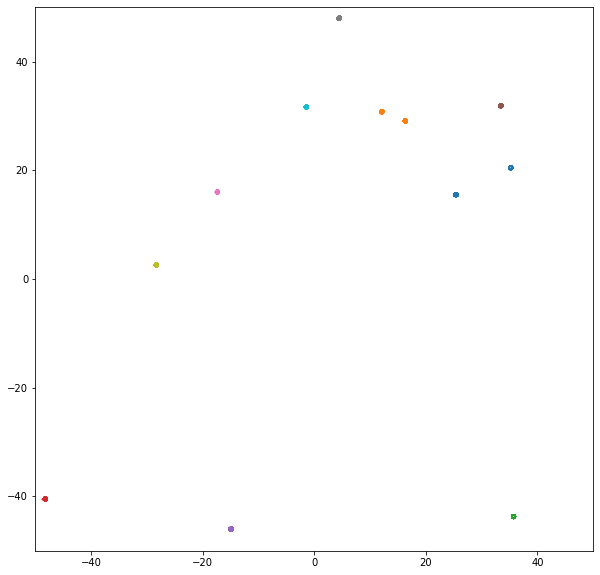

In [66]:
plt.figure(figsize=(10,10))
plt.xlim(-50,50)
plt.ylim(-50,50)
for fish_id in range(fishes):
    plt.plot(track[fish_id, :, 0], track[fish_id, :, 1])
plt.show()